## Setup

__Notes:__

1. Running on DBR 16.1+ for PySpark bindings.
1. Running on a "classic" cluster (vs Serverless) as we are applying Spark configs.
1. Reach out to your sales team to join the spatial sql private preview (aka you need the proper config to apply in the cell currently showing `%run ../common/classic_enable_spatial_preview.py`)

---
__Original Author:__ Timo Roest | __Maintainer:__ Michael Johns | _Last Updated:_ 06 FEB 2025 

In [0]:
%pip install -U "databricks-spatial[viz] @ git+https://github.com/databrickslabs/mosaic.git@spatial-utils-v1" --quiet

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
spark.conf.set("spark.databricks.optimizer.adaptive.enabled", False) # <-- turn off AQE
spark.conf.set("spark.sql.shuffle.partitions", 1_024)                # <-- default is 200

# -- import databricks + spark functions
from pyspark.databricks.sql import functions as dbf
from pyspark.sql import functions as F
from pyspark.sql.functions import col, udf
from pyspark.sql.types import *

# --other imports
import os
import warnings

warnings.simplefilter("ignore")

__Configure Database__

> Adjust this to settings from the Data Prep notebook.

In [0]:
catalog_name = "geospatial_docs"
db_name = "ship2ship"

sql(f"use catalog {catalog_name}")
sql(f"use schema {db_name}")

DataFrame[]

In [0]:
# - VIZ
from spatial.viz.keplergl import *
from spatial.viz.helpers import *

kviz = KeplerViz(spark)

In [0]:
%run ../common/classic_enable_spatial_preview.py


We begin with loading from a table. Here we use captured `AIS` data.

<p/>

- `MMSI`: unique 9-digit identification code of the ship - numeric
- `VesselName`: name of the ship - string
- `CallSign`: unique callsign of the ship - string
- `BaseDateTime`: timestamp of the AIS message - datetime
- `LAT`: latitude of the ship (in degree: [-90 ; 90], negative value represents South, 91 indicates ‘not available’) - numeric
- `LON`: longitude of the ship (in degree: [-180 ; 180], negative value represents West, 181 indicates ‘not available’) - numeric
- `SOG`: speed over ground, in knots - numeric
- `Status`: status of the ship - string

In [0]:
cargos = spark.read.table("AIS")
display(cargos.limit(5)) # <- limiting for ipynb only

MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TranscieverClass
373033000,2018-01-31T23:37:21Z,49.22932,-123.77754,13.3,75.7,76.0,CAPE RAINBOW,IMO9603398,3EVI3,70,0,300,50,18.2,null,A
373033000,2018-01-31T23:38:32Z,49.23039,-123.77101,13.3,76.2,77.0,CAPE RAINBOW,IMO9603398,3EVI3,70,0,300,50,18.2,null,A
373033000,2018-01-31T23:52:23Z,49.24247,-123.69478,13.4,77.0,76.0,CAPE RAINBOW,IMO9603398,3EVI3,70,0,300,50,18.2,null,A
373033000,2018-01-31T23:50:02Z,49.24049,-123.70767,13.3,76.7,77.0,CAPE RAINBOW,IMO9603398,3EVI3,70,0,300,50,18.2,null,A
373033000,2018-01-31T23:48:52Z,49.23949,-123.71412,13.3,77.0,77.0,CAPE RAINBOW,IMO9603398,3EVI3,70,0,300,50,18.2,null,A


## AIS Data Indexing

> To facilitate downstream analytics it is also possible to create a quick point index leveraging a chosen H3 resolution.
In this case, resolution `9` has an edge length of ~174 metres.

In [0]:
cargos_indexed = (
    cargos.withColumn(
        "point_geom",
        dbf.st_asbinary(dbf.st_point("LON", "LAT"))
    )
    .select(F.expr("inline(h3_tessellateaswkb(point_geom, 9))"), "*")
    .withColumn("sog_kmph", F.round(col("sog") * 1.852, 2))
    .drop("core", "chip")
)
display(cargos_indexed.limit(5)) # <- limiting for ipynb only

cellid,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TranscieverClass,point_geom,sog_kmph
618212878508359679,636017971,2018-01-31T08:47:41Z,23.09007,-90.90633,20.7,265.2,265.0,CAP BEATRICE,IMO9275062,A8EG9,70,0,210,30,11.5,79,A,AQEAAACOWItPAbpWwMlZ2NMOFzdA,38.34
618212878033616895,636017971,2018-01-31T08:39:35Z,23.09389,-90.85615,20.7,264.5,264.0,CAP BEATRICE,IMO9275062,A8EG9,70,0,210,30,11.5,79,A,AQEAAAAbnl4py7ZWwONrzywJGDdA,38.34
617761314139799551,636015646,2018-01-31T11:48:39Z,45.56443,-73.51946,0.0,31.0,31.0,EM KEA,IMO9334351,A8NN6,70,5,220,32,12.2,79,A,AQEAAAAh5SfVPmFSwM5wAz4/yEZA,0.0
617761314139799551,636015646,2018-01-31T11:27:32Z,45.56437,-73.51939,0.0,31.0,31.0,EM KEA,IMO9334351,A8NN6,70,5,220,32,12.2,79,A,AQEAAACl942vPWFSwPhrskY9yEZA,0.0
617761314139799551,636015646,2018-01-31T11:30:32Z,45.56437,-73.5194,0.0,32.0,32.0,EM KEA,IMO9334351,A8NN6,70,5,220,32,12.2,79,A,AQEAAAC3Yn/ZPWFSwPhrskY9yEZA,0.0


_We will write the treated output to a new table._

In [0]:
(
    cargos_indexed
    .write.mode("overwrite")
    .saveAsTable("cargos_indexed")
)

_We will optimize our table to colocate data and make querying faster._

In [0]:
%sql 
ALTER TABLE cargos_indexed CLUSTER BY (cellid, BaseDateTime);

OPTIMIZE cargos_indexed;

path,metrics
s3://databricks-e2demofieldengwest/b169b504-4c54-49f2-bc3a-adf4b128f36d/tables/2ceb1e70-d7c6-435f-bfc5-11e7da61c333,"List(0, 0, List(null, null, 0.0, 0, 0), List(null, null, 0.0, 0, 0), 0, null, null, 0, 0, 1, 0, false, 0, 0, 1738867170872, 1738867177280, 12, 0, null, List(0, 0), 20, 20, 0, 0, List(18199937, true, false, false, 0, 0, 0, 0, 1, 18199937, 18199937, null, log, 16777216, 67108864, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, List(103, 3, 0, 0, 0, 4987), 2, 1, 5, sizeAware))"


In [0]:
%sql select format_number(count(1), 0) as count from cargos_indexed

count
"521,867"


## Visualization
And we can perform a quick visual inspection of the indexed AIS data.


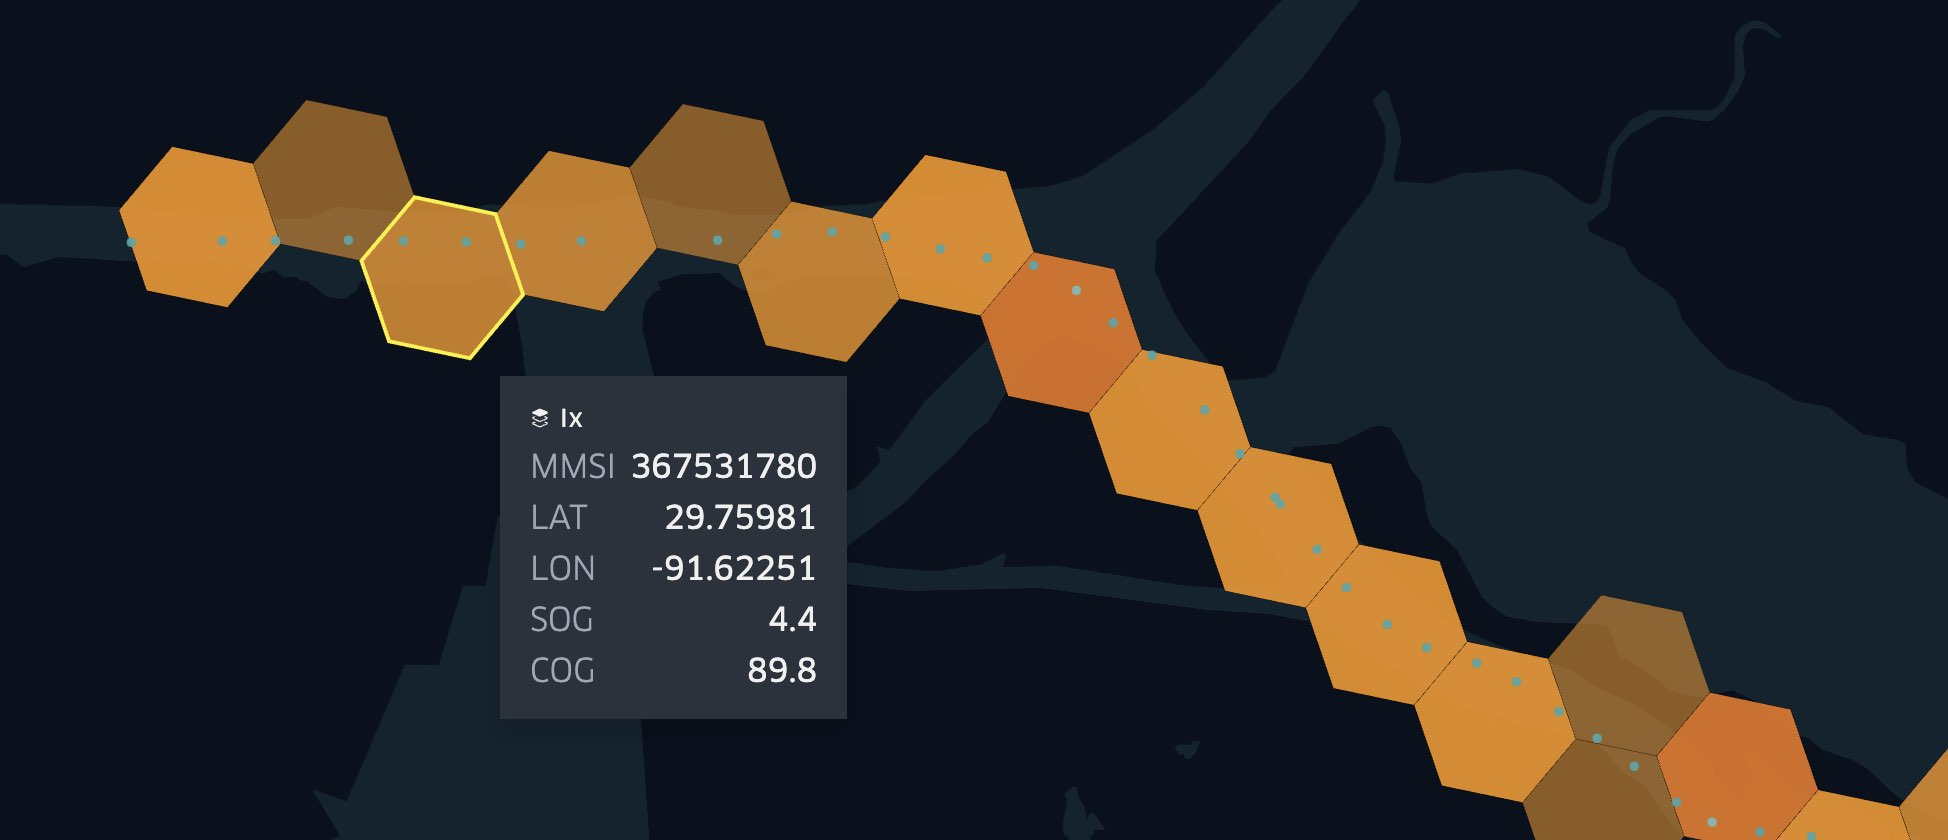

In [0]:
displayHTML("""<img src='data:image/jpeg;base64,/9j/4AAQSkZJRgABAgEASABIAAD/4QDoRXhpZgAATU0AKgAAAAgABgESAAMAAAABAAEAAAEaAAUAAAABAAAAVgEbAAUAAAABAAAAXgEoAAMAAAABAAIAAAITAAMAAAABAAEAAIdpAAQAAAABAAAAZgAAAAAAAACQAAAAAQAAAJAAAAABAAiQAAAHAAAABDAyMjGRAQAHAAAABAECAwCShgAHAAAAEgAAAMygAAAHAAAABDAxMDCgAQADAAAAAQABAACgAgAEAAAAAQAAB5ygAwAEAAAAAQAAA0ikBgADAAAAAQAAAAAAAAAAQVNDSUkAAABTY3JlZW5zaG90AAD/4g0gSUNDX1BST0ZJTEUAAQEAAA0QYXBwbAIQAABtbnRyUkdCIFhZWiAH5wALABYACgARACNhY3NwQVBQTAAAAABBUFBMAAAAAAAAAAAAAAAAAAAAAAAA9tYAAQAAAADTLWFwcGwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABFkZXNjAAABUAAAAGJkc2NtAAABtAAAAepjcHJ0AAADoAAAACN3dHB0AAADxAAAABRyWFlaAAAD2AAAABRnWFlaAAAD7AAAABRiWFlaAAAEAAAAABRyVFJDAAAEFAAACAxhYXJnAAAMIAAAACB2Y2d0AAAMQAAAADBuZGluAAAMcAAAAD5tbW9kAAAMsAAAACh2Y2dwAAAM2AAAADhiVFJDAAAEFAAACAxnVFJDAAAEFAAACAxhYWJnAAAMIAAAACBhYWdnAAAMIAAAACBkZXNjAAAAAAAAAAhEaXNwbGF5AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAbWx1YwAAAAAAAAAmAAAADGhySFIAAAASAAAB2GtvS1IAAAASAAAB2G5iTk8AAAASAAAB2GlkAAAAAAASAAAB2Gh1SFUAAAASAAAB2GNzQ1oAAAASAAAB2GRhREsAAAASAAAB2G5sTkwAAAASAAAB2GZpRkkAAAASAAAB2Gl0SVQAAAASAAAB2GVzRVMAAAASAAAB2HJvUk8AAAASAAAB2GZyQ0EAAAASAAAB2GFyAAAAAAASAAAB2HVrVUEAAAASAAAB2GhlSUwAAAASAAAB2HpoVFcAAAASAAAB2HZpVk4AAAASAAAB2HNrU0sAAAASAAAB2HpoQ04AAAASAAAB2HJ1UlUAAAASAAAB2GVuR0IAAAASAAAB2GZyRlIAAAASAAAB2G1zAAAAAAASAAAB2GhpSU4AAAASAAAB2HRoVEgAAAASAAAB2GNhRVMAAAASAAAB2GVuQVUAAAASAAAB2GVzWEwAAAASAAAB2GRlREUAAAASAAAB2GVuVVMAAAASAAAB2HB0QlIAAAASAAAB2HBsUEwAAAASAAAB2GVsR1IAAAASAAAB2HN2U0UAAAASAAAB2HRyVFIAAAASAAAB2HB0UFQAAAASAAAB2GphSlAAAAASAAAB2ABDAG8AbABvAHIAIABMAEMARAAAdGV4dAAAAABDb3B5cmlnaHQgQXBwbGUgSW5jLiwgMjAyMwAAWFlaIAAAAAAAAPMWAAEAAAABFspYWVogAAAAAAAAgwoAAD1u////vFhZWiAAAAAAAABL+gAAtCEAAArgWFlaIAAAAAAAACfSAAAOcAAAyJFjdXJ2AAAAAAAABAAAAAAFAAoADwAUABkAHgAjACgALQAyADYAOwBAAEUASgBPAFQAWQBeAGMAaABtAHIAdwB8AIEAhgCLAJAAlQCaAJ8AowCoAK0AsgC3ALwAwQDGAMsA0ADVANsA4ADlAOsA8AD2APsBAQEHAQ0BEwEZAR8BJQErATIBOAE+AUUBTAFSAVkBYAFnAW4BdQF8AYMBiwGSAZoBoQGpAbEBuQHBAckB0QHZAeEB6QHyAfoCAwIMAhQCHQImAi8COAJBAksCVAJdAmcCcQJ6AoQCjgKYAqICrAK2AsECywLVAuAC6wL1AwADCwMWAyEDLQM4A0MDTwNaA2YDcgN+A4oDlgOiA64DugPHA9MD4APsA/kEBgQTBCAELQQ7BEgEVQRjBHEEfgSMBJoEqAS2BMQE0wThBPAE/gUNBRwFKwU6BUkFWAVnBXcFhgWWBaYFtQXFBdUF5QX2BgYGFgYnBjcGSAZZBmoGewaMBp0GrwbABtEG4wb1BwcHGQcrBz0HTwdhB3QHhgeZB6wHvwfSB+UH+AgLCB8IMghGCFoIbgiCCJYIqgi+CNII5wj7CRAJJQk6CU8JZAl5CY8JpAm6Cc8J5Qn7ChEKJwo9ClQKagqBCpgKrgrFCtwK8wsLCyILOQtRC2kLgAuYC7ALyAvhC/kMEgwqDEMMXAx1DI4MpwzADNkM8w0NDSYNQA1aDXQNjg2pDcMN3g34DhMOLg5JDmQOfw6bDrYO0g7uDwkPJQ9BD14Peg+WD7MPzw/sEAkQJhBDEGEQfhCbELkQ1xD1ERMRMRFPEW0RjBGqEckR6BIHEiYSRRJkEoQSoxLDEuMTAxMjE0MTYxODE6QTxRPlFAYUJxRJFGoUixStFM4U8BUSFTQVVhV4FZsVvRXgFgMWJhZJFmwWjxayFtYW+hcdF0EXZReJF64X0hf3GBsYQBhlGIoYrxjVGPoZIBlFGWsZkRm3Gd0aBBoqGlEadxqeGsUa7BsUGzsbYxuKG7Ib2hwCHCocUhx7HKMczBz1HR4dRx1wHZkdwx3sHhYeQB5qHpQevh7pHxMfPh9pH5Qfvx/qIBUgQSBsIJggxCDwIRwhSCF1IaEhziH7IiciVSKCIq8i3SMKIzgjZiOUI8Ij8CQfJE0kfCSrJNolCSU4JWgllyXHJfcmJyZXJocmtyboJxgnSSd6J6sn3CgNKD8ocSiiKNQpBik4KWspnSnQKgIqNSpoKpsqzysCKzYraSudK9EsBSw5LG4soizXLQwtQS12Last4S4WLkwugi63Lu4vJC9aL5Evxy/+MDUwbDCkMNsxEjFKMYIxujHyMioyYzKbMtQzDTNGM38zuDPxNCs0ZTSeNNg1EzVNNYc1wjX9Njc2cjauNuk3JDdgN5w31zgUOFA4jDjIOQU5Qjl/Obw5+To2OnQ6sjrvOy07azuqO+g8JzxlPKQ84z0iPWE9oT3gPiA+YD6gPuA/IT9hP6I/4kAjQGRApkDnQSlBakGsQe5CMEJyQrVC90M6Q31DwEQDREdEikTORRJFVUWaRd5GIkZnRqtG8Ec1R3tHwEgFSEtIkUjXSR1JY0mpSfBKN0p9SsRLDEtTS5pL4kwqTHJMuk0CTUpNk03cTiVObk63TwBPSU+TT91QJ1BxULtRBlFQUZtR5lIxUnxSx1MTU19TqlP2VEJUj1TbVShVdVXCVg9WXFapVvdXRFeSV+BYL1h9WMtZGllpWbhaB1pWWqZa9VtFW5Vb5Vw1XIZc1l0nXXhdyV4aXmxevV8PX2Ffs2AFYFdgqmD8YU9homH1YklinGLwY0Njl2PrZEBklGTpZT1lkmXnZj1mkmboZz1nk2fpaD9olmjsaUNpmmnxakhqn2r3a09rp2v/bFdsr20IbWBtuW4SbmtuxG8eb3hv0XArcIZw4HE6cZVx8HJLcqZzAXNdc7h0FHRwdMx1KHWFdeF2Pnabdvh3VnezeBF4bnjMeSp5iXnnekZ6pXsEe2N7wnwhfIF84X1BfaF+AX5ifsJ/I3+Ef+WAR4CogQqBa4HNgjCCkoL0g1eDuoQdhICE44VHhauGDoZyhteHO4efiASIaYjOiTOJmYn+imSKyoswi5aL/IxjjMqNMY2Yjf+OZo7OjzaPnpAGkG6Q1pE/kaiSEZJ6kuOTTZO2lCCUipT0lV+VyZY0lp+XCpd1l+CYTJi4mSSZkJn8mmia1ZtCm6+cHJyJnPedZJ3SnkCerp8dn4uf+qBpoNihR6G2oiailqMGo3aj5qRWpMelOKWpphqmi6b9p26n4KhSqMSpN6mpqhyqj6sCq3Wr6axcrNCtRK24ri2uoa8Wr4uwALB1sOqxYLHWskuywrM4s660JbSctRO1irYBtnm28Ldot+C4WbjRuUq5wro7urW7LrunvCG8m70VvY++Cr6Evv+/er/1wHDA7MFnwePCX8Lbw1jD1MRRxM7FS8XIxkbGw8dBx7/IPci8yTrJuco4yrfLNsu2zDXMtc01zbXONs62zzfPuNA50LrRPNG+0j/SwdNE08bUSdTL1U7V0dZV1tjXXNfg2GTY6Nls2fHadtr724DcBdyK3RDdlt4c3qLfKd+v4DbgveFE4cziU+Lb42Pj6+Rz5PzlhOYN5pbnH+ep6DLovOlG6dDqW+rl63Dr++yG7RHtnO4o7rTvQO/M8Fjw5fFy8f/yjPMZ86f0NPTC9VD13vZt9vv3ivgZ+Kj5OPnH+lf65/t3/Af8mP0p/br+S/7c/23//3BhcmEAAAAAAAMAAAACZmYAAPKnAAANWQAAE9AAAApbdmNndAAAAAAAAAABAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAbmRpbgAAAAAAAAA2AACuAAAAUgAAAEPAAACwwAAAJoAAAA2AAABQAAAAVEAAAjMzAAIzMwACMzMAAAAAAAAAAG1tb2QAAAAAAAAGEAAAoEQAAAAA2ZNdgAAAAAAAAAAAAAAAAAAAAAB2Y2dwAAAAAAADAAAAAmZmAAMAAAACZmYAAwAAAAJmZgAAAAIzMzQAAAAAAjMzNAAAAAACMzM0AP/AABEIA0gHnAMBIgACEQEDEQH/xAAfAAABBQEBAQEBAQAAAAAAAAAAAQIDBAUGBwgJCgv/xAC1EAACAQMDAgQDBQUEBAAAAX0BAgMABBEFEiExQQYTUWEHInEUMoGRoQgjQrHBFVLR8CQzYnKCCQoWFxgZGiUmJygpKjQ1Njc4OTpDREVGR0hJSlNUVVZXWFlaY2RlZmdoaWpzdHV2d3h5eoOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4eLj5OXm5+jp6vHy8/T19vf4+fr/xAAfAQADAQEBAQEBAQEBAAAAAAAAAQIDBAUGBwgJCgv/xAC1EQACAQIEBAMEBwUEBAABAncAAQIDEQQFITEGEkFRB2FxEyIygQgUQpGhscEJIzNS8BVictEKFiQ04SXxFxgZGiYnKCkqNTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqCg4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre4ubrCw8TFxsfIycrS09TV1tfY2dri4+Tl5ufo6ery8/T19vf4+fr/2wBDAAQEBAQEBAYEBAYJBgYGCQwJCQkJDA8MDAwMDA8SDw8PDw8PEhISEhISEhIWFhYWFhYaGhoaGh0dHR0dHR0dHR3/2wBDAQQFBQcHBw0HBw0eFBEUHh4eHh4eHh4eHh4eHh4eHh4eHh4eHh4eHh4eHh4eHh4eHh4eHh4eHh4eHh4eHh4eHh7/3QAEAHr/2gAMAwEAAhEDEQA/APh+iiiu45wooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqzBbmU5PCjrRbwGVsnhRWsqhQFUYAoIlIFUKAqjAFLRRVGQUUUUAFFFFABRRRQAVUup/LXYv3iPyqWaUQpu7noKxmZnYsxyTSLir6iUUUUjUKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//9D4foooruOcKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqaGFpWwOnc02KNpW2rWzHGI1CigmTsKqhFCr0FOooqjEKKKKACiiigAooooAKazKilmOAKdWVdT+Y2xT8q/qaBpXIJZDK5c/gKjooqTcKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooq9a24Yb3HHYUCbsV44JJfujj1qwLF8HLDNXndIk3NwB2FVDfLnhDj60yLt7FWS3liGWGR6ioK10uoX4J2/Wq89oeXiHHdf8ACgal3KFFFFIsKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/R+H6KKK7jnCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApyIXYKoyTSKCxwK2IIREv+0etBLdh0MQiTaOvepaKKoxCiiigAooooAKKKKACiio5ZBEhc/gKAK91P5a+Wv3m/QVl05mZ2LMck02pN0rBRRRQMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigB8ahpFU9zitwAKAB0FYsP+uT6itl22ozegJpoznuZFxI0khyeFJAqCiikaBVqG6eP5W+Zf5VVooE1ct3LQPho/vHrj+vvVSiigErBRRRQMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//S+H6KKK7jnCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAClAzSVp21vtAkfr2FAm7D7e3EQ3N94/pVqiiqMWwooooEFFFFABRRRQAUUUUAISAMngCseeYzPn+EcCrF3Pk+SvTv8A4VQpM1iuoUUUUiwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCWH/XJ9RWxIC0bAdwax4f9cn1FbdNGUtzn6KKKRqFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/0/h+iiiu45wooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiirltbl/nf7v8AOgTdh9tbZ/eSdOwrRooqjFu4UUUUCCiiigAooooAKKKKACq9zN5ScfePSpZJFjUux4rFkkaRy7d6RcVcZ15NFFFI1CiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCWH/XJ9RW3WLACZkx2NbJIAyeAKaMp7mEw2sV9Dim0523OzDuSabSNQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD//U+H6KKK7jnCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooq5b2xc7n4X+dAm7DLeAyNk8KK1gABgdBQAFGAMClpmLdwooopiCiiigAooooAKKKKACmSSLGpdjxRJIsal2PFY8srTNubp2HpQVFXCWVpm3N07D0qKiipNgooooAKKKKACiiigAooooAKKuW9t5nzv93+dMuLfyTuXlT+lArq9itRRRQMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiinxoXcKO9AF+ziwpkPU8Cn3km2PYOrfyqyAsaY6BRWPPL50m7oOgpmS1dyGiiikahRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH//1fh+iiiu45wooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAClVWdgqgszHAA5JJpK9b8EeF2g261qCYdhmBD2B/jI9T2/P0rkxWJjQp88vkdGHoSqz5UYkfw71WS0jnE0SSuu5onyNvoMgHn14rIuvBniK1yTamVR3jYNn8M7v0r3+ivlo5xiE9bM9+WW0WtLo+Xri1ubR/LuoXhb0dSp/I1BX1M6JIu2RQw9CMisK68L6BeZM1jGCe6DYf/HcV6FPO4/bh9xxzyt/YkfO1Fez3Xw60mXJtZpYCexw6/kcH9a5u7+HOpxEmzuIp19GyjflyP1r0KeaYaf2repxzwFePS555RXQXXhXxBacy2UjD1jw/wD6CTWHJFLC5jmRkYdQwIP5GvQhVhP4JJnHKnKPxKxHRRRWhAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUVq6NpF1rV8lnbDGeXfsi9yf6Dua98t9C0q3sY9P8As0ckUY6OobJ7k5zya8vGZhDDtRauzvw2DlWTd7I+bqK99uvBPh25yRbGFj3jYj9Mlf0rnbr4bWzZNleOnoJFDfqNv8qyp5vh5fFdf15Gk8trLbU8kortrrwBr8AJiWK4A/uPg/8Aj22udutF1eyybqzmjA6sUO38xxXoU8VRn8E0zjnQqR+KLMuiiiukwCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACjrShSxwK1ILYRgM/LfyoE3YjgtcYeQfhV+iiqMW7hRRRQIKKKKACiiigAooooAKa7qilmOAKGZUUsxwBWRPO0zeijoKCkriTStM+49OwqGiipNgooooAKKKKACiiigAooooAKsW0aySYb6/Wq9ORijB16igTN4AAYFQXCb4WHccj8KlRg6hl6GnVRic/RUkyeXIyeh4+lR1JuFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUoBPSgBKKnFtMRnbS/ZZv7tAror0VY+yzf3aPss392gLor0VY+yzf3aPss392gLor0VY+yzf3aPss392gLor1qWsGwb26npTYbTaQ0nPtUtzOIlwp+c9Pb3pkN30RWvJsnyl6Dr9fSqNFFItKwUUUUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/9b4foooruOcKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiuo8LeHZNevP3mVtYcGVh39FHuf0/KsqtWNODnN6I0p05Tkox3NjwZ4XOpSrql8v+ixt8in/low/9lB/Pp617RUcMMVvEkEKhI41Cqo6ADgCpK+CxeKliKnPLbofW4ehGjDlQUUUVxnSFFFFABRRRQAVDPb29ynl3MSSp/ddQw/I1NRTTtqgOZuvB3h26+9aLGfWIlP0Bx+lc5dfDaxfmzu5Ij6SAOP0216TRXXTxuIh8M2c08LRlvFHzrr/h+68P3EcNw6yLKpZWXOODgjnuOPzrBr3Hx7p32zRftSDMlmwf/gLcN/Q/hXh1fY5fiXXoqUt+p83jKCpVOVbBRRRXonEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFWbO0uL+5js7Vd8spwoqBVZ2CICWY4AHUk17r4S8NJott9puRm9mHzf7C/wB0f1NefjcZHD079XsdmFwzrTt06mr4f0O30GxFtGd8rfNK/wDeb+gHatyiivhJzlOTnJ6s+sjFRSjHYKKKKgoKKKKAKFzpem3uTd2sUpbqWQE/njNc1deAvD9xkxJJbk/883P8m3V2lFb08RVp/BJoynRpz+KKZ5VdfDVuTZXoPosif+zA/wBK5u68DeIbYnZCs6jvGwP6Ng/pXvNFehTzbEx3d/U455dRlsrHzHc6ff2Rxd28kP8AvqV/mKp19UEAjB5BrzH4g6RAtnDqVtEsbRvtkKgDIfoTjrgj9a9fC5t7Woqc42uediMu9nBzjK9jyWiiivoDxwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACnpG0jbVGafDC0rYHTua1ooliXav4mglysMhgWIerdzU9FFUYhRRRQAUUUUAFFFFABRRRQAUUVUupvLXYv3m/QUDSuVrufe3lqflHX3NU6KKk2SsFFFFAwooooAKKKKACiiigAooooAKKKKANCyl6xH6itCsFGKMHXqK3VO5Qw7jNNGUkZ98nKyfgaoVtXCb4WHccj8KxaGVF6BRRRSLCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACgDPSitK1gwPMcc9v8aBN2II7R35b5RWhHDHH90c+pqWoJbiOIcnLegp2Mm2yeqrXkKnAy3uKoS3EkvXhfQVBRcpQ7mkL5M8qcVIt5CeuV+o/wAKyaKLlcqNpbiFujj8eP51IrK33SD9KwaKLk8h0FFYQkdRhWI+hpTLKw2liR9aLhyGhPdBMpHy38qzCSTknJpKKRaVgooooGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH/9f4foooruOcKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKtWVncahdR2dom+WU4Uf57Acmk2krsaTbsi5ouj3Wt3yWdsMDq79kXuT/h3r6F07T7XS7SOytF2xxj8Se5Puaz/D+hwaDYi2jO+Vvmlf8AvN/gO1btfD5hjnXnyx+Ff1c+pweFVGN3uwoooryj0AooooAKKKKACiiigAooooAKKKKAIbiCO6gktpRlJUZGHswwa+Zry1ksruazlBDwuyHIx0OM/jX0/XifxB0/7Nq6XiDCXaZP++nB/TFe/k1blqum+v6HkZnSvTU10ODooor68+cCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKK9D8F+FzfSrq1+n+jRnMaMP9Yw7n/ZH6mufEV4UYOpM2o0pVZqETb8EeGDbINY1CPErD9yjD7oP8R9z29B9ePSqKK+BxGInWqOpM+uo0Y0oKEQooornNgooooAKKKKACiiigAooooAKztXsV1LTLmxb/AJaoQP8AeHKn8wK0aKqMnFqS6CaTVmfLLKyMUYYZTgj3FNrqvGenHT9enIGI7n98n/Avvf8Aj2a5Wv0ejUVSmprqfFVIOE3B9AooorUzCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKkjieQ4UUAR9auw2jN80nA/WrUNskXJ5arNOxm5dhqqqDCjAp1FFMzCiiigAooooAKKKKACiiigAoooJAGTwBQBHLIIkLn8PesVmLsWbqaluJjM/wDsjpUFI2irBRRRSKCiiigAooooAKKKKACiiigAooooAKKKKACtyE5iU+1YdbNt/qE/z3poiZPXP10FYcv+tfH94/zoYoEdFFFI0CiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKmhiaVsDp3NAEttB5h3N90VpsyopZjgCk+SJPRVrKnnaZvRR0FMy+Jkst4zcR/KPXvVLryaKKRolYKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH//Q+H6KKK7jnCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvevCPwdi1bQl1HXZ5rW4ugHhjj2gonODIGByW4OBjAxnnIFf4T+AG1C4XxLrUP+hxc20bjiV/75B/gXt6n2HP05XwmeZ5KE/q+FlZrd/p/n9x9blWVRnH21daPZfr/AJHzTqXwK1OIbtJ1OG44+7OjRfkV35/IVw2ofC/xvp+5m01p0X+KBlkzzjhQd3/jtfZ9FeNR4lxsPjtL1X+Vj06uR4WXw3Xo/wDO5+ft5p+oac/l6hbS2r/3ZUZD6dGA9Kp1+hckUc0bRTIHRhgqwyCPcGuQ1H4feDdUDfadKhVm/ihBibpgcxla9qjxXB/xqbXo7/nY8urw9L/l3P7z4jor6k1D4H+HJ9zafd3Nox6BisiDn0IDdOPvVxOofA3XoAW02+t7sDs4aJj9B849OrV7VHiDA1Pt29V/SPLqZPi4fZv6HiNFdnf/AA98aaarPc6TOyr3hAm/H92W4rkZoZreQw3EbRSLwVcFSMccg817NLEUqqvTkn6O55lSjUp6Ti16kVFFFbmQ5VZ2CICWY4AHUk17t4S8MpolsLm4Gb2ZfnP9wHnaP6n1rG8EeF/syLrGoR/vnGYUb+EH+Ij1Pb0H6ek18lmmP537Gm9OvmfRYDCcq9rPfoFFFFfPHsBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXGeOtP+26G8yDL2rCUf7vRv0Ofwrs6jmiSeJ4JRlJFKsPUEYNbUarp1I1F0M6sFODg+p8t0Vbv7OSwvZ7KTloHZCfXB6/j1qpX6PGSkk0fFNNOzCiiimIKKKKACiiigAooooAKKKKACiiigAooooAKKK0dJ0q+1vUIdN0+PzJpjgeijuzHsB1JqZSUYuUnZIqMXJqK3IrTT9Qv9/2G1mufKAL+UjPtB4GdoOM9s1VZWRijgqw6g8Gvs3wz4csfDGmJp9muW+9LIfvSP3J9uwHYVrXen2F+nl31tFcr6Sorj8mBr42XE0VUaVO8emup9LHI24JudmfDVFfWl98NPB99k/Yvs7HPMLMnX2yV/SuMvfgtZsc6dqckY9JkD/qpT+VehS4hwk/ivH1X+VzjqZNiI/DZ/15nz9RXp978JPFlsf9GEF2P+mcm0/iJAo/WuMv/DXiDSyft+nXESr1YoSn/fQyv6169LHYar/DqJ/M86pha1P44NGHRRRXacoUUUUAFFFbGh6Nc65fLaQDC9ZH7Kvr9fT3qJzjCLlJ6IqMXJqMdzT8K+G5Neui8uVtISPMYfxH+6D6+voPwr3qKKOGNYYVCIgCqqjAAHQAVW0+wtdMtI7KzTZHGMD1J7k+pPerlfCY3GSxE79FsfWYXDKjC3XqFFFFeedgUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB538RdPE2nQ6ig+a2fax/2H45+jYx9a8br6b1GzTULC4sn4EyMmfQkcH8DXzPJG8MjRSDDISpHoRwa+wyatzUnTfT9T5zM6XLUU11GUUUV7x5AUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFexeAfhafFFhLqusyTWls2FtvLwGk/vOdwPydhjqc9hzx4vGUsNT9rWdkdOHw1SvP2dNXZ47RXvd/wDAm/QZ0zVYpT/dnjaP9VL/AMv/AK/Eaj8KvG+nBn+wi6Rf4rd1ft2XIc/981yUc4wVX4aq+en52OipluKp/FB/LX8jzuirt5puo6cQuoWs1qTwBNGyHj/eAqlXqxkpK8Xc89pp2YUUUVQgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACjGaljieQ4UVpw2yRcnlqCXKxUhtC3zScD9a0VVUGFGBTqKZk3cKKKKYgooooAKKKKACiiigAooooAKKKKACsq4uDKdicIP1p9zc7v3cZ47n1qjSNYx6sKKKKRYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFbkIAiUD0z+dYijLACt/pxTRnMazbVLegzWDWxdNthPqeKx6GOAUUUUiwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACtqCNY4xgckZNY6As4UdzW47bEZvQZpozn2My7mLv5Y+6p/WqlHXmikWlYKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//0fh+iiiu45wooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvTPhz4Dn8WX4vLxSml2rDzG6eYw58tT/6Eew9yK57wd4UvPF+sJp9vmOFMPPNgkRp+WNx6KD1PsDX2lpOk2Oh6dDpemxiK3gXaoHU+pJ7sTyT3NfKZ7m/1aHsKL99/gv8APsfQ5Tlvt5e1qL3V+P8AwC9FFHDGkMKCOOMBVVRgKBwAAOAAKfRRX5cfehRRRQAUUUUAFFFFABVa6s7O+j8m9gjuIz/DIocevQg+lWaKabTuhNX0ZwWofDLwTqJLPpqQMTnMBaL8lUhf0rgdR+Emi6HLDq1rNPcQxSjfDNtYfNwpyoU4DY4wevPANe91Uv7RL+yns3wBMhUEjO0now5HIPI5HNepQzTFU2o+0dvW+hwVsBQmr8iueSUUik4w2AykqwGeGBwRyAeDxyAfUClr2TywooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPGfiHpxg1OLUEX5LpMMf8AbTj/ANBx+Vee1734104X+gzOozJa/vl+i/e/8dzXglfcZVW9ph0nutD5bH0uSs331CiiivWPOCiiigAooooAKKKKACiiigAooooAKKKKAJre3nup0traNpZZWCoijJYnoAK+rvAng2Lwrp5a42vqFwMzOMHaOyKcZwO/qfwrnPht4EGkwpr+rR/6bMuYY2H+qRh1IPRyPyHHXNev1+e53mvtn9Xov3Vv5v8AyPscqy/2a9tUXvPbyCiiivkz6EKKKKACiiigDKvdD0XUjnULC3uG/vSRqx9epGa42/8AhV4QvATDDJaNjrFIcZ+j7h+WK9HorqpYuvS/hza+ZhUw9Kp8cUzwW/8Ags4JbS9TB9EnTH5up/8AZa469+FnjC0P7u3julHeGRf5PtP6V9V0V69LP8ZDdp+q/wArHm1Mow0tk16P/M+LD4Y8QJdR2c2nzwySnC+ZGyr9ckYwO5r3HQdEt9CsVtYsNIeZH7s3+A7V6frFq11p8qRrukT95GO5ZecA9t33c+h7jiuIR1kRZEOVYAg+oNdlXNamLgk1axz08vhh5XTuOoooriOkKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvBvG+n/YddlkUYS6AlH1PDfqM/jXvNef8AxD0/7RpUd8gy1q/P+4/B/XFerldb2eISez0ODH0+ei/LU8Xooor7k+UCiiigAooooAKKKKACiiigAooooAKKKKACiiuu8GeEbzxjqwsYD5UEQD3E3XYnsO7N0A/HoDWNatClB1KjskaUqcqk1CCu2dB8OPAU/iq/W/vUK6VauPNJ481hz5a+x43HsOnJr6+REjRY41CooAVQMAAdABVPTNNs9IsINM0+Pyre3UIi9ePcnkknknuavV+QZpmU8bW53pFbL+up+kYDAxwtPlW73YUUUV5B6Q10SRSkihlPUEZFcpf+A/B2pDF1pFuCepiXym/OPaa62itadapTd6cmvR2M504TVppP1PGdQ+CPhm4y1hc3NoxzgZEij04Izgf71cNf/AzXoTnTr+2uVH/PQNE3X0AcfrX0/RXsUc9x1Papf11/4J5tTKcJP7FvTQ+Kb/4b+NtPG6XSpZF9YSsv6Rlj29K42e3ntZTBcxvDIvVHUqw+oODX6EVXuLS1vEMV3Ck6HjbIoYc+xzXtUeK6q/i00/TT/M8urw9Tf8ObXrr/AJH580V9qX/w18Eagd0ulxxN6wFou+eiEL+leYeLfg5punaPd6rolzcGS1iMphl2uGCctggKR8uT3z0r3cNxJhKslCScW++x5VbJMRTTkrNI+eqKKK+oPACiiigAooooAKKKKACiipY4XlOFFAEWM1ehtC3zScD0q1DbpFz1b1qxTsZOXYaqqgwowKdRRTICiiigAooooAKKKKACiiigAooooAKKKKACs66uCSYkPHc/0p9zc7cxxnnufSs2kzSMerCiiikaBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAWLZC8o9ua2KqWce2PeerVbpoxk9ShfNwi+uTWdVq8bMxH90Af1qrSNI7BRRRQUFFFFABRRSgE8AZoASirK2szc4x9ak+xSeooFdFKir4sW/iYD6U77CP7/wClAuZGdRWoLKPuTThZwj1NFhcyMmitn7LB/d/nThBEOij8eadg5zEorXa0hboMfSq7WLfwNn60rD5kUKKma3mXqp/DmoaCrhRRRQAUUUUAFFFFAFi1GZlzV28YiHA7kD+tQWK/OzegxT74nCL2OTTM38RnUUUUjQKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD//S+H6KKK7jnCiiigAooooAKKKKACiiigAooooAKKKKACiiigArT0fR9Q17UYdL0yMyTzHA64Ud2YjOFHUmqVvbz3c8draxtLNKwVEQZZmPAAA6mvsP4d+BovCGmmS6CyaldAGZxghB2jU4zgd/U+2K8TNszjgqV95PZfr6HqZdgJYqpb7K3Zv+FPC+n+E9Jj02yXLnDTSkfNI/ck+g6AdhXTUUV+RVKkqk3Obu2fo8IRhFQirJBRRRWZYUUUUAFFFFABRRRQAUUUUAFFFFAHmGv25ttXnHJWULKuWzjdkEeo+ZSccjng9hkV3Hi+23WsF+Otu+xuM/LKQvHf7wX2xnI6EcPX0mFnz0k/keHiIctRoKKKK6jnCiiigAooooAKKKKACiiigAooooAKKKKACiiigBrosiNG4yrAgj1Br5o1SyfTtRuLF+sLlR7jsfxGDX0zXjnxF0/wAnUINRQfLcJtb/AHk/xBH5V7uT1uWs6b6/oeTmVPmpqa6HnVFFFfYnzYUUUUAFFFFABRRRQAUUUUAFFFFABXtXww8DresPEWsRZgQj7NG44dh/y0IP8I/h9Tz25534e+CZPEt6L6+TGm2zfPn/AJasOdg5Bx3Y+nHevqZESNFjjUKqgAADAAHQAV8dnma8ieGovXq+3kfSZVl/M1XqLTp/mOooor4I+uCiiigAooooAKKKKACiiigAooooAK87nt/sd3PadkYsg/2H5XHsOV/CvRK5bxDbkSwXa9CDE3PX+JeD6YbpzzyCBkdeFnadu5z143jfsYFFFFeqeeFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABVW+tI76zns5fuzIyHjOMjGfw61aopptO6E1dWZ8uTQyW80lvKMPExRh6FTg/rUVdr480/wCx641wo+S7USDn+IcN/LP41xVfo1CqqtONRdT4utT5JuD6BRRRW5kFFFFABRRRQAUUUUAFFFFABRRU9rbXF7cRWlpGZZpmCIi9WZjgAUm0ldjSbdkXtE0a+8QanBpOnJvmnbHsqj7zMewA5P8AjX2t4X8M6f4U0mPS7AZx80shGGkkIALHrjpwOw4rC+H3gmHwhpX78K+o3IDXEg7dxGvJ4X1HU8+mPQK/K88zd4qfsqT9xfi+/wDkff5Vlyw8PaVPif4eX+YUUUV8we8FFFFABRRRQAUUUUAFFFLigBKa6JIjRyKGRgQykZBB6gj0p+DRg0AfBvibSG0HX7/SD0tpmVOv3D8yH5ueVIPf6nrWFXvfxs0Bl1Wy1qHhbmIwyZP8UZyDj3Vu3HHbv4iLF+7Cv2vLcT9YwsKvVrX1WjPy3HUVQxE6fn+BSorR+wj+/wDpThZR9yTXonDzIzKK1hZwj1NSrBEnRR/OnYXOjISGR/urmrSWTH75ArSoosS5MrpaxJ2yfepwAowBge1LRTJuFFFFAgooooAKKKKACiiigAooooAKKKKACiiigAqndXGweWh+Y9fanXFwIhsTlz+lZJJJyeSaRcY9QooopGoUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABT41LuFHemVfso+TIe3AoE3ZGgAFAUdBS0UVRgZ09rI0hZBkHmofsk/939RWvRSsVzMxTbzD+E/hSeTN/cP5Vt0UWHzswjHIOSpFSJbyv0HHqa2aKLBzlJLJBy5zVpURBhRin0UyW2wooooEFFFFABRRRQAUUUUAFFFFABUckSSjDj8e9SUUAY01u8J9V9agrfIBGDyDWfPaEfNFyPT/ClY1Uu5QooopFhRRRQBp2S4jLepqO+PKD61atl2wr781Svf9aP93+pp9DJfEU6KKKRqFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//9P4forR+wj+/wDpSfYf9v8ASu45eZGfRV42LdmFJ9hk/vCgOZFKirv2GT+8KPsMn94UBzIpUVc+xS+opDZy+1A+ZFSirP2Sf+7+o/xo+yT/AN39RQF0VqKs/ZJ/7v6ij7JP/d/WgLorUVY+yzf3aaYJgcbTQF0Q0VL5M39w/lXuvwo+Hq3xXxNrkOYEObWFxw7A/wCsI/ug9ARyeegGeHHY2nhKLrVP+HfY68Jhp4ioqcP+GOp+Fvw8TR4IvEmsJm/mTdDEw/1KN3IPRyPxUHHXNe10uDSYr8dxmLqYmq61V6v8PI/S8Nh4UKap01oFFFFcZ0hRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAFW+tI76znspThZ0ZCR1G4YyPcdRXkKiZRsuF2zISkijoHU4YD2yDg969orzPxDaLaatIy4C3Q81QMjkYV8duuGOD1bkc5Pq5fUtJwZ5+MhopmLRRRXsnlhRRRQAUUUUAFFFGCaACinbG9DSYNACUUUUAFFFFABRRRQAV2egfCaH4j6bcNrE8ljYQHMcyBdzSgHpuBG1QTuPHXAPXEngbwdc+LNTCMGSwgINxKOOP7inBG4/oOa9Z8Y+ILWKBPDWg7YrO3GyTy+FOOiDHYd/U/r4+Lx1SFRUcM7T3v2/wCCT7P2v7v7zwLWv2S9Zjj83w1r1tecZ2XMbQ9OoDIZQfyH9a8o1j4BfFXRt7NorXkSkgPaSJNu5xkIreZz15Xp9Dj6Ut7y7tG32s0kLesbFT+n0rprXxx4ltQF+1eco7SqG/X736120s/zWlvKM/VWf4HLUyWD+F/1+J+eup6JrWiyeTrFhc2En924ieI9x0cA9QfyrLr9Pk+JDzwtb6rpsVxG4wyg4Uj0KsGBrnr/AED4JeJww1Xw/FaSOR88UZgOeADutyOgHfj2r16XF01/vGHfrFp/hoedUyerH4T84qK+7L39m/4X61uk8Oa7cWUjklY2kjmVec42MFk4GRy3v2OfPtY/ZO8YWvmPourWV+i/dEoeB2/DEig/Vvxr2KPFOWVNJVOV9pJr/gfiedPB1o7o+VKK9P1n4MfFDQtxvfD11Ii5+a2AuRgY5/cl8Dnvjv6HHnNzZXlnO1reQSQTKSGjkUowIOCCDg9RivoaOKoVlejNS9Gn+RyyjKPxIrUVbWzlYZOF+tO+wyf3hXSZ8yKVdV4R8K3fivUxZwny4I8NPL/cX2HcnoB+PQVR0rw/qGs6hDp1koeWY49lHdj7Ac19b+G/Ddl4Z0yPTbEZx80kh6yORyx/oOw4r5/OMzWFhyQ+N/h5/wCR7OW4H6xPml8K/HyNHT7C00uyh0+xj8qCBdqKOcD6nqT1Jq5TtppNpr8ybbd2fdJJKyEopcH0owaQxKKXFGDQAlFLg+lGDQAlFO2ml2UAMoqTaKXAp2AipdpqWiiwEe01S1K0N3YzQLyxGV4B+ZTuXhsDqB3H1HWtGiqTs7oTV1Y80VCyh16MMjPB59jzSFWHUVfuIRa3k9oAAEbcgGR8j8jAPYHKjHHHboGV7qs1dHkO6dmUaKukA9RTDGh7Yp2Fcq0VK0TDpyKjKsOopDEooooAKKKKACiiigAooooAKKKKACiiigDhfH+n/a9GF2gy9o+7/gLcN+uD+FeI19Y2Wlw6351vcDdaoQko7OTyUB/LcffA55FO++E/hG7yYI5rMnP+qkJGfpJv/SvZwWc0cNH2NW/yPNxWW1K0va07Hy1RXuF98FrpdzabqaP/AHVmQp+bKW/9Brjr74Y+MbLJFmLlR/FC6t2zwpIY/lX0FLNsHU+Govnp+Z49TL8TDeD+Wv5HAUVp3WjarYuY760ltmHaVCn/AKEBVX7JP/d/UV6cZKSvF3OCS5XaRWoq19km9P5f4077FL6iqJ5kU6Ku/YZP7wo+wyf3hQLmRSorRWxH8bflUy2sK9s/WgXMjI96+qPhZ8PjoUC+INXT/iYXCfuoz/yxjb1/2mHX0HHXNYXwu8BwXmzxNqsP7qN82sZGN5X/AJaH/ZB+76kZ6Yz9D1+fcQZvzN4Sg9PtP9P8/uPtMmy6yWJqr0X6/wCQzBowafRXwtj60Zg0u2nUUWAbto206iiwCYFGBS0U7AJiloooAKKKKACiiigDhviNo51jwneIgzLaj7TGMZ5jBLAd8lCwGO/5V8jV94soYFWGQeCD3r4r8S6O2ga7e6SQQsEh8vPeNhuQ9/4SPxr9A4VxV1PDP1X5P9D4riPD6wrr0f6fqYVFFFfeHxwUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVXuJxCuByx6ClnnEK+rHoKyGZnYsxyTSLjG4hJJJPU0lFFI1CiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKUAscDvQBJFGZXCitlECKFXoKjgiESY7nrU1NGMncKKKKZIUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAFae2WX5l4b+f1rKZGQ7WGDW9THjSQYcZxSsWpWMKnKpZgo71faxXPyNj61Yit44uRyfWlYpyRKo2qF9Bisq7OZyPQAVrEgAk9BWG7mRy5702TDcZRRRSNQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/U+P6KKK9A88KKKKACiiigAooooAKKKKACiiigAooooAkiZUlR3TzFVgSucbgDyM84zX3HYT291Y29zaACCWJHjAxjYygrjGR09OK+GK+ovhNrH9o+GfsMhHm6dIYumP3bfMhOOO5Hrxz6n4vinDuVGFZfZdvvPq+Ha6jVlSfVfkeoUUUV+bn3YmBRtFLRQA3bRtp1FKwDMGjBp9FFgGYNJUlFFgI6KkpMCiwDKKfgUYFFgGUU/AowKLAMrl/FduZLBLlc5gkGRuwCr/KeDweSD2PHB7Hq8CoLq2ju7aW1l+5MjRt06MMHqCPzFaUp8k1IzqR5ouJ47RU6RNt2zDbKhKOOmHQlW9eMg9zTvKX3r6k+euVqKs+UvvR5S+9OwXK1OCk9BVgRKKk6dKLBcgWH+9UwUL0FLRTEFFFFACYB6ik2r6CnUUAM8tPSkMSVJRQBF5K1teHvDN94k1KPTbActy7kfLGg6s39PU8VUsbK51G7isbOMyzTMFRQMkk/0HUnsK+i4rew+G2hC1tts2rXYy78Hn17HYvO0dz+NeXjsX7GKhT1m9v82GrfLHcj1i/sPB2jJ4U8P8TbMSyjG4bvvMxH8bfoMe1eVbTViWWWeV5pnLyOSzMxyST1JNR15dGiqa1d2933Z6lKkoRsR7TRtNSUVvY2I9po2mpKKLAR7TWha6lqllxaXcsI9EdgPyBxVOik4pqzE0nudnZ+PfEVqf30qXK+kiD+a7TWy3jvTtTh+zeINIiuoz1BCyL6/ckBHUDv/KvM6K5Xg6Ld1Gz8tPyMJYelLdHTXvg34H+IiTcaUunSuesIeDHHpETGOvp2rj7z9mrwhqm5vC3iSWNuTslEdx6YHyGMgdeue3pzaq9pt6+nahb3ydYJFfpnIB5H4iu2nicdQX7jES9G+ZfiedVymhJaI5LRfAUXgKa60yWQXN4HIknCldydUAUk4GDn3P4Vv16V8RbJTcWmsQ8x3CbCfccrwemQf0/PzWs4YueKXt6rvJ7+p34WMI0oxgrIKKKKs6gooooAKKKKACiiigAooooAKKKKACiiigAooooA5jxBDslt70D5TmGQ/wC9yhP0IKj3asau0v7Y3dnNbqcO6/Ic4ww5U9+hA7H6GuIjcSRrIBgMAcHHf6ZFerhZ3hbsediI2lfuPooorrOYKKKKADAPWk2r6ClooAZ5aelN8palooArmEjpzUex/SrlFKw7lPY3oaNjehq5RRYLlPY3oaNjehq5RRYLlPY3oalt7O5vLlLaFSqnmSTHCJ7Z4LHoB+JGBVhYp53ENsoaV+mc4HqWIBwB/wDW6kV2ljZx2NusCHceruQAXbuTj/OOK561XkVlub0qbm9dhYbeO2iWGBAiL0AqYKTUlFeRvuekNCgU6iigBCAwKsMg8EGucvfB/hi/JNzpsOTyWjXy2P1KbSa6SitIVZwd4Nr0InTjNWmrnmF58KPD8+WtJp7Zuw3B1HHow3H/AL6rkr34SarESbC9huB2EgMZ/TcP1r3yivVpZzjae07+up51TKsLPeFvTQ+Vb3wN4rsSfM0+SRQcAw4kz+CEn8xXMTwT2z+VcxvE/wDddSp/I4NfaNQz28FzGYbmNZYz1VwGB/A169Liaqv4sE/TT/M8ypkFN/w5teuv+R8X16V8O/BL+JL4X+oRkaZbH5s8ea46IOOV/vfl1PHsF94G8K6gd0unxxt6w5i/RCAfxFdlocFtaaTbWlpGsUcC+XtUqQChKtyuASWBJOAc9QDkU8fxHz4dxoRak9L9vQWCyLlrKVZppfj6moiJGixxqFRQAqgYAA6AD0p1FFfAH2gUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFfPvxn0cR3Vjr0YAEym3k4I+Zcshz0JILDnnCjqOn0FXH+PNJ/tjwrf2yjMkaedHzt+aP5senIBHPHPbqPWynFfV8XCo9r2fo9Dzcyw/t8NOHXdeqPj2iiiv2Y/KwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACoppVhXc3XsPWllkWJCzfgPWsaSRpGLseaRUY3B3aRizdTTKKKRsFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFalrBsHmN1PSq9rBvO9vuitSmjOT6BRRRTMwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKazKilmOAKjlmSEZPJ7CsqWV5m3N+A9KRSjcknuWl+UcL/Oq1FFI1SsFFFFAwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/9X4/ooor0DzwooooAKKKKACiiigAooooAKKKKACiiigAr034UaydN8TrYucQ6khib03qCyE/qo/3q8yqzZTXFveW9xaf6+KRHj4z86sCvH1FceNw6xFCdF9V+PT8Tqwtd0a0aq6M+6aKqWt2Li3imdTG0iKxU/wkjJHbp0q3X4tWw9Wi+WrFp+asfqlDE0ay5qM1JeTuFFFFYHQFFFFABRRRQAUUUUAFFFQvKFOAM104fDVcRP2dGN2cuJxdHDQ9pXlZE1FNRg4yKdWNSnKEnCas0bU6kKkFUg7phRRRUGgUUUhOASe1NJt2Qm0ldnnOvWptdXlcKRHdKJQe28DY49OgU+5JrKruNdtG1CCNowBJA+4E9SpBDLkduh7jIH1HD19esNXo04qvGzPlIYzD4icnh5XSCiiipNgooooAKKKKACiiuhTQSYgWlw5HTHFdWHwtWvdUlexxYrG0cMk60rXOeop8iNG7Rt1UkH8KZXM007M7E01dBTkRpGCICzMcADkknoBTa9y8AeEoNGtf+Ex8RgRqi77aNsEgHo5B/iP8A/H0rixeKjh6fPLfou7BuxseF9Ds/AWiNrusoDqdwuEjOCUB6IPQ/3z26fXgtQ1C61S7kvbx98khz7AdgPQDtV/xBrlxr1+11LlY1+WKPPCr/ie5rDrwqFKbk6tTWcvw8kehRpKnHnnuFFPKMBmmV6eIwtag0q0bXFhsbQxKboSvYKKKK5TsCiiigAooo600m3Zbkykopyk7JBRTipHJpta1qFSlLlqxafmY0MRSrx56Mk15BRRRWJ0HrNoP+Ej8ByW3Bn0/wC7nk/uhlcdxlDtFeTV6F8O9SFtqsmnyHCXafL/AL6ZI+nGf0rldf046VrF1ZbSqK5Mef7jcr+hrz8P7ladL5r57nLT92cofMx6KKK9G3U6bq9gooopDCiiigAooooAKKeEYjNMIwcGuurhK1KEalSNk9jio47D1qkqVKaclugooorkO0KKKKACiiigArib6A297MmCFdvMU7QAQ/J5HB+bPofX1PbVzevwhTBeAAYPlOeRw3K5PThhgZ7twex6sNK07dznxEbwv2MOiiivWPNCiiigAooooAKKK3bXRvPgWaSTaXGQAM8V00MNUry5aaucmKxdLDRU6zsmYVFT3MDW07Qucle9QVhKLjJxlujohOM4qcXowoooqSwprNtwMFixCqAMkk9ABQzBFLtwFGT+FdHo+nlFW+uo9szf6tT1RT9QCGI6+nT1zlUqKEbs0pwc3ZFvS9LWyVpHw9xLje3XAHRVOB8o/XrWqVK9acjBTzSuwIAFaxw2FngpYidT952v+Fjz54vGQzCOGhT/AHfe3lq7+pHRRRXz59MFFFFABTlXcabTlYqa7sC6CrxeJ+HqedmKxDw0lhfj6f16Csu36UynMxam1WYPDuvJ4b4ScsWJWGisX8f9dgooorzz0wpdOYxXtxAekwEynHcAI4yPQBOvPJwSOAlU7p/s7w344+zuN5/6Zt8r5P8AdAO/HqooaumgvZ3Oooqk5JY59asxElATXfjsonhcPCvKSfN+queTl+dwxeJnh4wa5b6+jt8iSiiivCPogooooAKKKKACiiigAooooAKKKKACiiigAooooA+LvFekHQ/EV9poUrHHKTHkAfu3+ZMY46EDj8h0rnq91+M+jMJbHX4l+VgbaU+4y8fHv82T7AeleFV+z5VivrGEhUe9rP1R+VZjh/YYmdPp09GFFFFeqecFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFMkkWNS7HilZlRSzHAFY80rTPuPQdBQVFXEllaZtzdOw9KiooqTYKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKmghMr47d6iALHArahiESAd+9BMnYkVQoCrwBS0UVRiFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBSvlyiv6HH51mV0BAIwaqSWcb8r8p/SkaRlbQyqKmkgki+8Mj1HSoaRoFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf//W+P6KiE0ROA4yalr0DzwooooAKKKKACiiigAooooAKKKKACiiigArT0W8i0/V7O9nG6OCZHYewIJrMooE1dWZ9maNq+nazEzabcx3GzBYIwJUNnG4dRnB6+ldNXyr8LNYGmeKY7eVsRX6GA8Z+f7yc9RkjHfryO4+qq/NOKatSWJjCS0Suvnv+R9vwxhKVHDynB3bevy2/MKKKK+OPsAooooAKKKKACiiigAqtJExYkc5qzRXfgsdVwlT2tHe1jzsfl9HG0vZVtr30I40KLg9akoormr1p1qkqs92dWHoQoUo0aey0CiiisTcKRhkEetLUF1dW9lbS3l3IIoYVLu7dAo5JqotqScdyZpOLUtjH1rUrTQtOm1LUHCQxD8WY9FUepP+PSvn+2+INq2Bd2sie6srn8eE/QfhWF458XzeK9U3xlksbclbeM/q54+83p2HHrnia/XMPg6tejGWOd5eWlv+D3Py2VSjhaso4FWj563/AOB2PcrfxboFzgC6EbHtICuPxIx+tbsNzbXK77eVJV9UYMP0r5wpysyMHQlWHQjgis6mSQfwSa9df8jqhm018cT6UorwS38Sa5akeVeSHHGHO8f+PZrft/H2qR4FxDFMB6ZUn8ckfpXnVMnrx+GzO6GaUX8V0euUVwVt4/06TAureWE99uHH9D+ldBbeJdCuv9XeRqfR/k/9CxXn1MHXh8UGdsMTRn8MkbtdImuqIgHjJkA7dDXMJJHKoeNg6noVORT6MPiqtBv2btcyxWBo4lL2qvYfI5kkaRurEk/jTKK7jwN4Qm8ValiUMlhbkGeQd/RB7t69hz6Z8+vXjTg6tR6I7ElFWWxufDvwTHrTnXdYG3TrZsqrcCVl5Oc/wL37Hp2Nbvi3xRJrtz5FsStlCfkHTef7zD+XoK0/F/iCFUXw7ohEdlbqEfy+jbeAg/2V7+p+nPndfMxc69T6xV+S7L/Nndh6P25BR0OaKK7YycWpLdHZOKlFxlsyUyDHA5qKiiu/G5hWxbi6vQ83AZZQwSkqN9d7hRRRXnHqBRRRQAUqnBBpKK1o1ZUqkakd07mNejGtTlSns1YlZ1IwOaioorsx2PqYuanUSVtNDhy7LaWCpunSbd3fUKKKK849QtWN3JYXkF7F9+B1cc4zg5x+PSvQ/iFaxzpY67bgbLhAhPrkbkJI46E/l37eZV6vpQPiDwLcafjdPZ52Dp93519jkZX/ADmvPxXuThW7Oz9Gctb3ZRqHlceN3NOkxgetRUV9bSzRQwUsJyb9Txq2TyqZhHG+00VtPT9Aooorwj6MKKKKACiiigCVZABg1GTk5pKK9PE5lXr0o0aj0R5OEyrD4atKvSTvL/hwooorzD1gooooAKKKKACql/bfbLOa2B2tIpCt/db+E/gcGrdedePfGEehWT6dYSD+0Z1wMdYlPVz74+7+fbnpw1CpWqxp0lqznxFaFKm51Nghk86JZMbSw5HcHuD7g8Gpa+cYry7t2LwTyRsxySrEEn1JB61vW3i/XrYAfaPOUdpFDfrw3619vUyWqvgkmfJwzam/ii0e4UV5db/EK4HF3Zo/vGxX9CG/nXQWvjjRJziYyW5/21yPzXNefUy7Ew3h92p2wx1CW0jsaKzbXWNLvMfZrqJyf4dwDf8AfJ5/StKuGUXF2krHWpJq6YVv2msrDAsMqFigwCPSsCit8PialCXNTZy4rB0sTFQqq9ixdXDXU7TsMbu30qvRRWEpOUnKW7OmEIwioRWiCiirNjp66qx3t/o0T4kx/wAtCOqZ9P73/fPrjOUlFXZrGLk7IuaRp8k8wvbgYgTHlIR95h/GcjoP4fz9K6ukACgKowBwAKWvGqVHOV2epTgoKyCiiisjQKKKKACiiigAooooAKKKKACiiigApkkaTRtFKoZHBVgehB4Ip9FAFjS2E1miyndLCTE5yckpxk55yww3OeD1I5OoABwKxrFvLvJYecTL5g+YHlcK3ynkcFemR7A/e2axrTm3yybaWxpRpU43lGKTe+m4UUUVznQFFFFABUHnjPTipzyMVU8l84r38oo4Gpz/AFyVrba29T5vOq+YUvZ/UY3vvpf0LQORkd6WkAwAPSlrwpWu+XY+ihflXNuFFFFSUFFISAMmoxMhOOa6aWGrVYudOLaW9jlrYuhRlGFWaTe1yWiiiuY6gooooA5fxpo/9u+Gb+wRd0vlmSIYyfMj+ZQO/wAxG3jse/SvjUEEZHINfds88NtE09w4jjXqx6c8D8zwK+btb+GmqXF9dX2lvGIZpGkSGViJFDHO0kAqSM4+9+J6n7bhvMKdCM6VaVk9V69f0Plc8y+pXcalGN2tH+n6nkdFdHeeEPE1jk3GnTEDPMY80YHfMZaufkjeJzFKpR14KsMEY9jX6BTr06ivTkn6M+JqUKtN2qRa9UMooorYxCiiigAooooAKKKKACiiigAooooAoXxOEHbms6tC+/g/H+lZ9Jm0dgooopFBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFSRRmRwooAt2cOT5jDp0rRpqqEUKOgp1UYN3CiiigQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVWktYn5Hyn2qzRQNMx5LaWPnG4eoqvXQVk3ceyXcOj8/j3pWNIyuVaKKKRYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/1/h+rcF00eFf5lH5iqlFdxzNXN5WVwGU5Bp1YccrxHKH6ipHupn77R7U7mfIazMqjLED61Xe8iX7uWPtWUSSck5NJRcpQLj3sjcIAv6moDPMTkufzqKikVZEwuJh0c/jzTvtU/8Ae/Qf4VXooCyLQvJh1IP1FO+2y+i/r/jVOigLIvC+f+JQfpTvt/8Asfr/APWrPop3Fyo0hfL/ABIR9Kd9ui9G/T/Gsuii4cqNq31MW88dzAxjlhdZEb0ZTkHg9iK+5dG1SDWtJtNWtxtju4llCnkruGSp9weDXwBX1H8EtbW70C40SRx5thKWRe/lS/N+OH3Zx0yPx+N4ow3Ph411vF/g/wDg2PpsgrclZ0ntL80e3ZFG4UyivzW590PyKMimUUXAkoyKjoouA/IoyKZRRcB+4UZFMoouBJRTMnFJRcCSio6cG9aLgOr5i+I3jweIJTo2lt/xLoH+Zxj986ngj/YB+769fSup+KPjmSBn8MaRIAWXF3KvUBv+WQPqR972OOuceAMyqMsQB71+g8PZPa2Lrr/Cv1/y+8+KzvM73w1F+r/T/MWio0ljkzsbOKkr7w+OCiiigAooooAKKKKAJIppoG3wSNG3qpIP5it628V69ajat00i+kgD/qRn9a52isalGnP44pmsKs4fDJo9H0/x9O08UWpQxiJmVXkTcNqk4LbfmzjrgV91eIJofC3hqz0jQF229ypHnoQQwwCTnnJfOc+nT2/M6vv7wPqreOvg5aTsWlvdH/cSFzklrcDnI65hYHnkn1PJ/O+K8BCkqNeC93ms1012fyPfyzFynVUKrucvRRRXzZ9sFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXe/D3URaay1m5AS7TaMnHzryvt0yPx/PgqsWlzJZ3UN3CcPC6uv1U5rGvT9pTlDuZ1Ic0XE0/Eenf2XrV1ZgYQOWTjA2N8wx9AcfhWJXqfxBto720sNftQWjdQjH/Zb5k/rmvLKzwtX2lJSe/UmjPmgmwooorqNgooooAKKKKACiiigAooooAKKKKACiisrWtYs9C06XUr1sJGOFBG527KuepP/wBeqhCUpKMVdsmUlFOUnojK8W+KbXwxp/nNiS6lyIIs9T/eIznaO/5d6+W7u7uL+6lvLtzJNMxZ2JyST/QdB6CtDXdcvvEGoPqF83zNwiDO1FHRVB/yTzWPX6jlOWxwlO8vje/+R+e5lj3iZ2Xwrb/MKKKK9s8kKKKKACrttqWoWZH2W5kiA7KxA/LoapUVMoxkrSVyoycXdM6218a67b/6yRLgekij+a7TXQW/xCXgXdmR6mNs/oQP515lRXDUy7DT3h92h2Qx1eO0j2u28aaDcEBpWgJ7SKf5rkfrXQW9/ZXf/HrcRzHGcIwb+VfOlHQ5FedUyWm/gk1+J2wzaovjimfTdpbtfXP2WPIVRmVx/CD0HUHc3OPTr7Htbe3htYUt7dAkaDAA/wA9fU968t+FOrtdadd6ZO+6W2kEiknko4xjn+6V/Ufj6xXwmYQnTryoy6f1c+wwUo1KSqx6hRSFgKbvrzTvH0UgINLQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBXuJDB5d0BnyHDt8ob5fuucdeFJPy8/XoekrBdEkRo5FDKwIIIyCD1BFWtImeWyEcxzLbsYXJzklOjHJJyy4bqetZVVdXNKb1salFFFcx0BRRRQAUUUUAFFFFABRRRQAx1LIQKrCNycYq5RXs4LNq+EpTpU0rS7nhZhktDGVoVqrd49uvUKKKK8Y90KRmVVLMQABkk9AKWubvbyS8uXs4Ri1i4kfP+scdUGD91f4vU/L2YVcIOTDyRHJONWkSZAfIjOYgeN5/wCehwcEEfdBHHXqRiZ4mQZPSiNwjZNSyyqy7V5zX1WGw2Clg5zqTtNXsr/dp1ufPYvFZjSzCnRoU703a7t9+vSxWqvcWlrdp5V3Ckyf3ZFDD8jViivBTa1R9Y0mrM4+88B+Fb0ljZLCxOcwkx/koO39K5O8+E1k2Tp9/LF14lRZPoMrs/rXrlFejSzPF0vgqP8AP8zzq2WYSr8dNfl+R893nwv8RQZNs8FyueArFWPPowA6c/erk7zw14g09it3p864/iVC6/8AfS5X9a+sKK9elxHiY/Gk/wADx63DWFl/Dbj+P9fefGfcj0or69vNK0zUB/p9pDcdsyIrHn0JHFcre/Drwtdnclu9sxOSYXI/DDblH4CvXpcTUX/Eg16a/wCR49Xhisv4c0/XT/M+bKK9mvPhKPvadqPQfdmTqf8AeUjH/fNeZ69oN94dvvsF9tZiodWTJVlORwSB3HNe5hcyw2IfLSlr2PCxWWYnDR5qsdO5i0UUV6R5gUUUUAZl8fnVfQZ/OqVXL3/Wj/d/qap0mbR2CiiikUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVrWsWxNx6t/KqVrF5j5PQda16aM5PoFFFFMzCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKguI/NiIHUcip6KAOfoq9dwbSZl6HqKo1JuncKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH/0Ph+iiiu45wooooAKKKKACiiigAooooAKKKKACiiigAooooAK9J+FOtHSPGFrE7EQ34Ns4yAMvynB6neAPXnj0Pm1SRSyQSpPEdrxsGU8HBByDzxXNiqCr0Z0ZdVY3w9V0qsai6M/QqisjQdVi1zRbLVoT8t1ErkYxhsfMMZPRsjqfqa16/DpxcZOMt0fqsZKSUlswoooqSgooooAKKKKACiiigAooooAK8n+J3j1PDVidK0yUf2pcr1HPkof4zzwx/h/P69H438Z2Xg7SzcSYlvJsrbw5+82PvMMg7F7n8Opr4xv7671O9m1C+kMs87F3djkkn+g6AdhxX1uQ5R9Yn7esvcX4v/ACPnc3zL2MfY037z/D/gkPnzbmYuxZySxJyST1J9/eoySxyxyfekor9PPgxysyMGU4IrRjvUK/vOD7d6zKKBNJmp9ui9G/T/ABqxHIsq716Vh0oYqcqcH2p3JcEb9FZEV1JG3zEsvfNaiOsi7kORTIasPooooJCiiigAr6h/Zi8TR2fiDUfCd0QY9ViEsQbvLCDuUDvujJJ4P3a+W5HEaFz2q74O8UXXhTxRpviGMs32G5SV1GMsgPzqM/3lyPxryc3wSxeCqYfq1p6rVfidGHk4VFM+3tYsDpeqXNgeRC5CnplTyp/EEVm16L8QIIJ3sdetDugvYhhuRnjcpwRkZU/p27+cbxX4/h6nPTUnufptGfPBSHUUzeaTca3uaklFRZPrS7jRcCSio95o3Gi4ElFR7jRuNFwJKKj3Gl30XAfRUe403OaLgPLelJvNNopAO3mnA5qOnL1pgeueH8a/4Mu9IbDTWudmeT/fTpz1yPp+VeT123gHUPseurAx+S7UxnjPzDlf5Y/H8srxTp/9m67dW4GEZvMTnPyvz+nSuCj7ledPo9V+py0/dqSh31Oeooor0DqCiiigAooooAKKKKACiiigAoopCQoLMcAckmgCG6ureyt5Lu7kWKGJSzuxwABXy74v8U3HibUTICyWcORBGeMD+8wyRuP6Dit3x/4zGuz/ANl6c5+wQNywP+ucd+vKD+H8/THmtfoeSZV7GP1isvee3kv8z4jNsx9q/Y0n7q38/wDgBRRRX1Z84FRNPCn3mH4c1RvN4fqdrDp2qlSuaKJovfD+BfzqubucnIbHsAKrUUrlcqLH2qf+9+g/wo+1T/3v0FV6KB2RMbiY9XNN86Ufxt+ZqOigLGpBdB8JJw3r61crn6uwXZT5JeR69xTuQ49j0TwFqn9leKLR2OI7k/Z3+kmAv/j4U19SHpXxUj4IkjbBByCp6EehFfX3h/UxrGi2epA5M8YLdPvj5X6cfeB/wFfCcS4a04V110f6H1uQ17xlRfTU0qKlwKMCvjLH1JGAc1LR0phb0oAfSZAqMkmkouBJuFN3mm0UrgO3GjcabRQA7eaN5ptFAD99G/2plFAD9/tRv9qZRTuA/fTbKQW+oumcJdruA6fvI+D7EsmOODhO/OEqvcsYlW5U4Nuwk+8F+UffGT8vKEjnj3HUG6sF7O51O4UbhTKK4bnYPyKMimUUXAfkUZFMoouBJRUdLk0XAfRSAilpgFFFFABRRWXqOoC2ZLSHm5nBKj+6o6uevAzwO5wOmSKjFydkK5BqtxLIhsrOXY5YCV16ouMkD0dhjHoDu64zSRVRQi8BRgfQVFb26W0floSxJLMzcszMcsxPqT/9bip67EklZHTCFtXuFFFFBoFFFFABRRRQAUVdXTrxo/NEZ24z1Gfyql04NbVKNSmk5xav3Rz0sTRqtqlNO29newUUUVidAV5T8VdL87TbbVkX5rWTy3OP4JOhJ9mAAz/e/P1as7V7BdV0u605+PtEbIDnGCRwc89D7H6Gu3A4j2GIhV7P8OpxY7D/AFjDzpd1+PT8T5Eopzo8TtHIMMhII4OCOvTim1+wp31Pxtq2jCiiigRTvItyeYOq9fpWXW+QCCD0NYciGN2Q9jSZrB9BlFFFIsKKKKACiiigAooooAKKKKACiiigAooooAKKKKAClUFjgd6Sr9nHkmQ9ulAm7IuxRiJAvfvUlFFUYBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAEAjB5BrOmsyPmi59j/StGigadjAIIODwRSVtSwJMPm4PY1lywSRHkZX1pGqlchooopFBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/R+H6KKK7jnCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA9E8L/E3xD4VsF0u0SC4tUZmVZlYldxyQpVlwM5PfkmvTbD47WLDGqaVLFg9YJFkyPowTH5183UV42IyXBV5Oc4avqtD06OZ4mklGMtEfZenfFPwRqIUfbxbOf4bhGTHGeWxs/wDHq7ay1LTtRTzNPuobpfWF1cdu6k+or8/qcrMjB0JVh0I4NeFW4Uov+FUa9df8j1qfEFRfxIJ+mn+Z+hlFfD2nePPGGlkfZdWuCoOdsreavrjEm7A+ldzp3xu8TWwVNQtra8UdWwY3PHqpK9f9mvFrcMYuH8NqX4fn/menSz7Dy+NNH1RRXh+n/HPQ5iF1KwuLUk9Yysqj6n5D69Aa7nTfiP4L1RtkGqRRv02z5h5+sgUH8DXi1srxlL46b+6/5HqUsfhqnwTX9ep29FQwXEF1GJraRZY25DIQwOeeCOKmrzmrbncFYviDXrDw3pU2rai2I4hwoI3Ox6IoJGSf/r9BWjeXlrp9rLe3sqwwQqWd2OAoFfGnjzxpdeMNVaVSyWEBK20R44/vsMkbm/QcfX28oyuWNq2ekVu/09Tysxx8cLTuvie3+ZieJPEeo+KdUk1TUW+ZuEjBO2NB0VQe3r6nmsCiiv1ynTjTioQVkj85nOU5OUndsKKKK0ICiiigAooooAKfHI8TbkP/ANemUUAbMM6TDjhh2qesAEg5HBFTC5nUYDn8ef507mbh2NmmsyopZjgCswXkwHOD9R/hUEkrynLn6D0ouLkZNc3HnYVfuj9aq0UUjRKx+hHwq1ceNvgpFZlg97oJNuVBLNiHmPhuRmJtowccHH90Y9ea/sreJzYeLb7wrcOTBq9uZI0JG3zoMt9085MZbOPQZBAyPYNd01tJ1e6sCMLG52d/kblf0Ir8ZzDD/VswrUOj95ej3/E+3ymtz0uV9DJooornPcCiiigAooooAKKKKACiiigAooooAKKKKACjpRRQBctppILiKeH/AFkbq6/UHI6c9a9G+J8ljb2Wm61fTR2bSnySJmCEll3hfmwcrhuKqeG9L07SNMl8ZeJXWCytEMqeZwMD+M565OAg7np2r4y+J3xI1L4ja6b2bdDp1uSlnbE8ImfvMMkeY3G4/QDgV0Zbls8xxa9npGG79ei/rQ8DMMwjQmnHVo+ikdJFDowZT0IORTq+Mra8vLJ/Ms55Ldv70bFD+akV1Nj4/wDFdiQFvjOg/hmUPn6sRu/WvqavDNZfw5p+un+ZhTz+k/4kGvx/yPqSivCbP4u3yHF/p8Uo9YnaPH4MHz+YrrLP4qeGrg4uVntfUum4f+OFj+leRVyfGU96bfpr+R6dPNMLPadvXQ9KorCs/E/h7UCqWmowO7chC4Vj/wABbB/St2vKnTlB2mrHoRnGSvF3CiiioLCiiigArxT4j+M2DTeGtMbgjbdSg+vWMfh97/vn1rofiB4xOh239mabIBfzjlh1iQ/xdMbj29Ovpn50Zmdi7kszHJJ5JJr7HIsq52sTWWnRd/M+XzfMeVPD0nr1f6CUUUV96fGhUE86wgcZJ7U+WQRIXIzisV3Z2Lt1NIuKuSzTtNjcAAOmKgoopGoUUUUAFFFFABRRRQAUUUUAOVmQ5U4PtX0T8Hdbe5sLzR5jl7dxKnGPlfgjI9CO/r37fOldp8P9X/sbxXZTu22Kdvs8mTgbZOBk+gbaTn0ryc2w/t8JOK3Wq+R6GX1vZYiMn6fefX280bjTaK/Jz9CFJJ60lFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRTXdI0aSRgqqCSScAAdSTQBf0t82gh/ityYj8oXhfu8L8vKkHjA9l+6NGvmHUvjBfWGu3TaBDBLYsFT96G+dlz+8GCuCRgc5yFH4b+n/Ha0YBdW0qSPHVoJA+forBcf99GvTqZDjre0jC6fpf7jihm+FvyOWx7/RXnGnfFfwTqBVTem1dv4bhGX82GUH/fVdtp+r6VqqeZpl5DdqOSYZFfH1wTivHrYWvS/iwa9UelTxFKp/Dkn8zRooormNwooooAKUHFJRQBJRUdJLNHBE00pwqDJwCT+AHJPoByapa6AQX94LK3MuwyOTtRBn5mPQZAOB6nsOawUQl3uJcGaXBdgB26KOBwucD9eSTSBp55murvAc5CIMERp6A4BycAt78dAKlrsjHlVjanD7TCiiiqNgooooAKKKKACgcGiigDsk1CzMQk8wDjp3/KuRmcSSvIBgMxI/E1HRXr4/M6mLjGM0lY8HLMmo4Gc505N83cKKKK8g94KKKKAPmj4gaWdN8S3DKpEd3idTgAZf73T/aB9+efU8VXvPxU0sT6VBqyKN9pIEc/9M5OPxw+3H1NeDV+q5PifbYSDe60fy/4B+T5zhvYYyaWz1Xz/wCDcKKKK9k8UKo3seQJR24NXqayh1KnoRigadmYNFOdSjFW6im1JuFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAAOTituFPLjC9+9ZltHvlGeg5NbFNGc30CiiimZhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFBAIwaKKAM25ttuZIxx3HpVGugrKu4VjYMnAbt6GkaRl0KlFFFI0CiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD//0vh+iiiu45wooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCxbXd1ZyedZzPBJ/ejYqfTqMGux0/4k+NtNI8rVJZlByVnxLn6lwW7diK4aiuerhqNX+LBP1RtTr1KfwSa9Gd54n+IviHxXYRadqHlRQxtvcQhl8w9t+WIIXsPXn0xwdFFOhh6dGHJSjZCq1p1Zc9R3YUUUVuZBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBu+F9dn8MeI9N8Q2w3Safcxzhf7wRgSp6cMMg/Wv0d8fx2uoQab4m01xNa30K7ZVHyurDfGwP8AtKTj2FfmLX6CfBjVz4z+DD6RKxe70N3txkgEqn72L2xsbYM/3fxr8/4uw1lSxq+y+V+j/wAn+Z7WU1uSryvqZdFFFfIn3AUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV23hDw2upytqepYj061yzs52qxXkjJ42j+I1meGvDtz4hvPKTKW8ZBmk9Aew/2j2ryz4//ABbtVt3+Gfg2QLawfu7+eI8NjrAhU8jOfN9T8v8AeyUcPVxldYTD7vd/yrv69jy8fjFRhZbnKfGj4t/8Jzqj6BoEpXQNOfau35RcSLx5hAOCgx+7HpyeTgeFVmWJO9l7EVp1+xYHBUsHQjh6Ksl+Pm/M/P605Tm5SCiiiu4xCiiigArRs9X1XTxixvJ7cekcjKPyBxWdRUShGStJXKjOUXeLsd5Z/EnxZan57hLkDtNGv802n9a62y+LzDA1HTgemWhf8/lYf+zV4tRXmVcowdTeml6afkehTzPFQ2m/nr+Z9LWfxM8KXQ/ezSWp9JYz/NNw/WpfEHjzRdM0trnT7mK8uZMrFHG4b5vVsZwB1569K+ZKK83/AFcwympJu3Y7/wC3cRyOLSv3Jrm5nvLiS7unMs0zF3dupJ6moaKK+nSSVkfPttu7CiiimIo3zYVU9Tn8qzauXv8ArR/u/wBTVOkzaOwUUUUigooooAKKKKACiiigAooooAKUEqQVJBHII60lFAH2h4V1j+3vD9jqjEGSWMCTHH7xflfjt8wOPaugrw34M6uXhvtDkYkxkXEYJHQ4V8d+u3257d/cq/Icxw3sMTOl0vp6PY/RsHW9tQjMKKKK887AooooAKKKKACiiigAooooAKKKKACiiigAr58+J/jlbtn8NaRJmJDi6kU8MwP+rHsD1IPJ46Zz0/xJ8d/2NE+g6U3+nSr+9kH/ACxRh0/32HT0Bz6V8119pkWVXaxVZadF+v8AkfMZrmFr0KT9f8v8wooor7o+UCnKzIwdCVYdCODTaKAOrsPHXjDTTm11e5wOgkfzV65+7JuH6V2+nfGzxValVv4ba9QdSVMbn8VO0f8AfNeO0V51bLcJV+Omvu/yO2njsRT+CbPpvT/jno0oC6pp89u2OsRWUZ79ShH613Nh8SvBGoHbFqkcTek4aLvjq4C/rXxXRXi1uGMHPWDcfn/menTz3Ex+Kz/ryP0Ftbyzvo/Osp47iM/xRsHHp1BPpVmvz3guJ7WUT20jwyL0dGKsPoRg12Nh8R/G2nH9zqs0gPBE+Jv1kDEfga8WtwpVX8Kon66f5nqUuIab/iQa9Nf8j7WZlVSzEAAZJPQCuYlmXU5o7nnyI+YlIxk/89CCAQeoUenPU8eR+EPiVqfizURoGuRQBJUZlMS7fMK87GDM2RjJ+XB454zXr1fP1sDUwk+Ssve/Q+kwdeniYe1ht+pJRRRWB6QUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUoBJwOaVlZfvDFaqlUcHUUXZdehg69JVFSclzPpfX7jP1Kxi1PT7nT5sbLiNoySM43DAP1B5FfIs0MlvNJbzLtkiYo6+jKcEfga+yK+cPiNpY0/xHJPGMR3qiYc5+bo/HUcjP48HsPquG8Ry1ZUH11+a/r8D5XibDc1KNddNH6P+vxOCooor78/PgooooAzr2PkSjvwaoVvOgdSjdDWJIhjcoeopM1i+gyiiikWFFFFABRRRQAUUUUAFFFFABRRRQAUUU5VLMFHegDSs02xlj/FVymqoVQo7DFOqjBsKKKKBBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABUFynmQkDqOR+FT0UAjn6KkmTy5WTsDx9KjqToCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD/9P4foooruOcKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvpT9l/xQui+PJdCncJBrkBjG5iB50OXj/2SSu8DPc8HPB+a619A1m68Pa3Ya7ZMVnsJ4502nBJRgcZwRg9DkEYPIIrzczwaxeEqYd/aX49PxNKU+SakfeniLTjpWtXVmAQiuWTjHyNyuMcdDj/AArEr0vx2LbVbDSvFVh81vfQphsg5WRfMjPBIOQT0P515pX41hpudNN79fVH6RQnz01IKKKK6TYKKKKACiiigAooooAKKKKACtLSNLudZv4rC1HzSHlj0VR1Y+w/+tVO3t57ueO2tkMksrBVUdSTXVePPF+mfBbwc32Zo5/EeortgQ4Pzd5GH/POPnH95sDuSMpe0nONCirzlol+r8kcmKxMaMHJnMfGT4nWvww0UeBPCMn/ABOrqPfPOOtukgI3kg8TNj5B/CuG/u5+CGZnYu5LMxySeSSe5q3qOo3+r38+p6nO9zd3LmSWWQ5ZmPUk1Sr9YyfKqeAoci1k9ZPu/wDLsfAYivKrPmkT2zBZ1z34/OtmsFGKuGHUGt6vcRxTCiiimQFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAZV7/rvwFVKuXqkSBuxFU6k3jsFFFFAwooooAKKKKACiiigAooooAKKKKAOt8Dat/Y3imxumOI3fyZOM/LJ8v6Eg8enfpX2HXwfX2X4P1ga74csdRJBkaPZLzn94nytnPPJGeex79a+G4lw2sK69H+a/U+qyOtpKi/X/M6Wiiivij6gKKKKACiiigAooooAKKKKACiiigArhfHnjCPwrpn7gq9/c/LCh52ju7D0Hb1PtnGz4m8R2PhjTH1C8bLfdijH3pH7Ae3cnsK+QtW1a+1u/l1LUJPMmmOT6KOyqOyjsK+jybK3iZ+1qL3F+Pl/meLmeP8AYR5IfE/wKdzcT3dxJdXTmWaVi7u3VmPJJqGiiv0pJJWR8Q3fVhRRRTEFFFFABRRRQAUUUUAFFFFAGjpGoyaTqlrqUf3raVZMYByAeRg46jjqPqK+04JormGO4hbdHKodW9VYZB/Kvhuvqb4Yat/afhaGB2zLYMbduedo5TjsNpAH0/AfH8SYe9ONddNH8/6/E+v4bxFqk6D66r5f1+B6NRRRXwZ92FFFFABRRRQAUUUUAFFFFABRRRQAUUUUASwsFfnjipZnUrgHJqrRXtUc1qU8JLCKKs76+p83iMipVsfHHuTuraemwV5r8T9LN5ocd/GpL2MmTgA/JJ8re/XaePxHcelVT1Cyh1KxnsLgZjuEZG9sjGR7jqPeuDCV3Qrwqro/+HPZxmHVehOk+q/4Y+P6KluIJbWeW1nGJYXaNx6MpwR+YqKv2JNNXR+MtNOzCiiimIKqXcPmJvX7y/qKt0UDTsc/RVm5h8p8j7rfp7VWqTZMKKKKBhRRRQAUUUUAFFFFABRRRQAVcs0y+/stU62LZNkQ9TzQTJ6FiiiiqMQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAK1zB5q5X7w6f4VkEEHB610FULuDIMyde4/rSZcX0M6iiikahRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH//U+H6KKK7jnCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA++PgV4n0bxV8MV8GavqEFtfafM8ESSOolaLPnI6qxG7GWXjoF59/QLv4aarFk2dzFOO27KH8uR+tfmPXTaN4z8W+HSv9h6zeWSqchIpnVDwBymdp4A6jsK+AxvCtSVadbC1rczbs1pd+d/0Paw2aTpRULH3Zd+E/EVnkzWMjAd4x5g4/3M1gSRSwuY5kZGHUMMEfga8K0P8AaV+KOksPtl1b6rHn7t1CoOPZofLb6ZJ/KvU9N/awsbpFg8UeGd64G57eVXBOO0cijHzD++ePpz4NXJM1pf8ALtT/AML/AEdj1qedU38S/r8TforTsfi78B/ETD7S0ukSucATRPGOg6mEvGOvc9vpntLTw14M8Q4/4RfxFBdMw3BY5Ypzj6IwIxznP9K8irKpR/3ilKHqnb7z0aeYUJ7M84or0G7+HGuQnNs8NwueMMVb8Qwx+tcxeeHdcsM/arKVQOrBdy8f7S5H61MMRSn8MkdkasJbMxaKUggkEYIpK6DUKUAkgAZJpK9E0DT9M8OaRN468USCCzsozMmQTgDo+BySTwoxkn8Kxq1ORbXb0S7vsZVasaceaQlzqOjfCXwtN4u8TAG9kGy3twcOzkErEvXBbGWbHyj9fzu8V+KdX8Za9deIdblMtzdNnH8KIOFRR2VRwPzPJJrqPij8SdT+JfiJtVulMFlbgx2dtkHyoz1yR1diMsfwHAFea1+kZBk31ODr19ast/Jdl+vmfBY3Fyrzv0CiiivrDzwrchbdEpHpWHWvaNmED0OKaInsWaKKKZkFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAU71cxhv7p/Q1l1uTLviZeuRx9aw6TNYbBRRRSLCiiigAooooAKKKKACiiigAooooAK94+DOs83ugSN/08xA/grj/0E/n714PV3T9RvtKukvdOma3nTo6HB56g+oPoa8/MMJ9Zw8qPV7ep2YPEewrKofcdFfLVj8WPF1pgTyQ3gGP9bGAfzj2frXZaf8aYSQuq6ayjjLwOG+vyMB/6FXwNXIcZDaKfo/8AOx9fTzfDS3dvU9zorz+w+J3g++IVrtrVycAToy/+PDKj8TXYWWraXqQzp95Dc/8AXKRX/kTXkVcNWpfxINeqPRp16VT4JJmhRRRXMbBRRRQAUUUUAFUNT1Oz0exm1G/kEUEK7mJ7+gHqSeAO5q5JJHDG0srBEQFmZjgADkkk9AK+VvH/AI2m8TXxtLRimm2zHy16eYw43t/7L6D3Jr1cty+eLq8q+Fbv+up5+OxkcPT5nu9jC8WeJ7vxVqrX0+UhTKwRZ4RP5bj/ABHv9AK5iiiv1SlShSgqcFZI+BqVJTk5zd2wooorUzCiiigAooooAKKKKACiiigAoopQCTgUAABJwK9d+FN//ZmuPZTMFTUI9vP/AD0TLJz9Nw+pFeb29uIxub738q1LK7msLyG9gJEkDrIuDjlTn36/Q1yYzDqvQnSfVfj0N8JinQxEKq6P8Ov4H2FRUFrcxXlrDdwnMc6LIp4+6wyOmR0NT1+PtNOzP2JNNXQUUUUhhRRSE4oAWm7qQnNJTsAuTRk0lFMB26lyKZRSsBJRUdOBosA6iiikAUUUUAfOnxK0r+z/ABCbtB+6v0Eo4wA6/K4Hr2Y+7V59X0l488P3HiHT4LbTovOvo5C8ShguUx8+S3GOnJI5wM84PiUvg3xVBMIJdKuQx7hCy9M/eGV/Wv03JcdCph4U5SXMtLX102Py7O8HKliZ1Ir3Xrfpruc1RV2+06+02XyL+B4JCMgOMZHtVKvoT51NPVBRRRQMZJGsilG6ViyRtGxRuordqvcQiVOPvDp/hSKi7GPRSkEHB4IpKRsFFFFABRRRQAUUUUAFFFFAEsKeZIFrbrPsk6yH6CtCmjKT1CiiimQFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAZV1AY23qPlP6VUrfIBGDyDWVcWxiO9eU/lSNYy6FWiiikWFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB/9X4foooruOcKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACnKzIwdCVZTkEcEEdxTaKAO50f4m/EHQNi6V4gvokjGFjaZpIwANoAjk3JwPb09BXq+j/tR/EjT9iakllqiL94yxGN2/GJkUH/gP4V830V5WIynA1/4tGL+Wv37msa047M+4LD9qXwfqgCeK/DUsROAWhMdyOep+cREDgdMn8hnr7P4hfAbxIFEepjS535KzCSDbkbsEuDFxyOD14HbP54UV4FXhDAvWi5Q9Hp+Nztp5jXhsz9R9J8KeEbuRNVstZh1CwiUyPskjdCqjJJkRsBR1PH418a/HL4uy+PtWOi6NJt8Pae/7kLkfaJFyPOYEAgYOEU9Bz1OB4Kkske7y3KbgVbBxkHqD7UytMs4ahhcR9Yq1Odr4bq1vPzfmGJx9SvFRkFFFFfYHmhRRRQAVp2TZjZfQ/zrMrQsSMuvfrQTLY0KKKKoxCiiigAooooAKKKKACiiigAooooAKKKKACsOVdkjL0wePpW5WXepiUN/eH6iky4PUp0UUUjUKKKKACiiigAooooAKKKKACiiigAooooAKKKKAClBIIYHBHINJRQB0dh4v8T6awa01O4UD+F3Mi/98vuX9K7Sx+MHiW32reRW92o6kqUY8+qnaP8AvmvKKK4KuX4ar8dNfcddPGV6fwzZ9D2Pxo0yTA1LTpoDxzEyyD3PzbP612lj8Q/B9/tCaikTN2mDR4+pYBf1r5EoryavDuEn8F4/P/M9GnnOIj8Vn/XkfdFvd2t5H5tpMk6H+KNgw/MZqxXwnDNNbyCWB2jdeQykgj8RXRxeNPFcNs9omqXBidSp3NvOCMYDNlh+BGO1eRU4ZqJ/u6ifqrf5nowz2H24fceg/E7xz9ukbw7o8ubaM4uZFP8ArGH8AIPKjv6n2HPi9FFfYYPCU8NSVKn/AMOfN4nETr1HUmFFFFdhzBRRRQAUUUUAFFFFABRRRQAUUUoBY4HWgAAJOB1rVt7cRDc33v5UW9uIhublv5VapoylIKKKKZB9FfDXU/t3h0Wrn57JzH0x8p+ZeRwepHrxz6n0Kvnb4aap9h8Q/Y3bEd+hj5OBvX5kPp6ge5/A/RNfledYb2OLkls9fv8A+Cfq+S4n22Di3utH8v8AgBRRQeK8U9sQnFMo60VQBRRRQAUUUUAFFFFABRRRQAoOKcDmmUUgJKjkk2bVUbnc7UXuzHoP6k9gCTwDSSTJDG0spwqjJ4z+QHJPsK0dP04CUajcg+eVKop6RqeT2HzNgbvToOOSm1FXZlOdtFuWNMspLOBjcuJJ5W3SMOg9FX/ZUcD15PUmrM4OQe1WaKrBY2WGxCxCV7HjZjgVi8NLDuVr9fxMW50jTNVXZqVpFcqOnmIGxyDwSOOnauRv/hT4PvCWigltGY5JhkP8n3qPwFekUV04nN8RVryr05ON+iZz4PKKFDDxw80pW6tHgt/8FTgtpep5PZJ4/bu6n1/2a43UPhX4wsW/c28d6n96CQfyfYfyBr6sorro8R46n8UlL1X+VjOrkeEnsmvR/wCdz4fvdG1fTRnULGe2HrLGyD8yMdjWbX3lWBqHhXw5qgb7dptvIzdX2BX6Y++uG/Wvao8WdKtL7n+j/wAzyqvDf/Pup96/r8j4eu4Nw81eo6is2vsC/wDhF4VuiWtTcWZznEb7l57YcMcfQivPdS+BN+pL6XqkMmf4Zo2jA/FS/wDL/wCv7NLiLA1N5OPqv8rnmzyXFw6X9H/wx4DRXfa18M/GGh20t7c2iy20Cl5JYXVwFAyTtyHwO528Y9K4Gvbo4ilWjzUpJryPMq0alJ8tSLXqFFFFdBiFFFFABQOTiirNqm+Uei80CZpxJ5car6VJRRVGAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFBAIweQaKKAMq4tjEd6cof0qpXQVmXNttzJGPl7j0pGsZdGUqKKKRYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/W+H6KKK7jnCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiuh0H/AJb/APAf610NK4Hnuat2TASn3FdvRRcTVznM0Zro6KdyeQ5zNGa6Oii4chzmaM10dFFw5DnM0Zro6KLhyHOZozXR0UXDkOczRmujoouHIc5mjNdHRRcOQ5zNU71cxhsfdP6GuvoouCieeZozXodFK5Z55mjNeh0UXA88zRmvQ6KLgeeZozXodFFwPPM0Zr0Oii4HnmaM16HRRcDzzNGa9DoouB55mjNeh0UXA88zRmvQ6KLgeeZozXodFFwPPM0Zr0Oii4HntFehVXvP+PSf/rm38jRcDhaKKKYBRRRQAUUUUAFFFFABRRRQAUUUoBY4HJNAAAWOB1rVt7cRDc33v5UtvbiIbm5Y/pVmmjKUgooopkBRRRQBNbXE1ncRXdu22WFg6H0ZTkV9d2F5FqNjb38H+ruI1kX6MM18fV9A/C/Uzd6HJp7kl7GTAyQfkkyy+/Xd1/A9h8jxJhuajGsvs/k/+CfX8NYnlrSoP7Sv81/wD0umE04nFMr4BH6GFFFFMAooooAKKKKACiiigAooooAKKKILR7+YBuLWMkSZH+sP9zBGCv8AeI7/AC+tDaSuyJS5Vcl062+2MLy4jxEjZhVh1I/5aEEZGD93259MdIDmmUVwzm5O5zebJKKKKkAooooAKKKKACiiigAooooAgliSaN4ZVDJIpVgehB4Ir4M8QaRLoOt3ujzZJtZSgJ6leqN2+8pB/GvvkjNfNPxp8OhNXtNcjwq3cflSY674+hIPqpA4/u9u/wBZwzifZ4l0XtJfiv6Z85n1DmoKqvs/k/6R4JRWj9hH9/8ASlFivds1+nHwXMjNorV+xRepp/2WD+7RYXOjLSJ5DhRmtWCDyQeck1KqqgwowKdTsQ5XCiiimSFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAQPbQv1XB9uKpvZOOUO7+dadFFilJowWRkOGBBptb5AYYIyKrPaRP8Ad+U+1Kxan3MmirMlpKgyPmHtVakUmFFFFAwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/9f4foooruOcKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApDS02gDotA/5b/wDAf610Vc7oH/Lf/gP9a6KpAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqvef8ek//XNv5GrFVrz/AI9J/wDrm38jQBwlOptKKoBaKKKACiiigAooooAKKKUAscDkmgAALHA5JrWt7cRDc3LH9KLe3EQ3Nyx/SrNNGUpBRRRTICiiigAooooAK774can9g8RxwOf3d6hiPGfm+8p9RyMenPPqOBqrLey2txFJbNtlhdZA3oykFfyIzXLiqCrUZUn1R14Os6NeFVdGfaZOaSvH7H4xaPKQuoWU9sSeqFZVH1PyH8hXY2Hj3wlqJ2w6jHG3TE2Yv1cAH8DX5bVy7FUvjpv8/wAj9XpZjhavwVF+X5nX0VFDPDcRiW3kWVG5DIQwPfqKlrzz0AooooAKKKKACiiigAooqCSSXzYra3TzJpicZ+6qj7zMfQfqSB3zQTKSSuxyIb6Z7KByhUDzXXqgPQA4I3HsOw59AemgghtoUggQRxxjaqrwABUVnZw2UPkwjqSzMcbnY9WbGOT+Q6DAAFWq46lTmdlscrbbuwooorEByntTqjFSU0AUUUUwCiiigAooooAKKKKACuG+I2kHWPCd2iKWltcXMYADHMed2AeeULDjn69D3NNdEkRo5FDIwIZSMgg9QRW+HrSo1Y1Y7p3Ma1JVacqctmrHwfRWx4g0ttE1u90pultKyr15Q8oeeeVIPf6nrWPX7jTqRqQU47PU/IpwcJOEt0FFFFaEBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVWmtUl+YfK3qKs0UDTMOSKSI4cfj2qOt8gMMMMg1Qms/4ovyNKxopdzPopSCpwRgikpFhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH/0Ph+iiiu45wooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAA02lNJQB0Ph/wD5b/8AAf610dc54f8A+W//AAH+tdHUgFFFFABRXovw30jwHq+sND481WTTbZdhiCAhZWJOVeTawjA4yTjjPINfdp+Hfwrbw6lr/ZOnf2XtBWcYyQ3Ab7RneSc4Db8+9RKVilG5+ZtFemfFHSPAOj64tv4B1Jr+3IbzlzvjiYEYWOXAEikdwWx/eNeZ1SdyQor6Mu9PsB+zhZ6gLaIXTaiQZti+YR5rjG7GenHWvPpPhxNL8PI/iDpN+l9DHL5V7bKm17Y5xljuO4ZKnoOGB6ZwrjseaUV6Tf8Aw6m0j4f2njjV79LWXUpAtlYmMmSVCf8AWFsjaNuW+6Rjbz8wrzammIKKKKYBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFVrz/j0n/65t/I1Zqtef8AHpP/ANc2/kaAODFOFNFOFMBaKKKYBRRRQAUUUUAFalpDtXzG6npVa1g8xt7fdFatNGcn0CiiimZhRRRQAUUUUAFFFFAEU0gijL9+31rFJLEk9TzVi5l82Tj7q8Cq1I2irBRRRSKJ7e5ubSTzbWV4X/vRsVPp1HNdVY+P/F1gR5eoySqDys2Jc/i4Lfka46isKmHpVP4kU/VG9PEVaf8ADk16M9isPjHqsRA1GxhuB3MbNGf13j9K7Gy+Lvhy4wt5DcWrdyVDqOPVTuPPH3a+bKK8mrkeDntG3oz1qWeYyG8r+qPsOy8ZeFtQ2i21OAl+iu3lsf8AgL7T+ldICGAZTkHkEV8MVes9U1LTjnT7ua2P/TJ2T+RHqa8mrw0v+XVT71/X5HrUuJZf8vaf3P8Ar8z7aor5TsviV4vssA3guEX+GZFbtjlgAx/OuwsfjLdKANS01HPdoXK/+Otu/nXk1cgxcPhSl6P/ADsetSz/AAk/ibj6r/K57vLIyKBGhkkc4RAQCzdcDOB0BJ9ACa29Ns5LS3H2hg9xJ80rDOM+i56KvQfmeSScXwncwaxp0XiGJiReKfLU/wDLNAxBUgEjduB3H8O1dVXy9eTi3TfTc9X2iqWktugUUUVyAFFFFABTge1NooAkopAc0tUAUUUUAFFFFAERmQHHNSAgjIqmY3BxiraAqoBr6HM8Hg6NKnLDVOZvfW/z8j5jKMdjq9apDFU+VLbRr5eY6iiivnj6c+d/jNo7Q6hZ65Gp8u4TyJD2Dpllz7spP4LXitfX/wAQNI/tnwpfQKMywJ9oj/3ovmIHuy5Xn17da+QK/VeG8V7XCeze8dPl0/y+R+c57h/Z4nnW0tf8wooor6c+fCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAGNGj/fUGoGtIW6Aj6VaooHdme1j/df86ha0mHQA/StailYfMzCaN0+8pH1plb5UMNrDINZk9qY8unK+ncUWLUrlOiiikWFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/0fh+iiiu45wooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAENJSmkoGdD4f/5b/wDAf610dc54f/5b/wDAf610dSIKKKKAPSfh4NQEesyQ2EV1YfZdl7M08NtLBGxJHkzTZVXYjAAUk4x0qO4tPBAt98PiO9k04ESLpzW7faVchhjO77PwcZcNnBOFyMVyGja9rPh67F9ol5LZzYwWjbAYf3WHRlPcMCD6V1J8eKGN9HoGlR6qSGF6sLgqQQwYW+/7MHBHXysY6jk1NmM0viZcXl62kXklhFb2TWxjtbpZoLma6SM4LTywYUyJkKVwCvTmvLq0tU1jVNauPtWq3Ul1KAFBkOdqgABVHRQAAAAAKzaaBn0vef8AJslj/wBhI/8Ao6SofgD9osbfxLq+tOqeEo7Jo9QWVSySuR8qqO7bSwIGchgMZZSPJpPH+sy+BYvh80NuNOhnM4kCv524sWwW37cZb+7Trz4g6zdeC7XwHDBbWemW8glcwK6yTvknMzM7BvmOcAAZAxwABNnaw7np37RUGqP4h0zU1kSbw/c2cf8AZRh4iVAoLqAOMnIbI6qVHbj53rvZviJrd34Hj8A30NtdWFvIJbeaVXNxCQc4Rw4XHLDlT8rEdMY4KnFWVhMKKKKoQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABVa8/49J/+ubfyNWarXn/AB6T/wDXNv5GgDgxThTRThTGLRRRTEFFFFABUsUZlcKKjALHArYghESe560EydiVVCKFHQU6iiqMQooooAKKKKACiigkAZPAFABVO6nCqY1PzHr7Co57vqkX/fX+FZ9K5pGPVhRRRSNAooooAKKKKACiiigAooooAKKKKAPpf4G6z52m32hyH5raQTx8fwycMM+zDPPPPft7vXxZ8NtbGheMLGdyBDct9mlJOAFlIAJPTAbaTnjj8R9p1+UcRYX2WMc1tLX/AD/rzP0LJa/tMMoveOn+QUUUV80e4FFFFABRRRQAU4H1ptFAElFMBxT6oAooooAKKKKACiiigAr4v8WaOdC8Q32mhSscchaLIC5jf5kxjjgHHHp0HQfaFfP3xn0gR3NjrkagCUG3kIB+8uWTJ6EkbvfA7jp9Vw1ifZ4v2b2krfNar9T5zPsP7TDe0W8X+B4dRRRX6kfngUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUVFJNHEPnPPp3qi965PyAAe/WgaTZp0Vj/ap/736D/Cp0vWziRRj1FK5XKzRooBBGR0opkBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAFKe0DfNFwfTsazSCDg8EVv1BNAsw9GHelYtS7mNRT5I3iba4/+vTKRqFFFFABRRRQAUUUUAFFFFABRRRQB//S+H6KKK7jnCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAQ0lKaSgZ0Ph//lv/AMB/rXR1znh//lv/AMB/rXR1IgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACq15/wAek/8A1zb+RqzVa8/49J/+ubfyNAHBinCminCmMWiinKrN90E49KYhtFFWraAyNlh8ooE2WLSDA8xuvar1AAAwKKoxbuFFFFAgooooAKKKKAAkAZPAFZNxcGU7U+4P1qS6uMkxJ0HU1RpM0jHqFFFFI0CiiigAooooAKKKKACiiigAooooAKKKKAFBKkFSQR0I4NfdXhLW18ReHLDVwcvNEBLxjEqfLJx6bgce1fClfRvwM1svBqHh6U5MZF1Fk9mwjjHXAO08cZJ6d/k+JsL7TCqqt4v8Hv8AofQ5FiOSu6b2l+aPoGiiivy8+9CiiigAooooAKKKKAClBxSUUASUU0HtTqoAooooAKKKKACuS8daQda8LX9mg3SpH50QHUvF8wA/3sbfxrraK1o1ZUqkakd07mdWmqkHCWz0Pg2iuq8ZaE+ha9fQRxFLMTEwuAfL2t8wQN0ymdpHXIrla/cKFaNanGpDZn5FWpSpTcJboKKKK3MgoopCyqMsQB70ALRUfnRf31/Oo/tUH979D/hQOzLFFVTeQjpk/Qf4037dF2Vv0/xoCzLlFZ/2/wD2P1/+tUUl5I4wvyj9aVx8rNCSaOIfOefTvVCW8duI/lH61TJJOT1oouaKKAkk5PJNFFFIoKKKKANCzm/5ZMf93/CtCsAEg5HBFbUMnmxh+/f600ZSXUlooopkBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFADHRZF2uMiqxsoyPlJBq5RQNNmc1i38LA/WoTaTA8DNa9FKw+ZmGYZV5KkY9qjroKhkgjl+8OfUdaLFKfcxaKklTy5Cmc4qOkaBRRRQAUUUUAf//T+H6KKK7jnCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAQ0lKaSgZ0Ph//lv/AMB/rXR1znh//lv/AMB/rXR1IgooooA2dC0HUPEV6bDTFVpghkIZgo2ggHk/Ws26tprO5ltLldksDtG6+jKcEfnXo3wocxeJJ5F5KWcrDPsVqP4kWcEt7Z+JrEf6LrMKy/SRQAwOOhxjPvmgDzaug1zwzq/h1LV9VjWP7WpZAGBPy4yCOxG4Vo+A9GXWvElvHOB9mts3E5PTZHzg57FsA+xrsfinqKatY6BqUQwlwlw6A9dpKbc++OtAHnsfhnVptBk8Rxxq1lE21iGG4chc7euMmufr6F8C3FkPBdppmoDMGq3c1mTnGC6MR+JK4HuRXhGp6fPpWo3Om3P+stpGjPvg9R7Ecj2oAn0XRdQ1+/XTtNQPMwLcnAAUZJJ7f41Vu7K4sr6bTplzPBI0TKvPzKdpAx15r2X4Z28Wi6eNduV/fardR2NsD3XdlyPbg/itc1YSWcXxUke+IWIalPy3QPufZ/4/igCG0+F3iq5gWeZYbTeMhZ5MN+ShsH2Nc34g8Laz4ZkjTVYlRZt3lurBg23GcY5GMjqBWv4+sNet/EF3dawkhjllbyJTkoY8nYqnoMDt1HeuNe4uJYo4ZZXeOLOxWYkLnrgdBnHOKANK40PULbR7XXZVUWl47JGQwzlSQcjqOVNY9en61/yS/wAP/wDXzN/6HLXmFABXpfhX4RePfGFsl/pWmlLOQ/LcXDLEjD1UMdzL7qpFeaV6e3xT+Iuo6VpnhjTL+e2hsIUt4UsN0csgjGF3Mh3sQvGAQMDpnmk79Bq3U0PE3wN+IPhaxl1O5tI7y1gUvLJaSeZsUclipCvgDkkKQByeK8gr7X+Ak/xKS51K58Zy3o0NbYsr6mXyJQykFDN82wJv3Y+XOO9eM/CTw3pHir4tbIoxJpVlLPfJGw4aON8Qgj0DMhIPUDBqFLe47dij4b+BHxE8SWaahHaRWFvKoaNrx/LLg9wihnA/3lGRyOKw/G/wr8X+ALeK916GE2s0giSaGUOpkILbcHDjhSc7ce9e8fEHUPjR408SX1n4LttQs9G06Z7eJ4G+yiZoiUkcylkLgsDtAO3AHGc18/eMp/iPZxRaD46l1Dy1kM0Ud8zuCwG0sjsTuABx8pIGaabYNI3PDHwV8ceLdEtvEGjxW7Wd1v8ALMkoVj5btG2Rjj5lNb3/AAzl8S/+eNp/3/H+FeZ6b478Z6NZR6bpWt3tpaw52RRTOqLuJY4AOBkkn617t8DdS8f+NfFwm1LXtQl0rSlE9yrTuVdjkRRnnoxBYjoVUg9aHdagrHhfjLwRrvgPUotK8QJGk80InXy3DjYWZeo75U16RD+zp8SJ4Y5litAJFDAGcZGRnniud+LHixvH3j+5ubJhJaxMtjZkdGjRiA2e4d2Zh7EDtX0d8a7P4oah4i06y8AjU47WGzDSvZyvBEXaRhhmDKpYBRxnIBHrSbegWR89+Jfgj458KaJc+INWS2FpaBTJ5cu5sO4QYGBnlhXAeHfC3iHxZff2d4dsZb6fGWCABVHq7sQqD3YgZ4rp/Fk3xW0qFtN8ZXWsR21x8pS7mmeGXbhsAsxR8cHjOKoeD/iF4l8Cw6jF4cmSBtTREkdkDsvlklWTPAPzEcg8H1wRWthaHoJ/Zx+JYtPtPk2hkxnyPPHmfTONn/j1eM6vo+p6BqM2k6zbPaXducSRSDBGRkexBHII4I5Fep+FdU+N2r6vaXWh3es3UkjqyvK8z2xBPWQuTHs+vHpXb/tQz6ZJ4q0qK3ZWvorMi4x2QuTED7/eOOuCPUUk3ezHZWufN1jYXuqXcVhp0El1czttjiiUs7H0AHJrrvGXw88TeA49PbxHFHC2oq7Rokgdl8vbuDbeARuHQke9d54A+KmifDvwnOul6Olx4muZnU3Mo+RYcKVy2dxG7+BdoOMk56+jftV/6zwx/u3n/tCi7vYLaHzj4N8Fa5471SXSNASN7iKBrhhI4QbFZVPJ75ccV6X/AMM5fEv/AJ42n/f8f4V47o+va14euWvNDvZrCd0MbSQOUYoSCVJGOMgHHtXXWXxC+Juo3kGn2XiDUpbi6kWKJBcPlnchVA57k4pu/QSsa/iX4J+OfCmiXPiDV4rcWlptMhjmDN87hBgY55YVyvhDwF4p8dXMtv4cszcCDHmyMypHHu6bmYgZOOAMn2r6S+Omv3PhfwLpHw5lvnv9RvY0lv55WLuyRtuyS2WAeYfLzwqEVN8LRql58CdXsvAsvl6+J5d2xgsm8shO0nGGaEYRv73QgjieZ2uVZXseV6j+zr8SbG0N1FBa3pUZMUE37zH0cID9ASfSvDpYpYJXgnRo5I2KujAhlYHBBB5BB6ivpP4MS/E//hY0FnfSan9mhDnUY7wy7FQo23esnRi2NvfPtmql9pujeKv2j2sbXZLYyagryAAFHa3hEkykdCGdGDeuTTTfUVjmPD3wG+IviGziv47OKxgnUPG13IELKeh2KGcZ/wBpRXM+Mfhj4y8Cxpc6/ZbLWR9iXETrJGW64JXlSe24DPbpXr3x8+I/iaHxtL4c0XUbnTrTTI41YW0jRGSWRBIWZkIJADKoBOAQSOtdl8Mddv8A4nfCzxP4W8RTNf3dnEVjmm+ZtsiFoCzHlmSWMnJ56Urvdjstj4wooorQgKrXn/HpP/1zb+RqzVa8/wCPSf8A65t/I0AcGKcKaKcKYxantm2zL78fnUFOXJYbetMlm4yI33gD9aVVCgKowBQORzxS1RgFFFFABRRRQAUUUUAFUrq4Kfu0PzHqfSi4uth2R9e59KzCSTk0jSMerCiiikaBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV2XgDWf7D8W6deMcRPJ5MnGfkl+Un14yDxzx36HjaKxr0o1acqUtmrGtKo6c1OO61P0OorlvBWtDxB4Y0/UiwaVogkuCT+8T5WznnkjPPr1PU9TX4bVpypzlTlunY/Vqc1OKnHZhRRRWZYUUUUAFFFFABRRRQAUoNJRQBJRTQe1OqgCiiigCvMzAgA4qrJJdMVggBzJndJkfu17kZBBb0BGO54GDLfSOkYWBPMnfiNTkD3LEA4UdSfwHJAM8EJhjVGYyOB8zkAEn1wOK+jWNwiy72Hs/f72Xfe++2h8t/Z+MeZ/Wfafu+1322ttvqEVvBDCLeJFWMAjaBxz1z657+tYWoeEfDGqFmvdMt3durqgRz3+8uG/WujorwIVZwfNCTTPpZU4SVpK6PKr/wCEHhe5ybN7izbsEfeuc9w4Zj/30K4zUPgvqcY3aXqENxx92ZWiP4Fd+f0r6Ior16Od46ltUb9dfzPNq5Rg6m8Lemh8iX3w58Y2G4vpzTIv8ULLJnnHCqd36V57qtrqFnN5N9bTWpHRZUZCeozhgPSvv2o5oY542imRXRhgqwBBHuDXs0uKq6/i00/TT/M8upw7S3pza9df8j88aK+3NR+H3g3VA32nSoVZv4oQYj0x1jK1w+ofA/w5PubT7u5tGPQMVkQc+hAbpx96vZo8UYSX8ROP4/l/kebUyHER+Bpny3RXtt/8DvEEG5tOvra6VegfdEx/DDAH/gVcHqHw+8Z6Zk3OkzsozzCBMMDv+7LYH1r2qOaYOr8FRfl+Z5dXAYmn8cH+f5HHUVLNBNbyGG4jaKRTgq4KkEccg1FXpJp6o4mrbhRRRTEFFFFABRRRQAVfspMExnvyKoU+NzG4cdqBNXRu0UgIIyOhpaowCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAMe6/17fh/Kq9W7wYmz6gVUqTdbBRRRQMKKKKAP/U+H6KKK7jnCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAQ0lKaSgZ0Ph//lv/AMB/rXR1znh//lv/AMB/rXR1IgooooA9K+Fv/IwXX/XjN/NasaB/xUvgbUfDrfNdaUftlqO5TneoA69W/FhWJ4B1jTtF1ie61OXyYntZIw21m+ZiuBhQT2rP8H65/wAI94htdRdiIN3lzYz/AKt+G4HJx97HqKAOpsf+Ka+H1zfn5bzX38iL1ECZDHHv8w/FTUPjP/kVfCX/AF7S/wDtOs7x7r9jrWpQW+jn/iW2EKw24AKjoCxAYAjsvP8AdpvibWNO1DQPD1lZy+ZNYwSJOu1htZtmBkgA9D0zQBqyzS2/wy064gYpJFqpdGHUMqOQR9DVrxtp7eIn0bxNpkYJ1pUgkUdBcL8uCfzX/gNc/c6vp8ngG10RJc3sV8Zmj2twhRhndjb1I4zmui8A+MdK0XTLqy1v5hbv9qswVZsy7SpUEAhSeME4HJpgaupXUNv418OeFrJs22jPDGccbpWwWY474x+Oa8x8V/8AIz6v/wBfk/8A6MapdE1ZU8VWutapJtH2oTzPgnq25jgAn8hVia80K78YXd9qfmTaXPdTuTECHKuW2MAdpHJBOecdu1IDR0b4i+INKhFlcsmo2eNphuRu+X0DdenHOQPSr3jHS9EutEsfGOgwmzivZDDLb8bVkG7lQOB909ODwcDmlbw14AmYz2/iYxwA8pJAxkx6Z+XJ+i1S8X+INIudPsfDXhwOdO08lvMk4aWQ5+bBwcck8gcnoAKYGhrX/JL/AA//ANfM3/octeYV3ep6zptx4D0fRYZt15azyvLHtYbVZpCDuI2nhh0NcJSAK6Hwr4l1Hwfr1r4j0kRtdWe/YJVLId6NGcgEHox71z1fSejN+z14i8Pada661zoeq28EcE8sayKZZFUBpMqssWGbJywDetJsaPQvh18UW+L9xeeA/HGlW8kV1btIHt/MRSEK8MCzEHnIYMMEYxXLfA7SYfDfxn8Q6AknmJZ213bxM2MsEuItpOOM7Rk1raN4w+B/wntLu88HzXGt6tKhjDOr7yD8wUyMkcapuA3FQW9jgY+dvDvjzVdB8cp46KrPdPcy3FxH9xZROW81eM4yGOODg4ODis7b2Kvsek/EX4w/EeDxlqumWupNp1vp15NBDFAiqNkblVZiwLMWABOTjngAV6P4p1a58dfs5DxN4iVJdRtpUZJgoXLrdCAuAMAFkYggcZzgDjFPXr79nr4i3o8Tavqd1pV/Iitcxqroz7QFAf8AdSIzAAD92ckVyPxV+KHha98LWvw8+HkTJo8BQyylGRWVPmVFEnznL/M7MASw75Jo7WQdz5wAJOB1r7I1ZR8GPgomlKfK1/xFkSYOHRpVHmd8jyosJkHhyD3r56+Fs3hOz8ZWep+M7sWmn2GbgZjkk8yVCPLTEasR8x3HIwQuD1rX+Mvj2Lx74ue606VpNLskEFpkMu4dXk2tggu3qAdoXIyKp6uwlojyu3nltbiK6t22Swuro3BwynIPPHWvZNR/aC+KF9KJIdRisVAA8uCCLaSO5Miu2T35x7V47aNbJdQteKz24kUyqhwxTPzAH1I6V9Q3Fp+zT4rdb9b668PzSDfJbxq8YB7gho5Yh9EbHpTlbqhI7Dwv4ov/AIofBrxSvjBY559Ohn23GwIGaOHzo3IXADIwydoAIxx1z8TV9SeLviZ8P/DfgS48A/C5ZJl1BWW4uWR1G2T5ZSxlAZ5HUbeFCgHgjAFeZfC/UPhnbNqNh8SLSSaK9EQt7hFYiDZvLnMZEgLEr90HpzxUx0uxs63wr+0X4r8PWenaRcWNnd6fYQx24UK8cxjiUKPn3ld2B12Gr37RHhLRNLvNK8WaLEbf+3hI9xGScGQBHDhT0LBzuA4yB3JrYsdF/Zl0u7j1eTW7m9jVty2syytHkdAyJAr49mOD3yK83+MnxNh+I2s2p02F4NM01HS3EoAkZpMb3YAkAHaoAyeBnqcAW+g3tqeO19d/tV/6zwx/u3n/ALQrw7wBpfwy1GK9PxC1i70t0aP7MLZGbeCG3lsQy9OMdOvft9FfELxR8CfiQbBta8S3UB04SiP7NBMufN253b7Z+mwYxihvVAtj4rr6Y/Z08I282o3vxA1jbHYaIjrE78L5xTLuT6RRnJyOrAjpXzPX074w+Ifg7R/hVZ/D3wDqBvJZQsd5MsU0Xy/fmbMiqcyvxgZwuQe1VK+yEu54l498V3HjXxZqHiGbcEuJMQI38EKfLGuMkA7QCccFiT3r6O8DLpPwf+Fi/EiaA3msa0BFEhchMOxMaccY2oXY4z/CCK+Qa+mvAfxF8B6r4BHw3+JQkgt7ck29yiu3G8uvKBmV0LEA7dpXg9wVJaAtztPAP7QsnijVIPC3jDToo/7Uf7NHPaF1XdL8ioyMWYBicbg/HHHcc7pvg/T/AIfftE6PpmnsVsLlJLi3VyWKLNBMmzceThwQCecYySeTNott+zr4H1OLxDBrl1q11afvbeF1aQCReVICQxrvB+7vYAHnqM1434y+JV/4j+IKeOLFDbmyliNlG/OxIG3IHx13HLMM45IyRUpa6Db7mj8eLeWD4qa0ZFIEvkOhI+8pgjGR6jII+or1j9mpHsdA8YaxcDbahIRvPTMKTO/5B1P41f1vxN8DPi1FZaj4pvJ9F1aOLY4G5XVQSShk8t4mXJJU8Ng9B0rB8XfEr4feGfANx4B+F5ef7eHS4uGR1AWQbZWZpFVnd1G0YG0L0IwBRq1YOtz5XooorUgKrXn/AB6T/wDXNv5GrNVrz/j0n/65t/I0AcGKcKaKcOtMBwGa1La3EY3t94/pTba32AO457CrtUjKUugUUUUyAooooAKKKQkAZPAFAC1nXF0SdkR47n/Co7i5MhKJwn86qUrmkY9wooopGgUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB9EfAzWxjUPD0rdxdQg49kk9/7vH1/H6Gr4a8Fa1/wj/ijT9TZtsSShJTnA8uT5HJ+gOfqK+5a/LOJML7LF+0W0lf59f68z7/I6/tMPyPeP5dAooor5Y98KKKKACiiigAooooAKKKKACnA02igCSq9zdQ2kYkmP3mCqoGWZj0Cjuf6cngU+aeK3haedwkaDLMegFUbWM3bR6ldRFJMHyo2zmNW9RnG8jr6A7fUnSK6vYlvoiSzszDJJd3B33M5+Y9QijpGpwPlH4ZOTgZwL9FFJtt3Y0raIKKKKQwooooAKKKKAGkd6bUlMIpMBKKKKQHhXxx0Tz9LsteiBLWknkyc8bJOQT9GGOP735fM1fefiTR08QaDfaO5AN1EyqW5CuOUY/wC6wB/Cvg+SN4naKRdroSrA9iOCK/TeGMV7TDOi94v8H/wbnwmfUOSuqq2l+a/pDKKKK+vPnAooooAKKKKACiiigDWtJQ8ewn5l/lVqsFHaNg69RW1FIsqBx+IpoykrElFFFMgKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDNvkO5X7YxVGt2RBIhQ96xGUoxVuopM1i9BtFFFIsKKKKAP/9X4foooruOcKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigBDSUppKBnQ+H/+W/8AwH+tdHXOeH/+W/8AwH+tdHUiCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKrXn/AB6T/wDXNv5GrNQXK7raVfVGH6UAcEoJOBWnbW+z53HPYVNHDHHjaOfWp6pIzcug6iiiqMwooooAKKKKAAkAZPAFZNzceadq/cH60+6uA/7tPu9z61SpGsY9QooopFhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV9tfD7Wf7c8I6fducyxx+RJxj5ovlz6cgA8evboPiWvZPhV470zwul5p2tyNFbXDrLG6qzhXxtbKrnggDkDPHft81xDgpYjDXpq8ou/+f9eR7mTYqNGvabsmj6qormdP8Z+FNU2iy1W2dm4CM4Rzk4+6+G6+1dKrBgGU5B5BFflk6U4O0016n38JxmrxdxaKKKzLCiiigAooooAKKKKACiisyb/iYuYIpMW8bYmKn7xH/LMEHIwfv8f7PrikribsOgaS9m888WqEGLn/AFh/56ZBwV5+UEdfm/u1q1HTge1DlcErDqKKKBhRRRQAUUhIAye1RCZScYrro4SvWjKdKDaW5xV8bh6EowrTSb2uTUUUVyHaFFFFADCMUlSdaj6UgCvjn4q6IdG8YXUiKRDf/wClISONzk7wCOvzgnseR9T9jV4l8btFF1oVtrcajzLGXY5wc+XLx1Ho4GM+vB7H6Lh/FexxsYvaWn+X4ni5zQ9rhm1vHX/M+XqKKK/WT87CiiigAooooAKKKKACrVoxWYDPDdaq0+JgsisexFAnsbtFFFUYBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFVprZJTu+63rVmigaZiyQSRfeHHqOlQ10FVJbRH5T5T+lKxal3MqipZIZIj8449e1RUjQ/9b4foooruOcKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigBDSUppKBnQ+H/+W/8AwH+tdHXOeH/+W/8AwH+tdHUiCiiigAor0v4VW9vc+JZI7mNJVFrIcOoYZyvODXmlABRRXovgC0tbf+0vFGoxLLbaVbkojj5XmfhRzx6j2JFAHnVFd98Q9Nt7bWItV09Atlq0KXMW0YUEgbgB+TH/AHqZpfj280qwh0+PTbCZYRgPLEWc8k8kMM9aAOEor33xN4rfRdL0O+tdMsHfU7bzpQ8OQrbUOFwRx8x65ryDxBr83iG5jup7a3tTGmwLboUU8k5IJPPNAGDRRRQAUUUUAFFFFABRRRQAUUV7t8OPFHwq8KeG5tT8R6R/a/iHz2SOGRPMTysKyuN48pBnIJwz5HHBpN2Gjwmivtbwj8XvBvxH1eHwdr3hWC1jvQY4CSk6bgC20jy4ynT5SuecdOteHeKfhrBZfF5fAemM0dne3MPksfmaOGYBm6nJ8sbgMnJC89alS6Mdux41RX2t4t+Ingv4N6ing/wx4ZgupreJWuJCwjILjcFZyjvIxUgkk4AIHPQYXiTSPB3xa+HF/wCO/DOmR6TrOkB3uYo9qhhGBJIrbQA+UJKPtDEjHqKObyCx8jUUV7P8MvifongPTLux1Lw/Hq8tzMJRKzICqhQNvzRv3yeveqYjxiivruy+P3h3UbyDT7LwNFLcXMixRIrxZZ3IVQP3PUk4pv7TF1oVlZ6N4ftLOCDUHc3cvkoqlIwCgBIUEh2Jx/u9Knmd7WHY+RqK+1dP8Q6V8Mfgx4Y1q50SDVpb19hVysbfvvNm3FzHITgADGO/XiuPn/aL0SeGSE+B7YCRSuftCdxj/n2o5n0QWXc+WqK9f+CfgjT/ABz4zFlrCl7Cyge6mjGR5m1lRULAggEtk+oBHvXsGr/HrwnoGqXXhzR/CVvNpVrK0DMDHEJAh2sViETLjg7cnkdcdm5a2Qkj5Aor6T+M3grwxJ4d0v4m+CIFttP1PatxAgCopkGUYIuVQgqUdQcbsYGck6/wr0bwt4T+GWo/FPX9NTVrmOQrBG4Vgiq6xKFDAhS0jfM+CQvQdQVzaXHbU+VaK+zPCHxh0D4ja9beDfEXhW1W3v8AckTZWUIwUsAVaMYzjAZSCDjjuPmv4k+G7Xwj441bw9Ykm2tZVMW45ISVFkVSe+0NjPfFNPWzE0cPRX2R8Lfhl4C0P+wdT8VXkOpa3rsSXNhZMMoivGZQ3l8liFBy7gKDwBuAJ8S+OsMNv8VNbhgRY0X7NhVAAGbaI8AUKV3YdtLnklFFFUSFRT/6iT/dP8qlqKf/AFEn+6f5UAznqdTadWhgOooooEFFFNd1QbnOBQA6s65uQwMcZ47n1qGe5aX5V+Vf5/Wq1K5qo9wooopFhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABWjY6vqulndpt7PanOf3MjJ09dpGeprOoqZQjJWkroqMnF3iz0uw+Lfjex2h7tLtE/hnjU5+rLtY/nXcaf8AHeYbV1XSVb+88EhHfsjA9v8Aa/8ArfPlFeTWybA1fipr5afkehTzPFU9pv56/mfXOn/GPwXeKv2mSeyYnGJoif1j3jFd5p3iLQdWx/ZuoW9yzDO1JFLenK5yOvcV8FUV4tbhXDy/hTa/H/I9Sln9ZfxIp/h/mfodRXwdp/ijxHpW0afqdzAq8hFkbZ1z90naefau5034yeMrEbLp4L4YxmaPDfnGU/UGvFrcLYmOtOSl+H9feepSz+hL44tfifXFFeAaf8drRgF1bSpI8dWgkD5+isFx/wB9Gu60r4l+H/EMsen6I7nULgkRwzIVxjJZiRlcKoLYDZPQc9PErZTjKN3Upu3fdfgepSzHDVNITVztp7gyz/YLcnzCuZHH/LNT68g7m52+nU9MG1DDHbxJBCNqIMAdf1PJPuaSCEQx7clmJyzHqzHqf8B0A4HAqavMb6I7kurCiiipKHg5pajp4OaaAWiiimA113KQKpsrL94Yq9UUkZfGOor6TJM0+q1PZVH7kt/LQ+Vz/KPrdP21NP2kVp56/wDDiRyFzg1NUMcZQ5NTV52ZfVvrEvqnwf13PUyr619Wj9c+P+rbBRRRXmHrBSEZpaKAI6ydd0uPWtGvdJk6XULRg5xgkfKcjPQ4PQ/Q1skUynGTjJSjuiZRUk4vqfntPDLbTSW86lJImKOp6hlOCPwNRV6b8WdD/sfxfPPGAIdRUXK47M3EgPuWBb8a8yr9vwmIVejCsuqPyvEUXSqypvowooorqOcKKKKACiiigAooooA3kO5A3qM06oLY5hUmp6o52FFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAAQCMGqrWkLHPI+lWqKB3P/1/h+iiiu45wooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAENJSmkHWgDptDiMaysf4tv9a3qytLG1XX0Cj+datSJBRRRQM9Q+En/I0Sf9ekn/AKEleX16j8I+fFMg/wCnST/0JK5v/hBPF/8A0C5vyH+NAHJV6j4gH/CPeBdL0BfludTY3tyO+3jYpH/fP4qayNF8FavJ4j07TNXtHt453LtvHBjj+Z+R7cfUiup8QfFDU4dZu7fT4LSS2gkMUbSRl2ITgnIYcE5I9qAM6Ff+Ej+G8kQ+a78PTbx3byJOT+A5P0SvLa9v8KfEO81jWYtF1i3tUtL8NC3loUyzAhQfmOQT8uPevJdc0uXRdXu9Klzm2kKgnuvVW/FcGgDvPH3/ACL/AIS/68B/6BHXl1eo+Pv+Rf8ACX/XgP8A0COvLqACiiigAooooAKKKKACiiigAoor6O+CXwcj8YFPFXiLB0iGQrFAD81w6HndjpGDwe7dOByU3bUaVzU+BHgWLTBJ8VPFbix03TkdrUy8ByVKtKc9VUEhAOWY8dBnzHU/iVPffFNfiIsLCOG7jkjgzhvs8QCBM8gMyDntuJr6D+KPgz4tePZl0vTrO20/QLQgW9qJ1BfbwryBeMgfdUcL7nmvk7xb4R1rwVq50TXkSO5Eay4jcOpV84OR9DURs9WU9D6o8YeC/h38X9Rj8W6B4stdPuZ4VFzFJtZm8sbVZo2eN42CjBzkEAY9T2fw38KeDvC3hfxFo+ia4mvSvCWv5oyphUMkgRVCllB2g7hvY9zgECvm+5/Z3+J0FykENnb3MbgEzR3CBFz6iQo/Hspr2G/0yy+CHwf1LSL66jm1zX1kjxGSMvKgjOzgNsiQk7iB8x7ZAqXtZMa72Pi2ivSfBnwr8UeO9Jv9Y0Q26waeSrCZyrSOF3lUAVhnGPvFRyOetcDYWN1ql9b6bYxmW5upEhiQdWdyFUfiTWtzM+i/2dfCdvLqN98QdZ2x6foaOI3f7vm7Mu59oozk57sCOleLeOvFVx408Vah4inyq3Mh8lD/AAQr8sa+mQoGcdTk96+l/i3eWnwy+GWlfDLSJB9qvk/0l14JjU7pXPOR5shwAcjaGXtXx3Ux11Kemh9dRfFf4Ry+BvDeieJdPudXm0y2iRrdYvljmij8tmbc6IwbkrgtweQD00tG0D4K/GO0vrDwzp0mh6tbx714EbKOgcIjtG6BiAw4bntkGvJU+AHjW+0DTPEGgtb6jHqNrHceSJBFInmKG2/vCEOARzuHOeK9i+D/AMOtS+Fo1Xxz46li09I7NohEHWQqhZXdmK5XcSihArEkkjrjMOy2ZSv1PE/hF4ttvhn4/uF8RZjtnSWwunXLeUyuCH2gEsAyYOBnBJ9j6Vr3wX8B69qV54i0bxxY2mn3MrTMrGKVYmcliA4mQYyeAQCBwSa+fbHTdR+IfjV7PTQkd3rV1NKvmkhFLlpTuKgnAGegNeiWn7OvxLn1AWlxawW0G7BuWnjaPGeoVSZD9Coqnve5KPbfHmm+G9L/AGe5tO8M3n9oadayRrBcEhvMcXmJCCAARvLgY4x0yOayPgKl/aeAtVuPGH2VPB03mMv2rqWyEkxn5fLJGMdS/TvnG+OOoaP4Q8EaL8KNGmEs1tsluduMhUBOXHOGlkbzMZ4x6EZ29L0i4+KHwCsNA8NXEaahpkirLbltodombCOe29WEgPTdgEjkiOhXU6v4caB8Gn1i5134c3MVxqqROLeC4kk/cnBBZI5QJdpyAzfNgcAjJz8f/Ea18TWnjXVV8Xhf7UeXzJWTmNgwBQxk/wAG3AXPIHB5Br1/4cfBH4j6b4z0vV9UtRpVtp9wlxJKZonLKjAtGoidid4+U5wME9eh5n9oPXNO1v4izDTnWVdPt47SR1IKtIjMzYI/u79p9waqPxCexlfBB3k+Kugs7FiGlGSc8C3kAH0AGBUvx6/5Kxrv/br/AOksVdR8C/AXi1/FWheNlsCdFDzn7T5kXZJIj8m7f9/j7v6VZ+O/gDxdJ4v13xqlgTooFu32nzIuiwxRH5N+/wC+Mfd9+lO65gtofN1FFFaEBUU/+ok/3T/Kpain/wBRJ/un+VAM56nU2nVoYDqKKpT3YX5YuT69hQCVyaadIRzyT2rKkleU5c/T2phJJyTk0lSaqNgooooKCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK1dC1WXRNYs9WhPzWsqycDOVB+YduoyOo69ayqKicFOLhLZlRk4yUluj9CoZo7iGOeE7o5FDqemQRkHmpK80+E+tDV/B9tC7AzaeTbOMknavKcHoNpA9OOPQel1+H4mg6FaVKXR2P1WhVVWnGouqCiiiuY3CiiigB4OaWmDin00AUUUUwCiiigAooooAKKKKACmkd6dRQB4z8adEbUPDcOqwoWk02Xc2OcRS4V/f7wU/QHPqPlOv0A1bToNW0260y5AMV1E0TZGcbhjPbkdRyD718D3drLZXc1lcDEtvI0bjnhkJU9QD1HcV+kcL4nnoSoP7L/B/8E+Hz+hy1Y1V1/NFeiiivsj5kKKKKACiiigAooooA0rJwVZO4OavViwSeVIGPTofpW0CCMjkGmjKS1CiiimQFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH//Q+H6KKK7jnCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAQ0+Jd0ij3phqzaLmXPoKAex0+nf8tPw/rWnWZp3/AC0/D+tadJ7ijsFFFFIZas7690+Xz7C4ktpcbd8TlGweoypBxWp/wlPib/oL3v8A4ESf/FVg0UAbJ8ReIGmW4bU7syopVXM0m4K2CQDnOCQMj2FY1FFAD45JIZFmhYpIhDKynBBHIII6EVLdXd1fTtc3s0lxM2MvIxdjgYGSSTwKr0UAWri+vbuOGG6uJJo7ddsSu5YIvHCgngcDgVVoooAKKKKACiiigAooooAKKKKACuh07xd4s0e1FlpOtX9lbqSRFb3MsaAnkkKrAZPeueooA7D/AIWF4+/6GXVf/A2f/wCLrn9S1bVNZuftusXk99cbQvm3EjSvtHQbnJOB6Vn0UWA7S2+I3j2ztvsdt4h1BIcYC/aJDtGMYUk5X8MVzOoanqWr3JvNVu5r24IAMs8jSOQOg3MScVRopWA3dL8TeIdEtLqx0fUbizt70bZ44ZCgce+D6cZ9OOlZllfXum3Ud9p1xJa3MJyksLlHU9MqykEfhVWimBo6nrGra3cC71m9uL+dVCCS5kaVwoJIXc5JwCTx71nUUUAdBo/izxP4fTy9D1a7sIy28pBM6IW9SoO0/iKTWfFfibxEAuu6rd36K29Unmd0VsYyqk7QcegrAopWAntrm5s50urOV4JojuSSNirKfUMMEGuwf4lfEGSAWz+I9R2D0uZA34sDuP4muIop2AkmmluJXnndpJZGLO7klmY8kknkknvV/S9a1jQ7g3ei31xYTEbS9vI0bEdcEqRke1ZlFAHZX/xE8d6nC1tfa/fywupV089wrKeCGUEAg+9cbRRQB0lh4y8X6VaJYaXrmoWdrFnZDBcyxxruJY4VWAGSSTgdTS33jPxhqdrJY6lruoXdtKAHimupZEYA5G5WYg4IzyK5qilYAooopgFRT/6iT/dP8qlqKf8A1En+6f5UAznqVmVQWY4AqGWZIhk8nsKzJJnlbLdOwq7mSjcnnumk+VPlX9TVSiikaJWCiiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAe0fBPW2s/EE+iyOfK1CIsi9vNi+YfTKbs49B+H1NXwFpGpTaNqlpqtuA0lpKkoU9G2nO0+xHBr71tLqG9tYb22bfDcIsiMO6uMg/iDX5nxRheTERrraS/Ff8Cx9zkNfmouk/s/kyxRRRXx59KFFFFABTlPam0UASUUgOaWqAKKKKACiiigAooooAKKKKACvkL4waIdL8WveouIdSQTKc5+cfK49RyAfx/AfXteSfGPQxqfhlL9VzJp8obIGT5cmFbH47SfYV7+Q4n2ONjfaWn37fjY8fN6HtcLK261+7/gHyRRT5I2jYow5plfrZ+chRRRQAUUUUAFFFFABVq3uTEdj8p/KqtFAmrm+CCMjkGlrHguGhODyvp/hWurK6hlOQaoyasLRRRQSFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/R+H6KKK7jnCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAQ1esl+834VRNaloMRZ9TR1Jlsbmnf8tPw/rWnWZp3/LT8P61p0nuOOwUUUUhhRXWeDPDkPijVm02aZoFWFpdygE5UgY5+tcnQAUUoBJwOSa9QHgTRtGtLe58Zav9hluBuFtEheQD3IDH2Py4B7mgDy6ivVY/A/hrXo5h4P1o3FzEu4W9wmxm+hIT8wpHrivOrOwefVYNLuN0LyTrA+R8yksFPHqKAM+iu38beDZ/CV3EqOZ7S4XMcpGDuH3lOO/ceo+hrnNE09dV1ez013Ma3UyRlgMkBjjIoAy6K0tYsV0zVr3TkcutrPJEGPBIRiMn8qzaACiiigAooooAKKKKACiivbfhp8G7nxvps3iTWL9dI0S3LDznHzPs+8RuKqqL3ckjIIxwcJu240jxKivquT4CeCvEFvNH4A8XRX19boWMLvFMrHoMmLDIpP8AFtavmLU9NvdH1C50rUYjDdWkjRSocHa6HBGRwee44PahNMGrFGivXfhz8HPEvj90vNp0/SM/NeSqfnxwREnBc+/CjnnPBxPif4OtPAni2fw7Y3ElzDFFFIHlADfOuSDtwKLq9gt1PPaKK6bwj4S1nxtrkOg6HGHnlBZmc4SNB953IBwoyOxJJAAJIFMRzNFfW8vwG+GugKtn4t8ZLb35UMVMtvbcHoRHIXbHvnmvCPiP4R0jwbrkNhoerJrNnc2y3KTx7SAHd12bkZlYgJnIx16VKkmNqx5/RX0h4Z+AtlNoNn4n8beI7bR7K9RJokBTmORQy5lkZUViD0Ab69q2dW/Z40jUtHm1f4c+IE1cwg4iZo5FkZRkoJYiFV/QFcZxkgc0udD5WfK1FdV4Q8I6n408QweG9NaKG5m3nM7bFUICW7FiQB0AJ/DJr6IT4D/DjTZTpniDxvEupEhREslvAQx6Axu7sfbkZpuSQkrnybRXsHxS+EOpfDdre9W5GoaXduY45wuxkkxuCOuSMkAlSDzg8Ctr4W/CbQvG3hrUPEuv6s+l29jcGEv8ixhVRXLO78D7wo5la4Wex4LRX1V/wpz4O/8ARQLb/wACbT/4qvm3xDYWWl67qGnabcre2ltcSRwzqVYSRqxCuCuVORg8cUJpg1Yx6K9k+HHwX8SePWjv5gdN0cnm6kX5pAO0KcbvTdwo55JGK5L4j+FrXwV4z1HwzZTPcQ2fk7ZJMBj5kKSHOMDgtindXsFupxFFFFMQVXuyVtZmHUIx/SrFVrz/AI9J/wDrm38jQBwmSxJY5PvSiminCmAtFFFMAooooAKKKKACiiigAooooAKKKKACiiigAoopQCTgc0AJRV2KzduX+UfrT7mGKOIFeCD+dBPMtjPooooKCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK+uvg/rR1TwklnK26XTnMHIx8h+ZOehwDt/D8T8i1698GdaGneKH02VgsepRFBkkfvI8snt03AZ9eD2Pz2f4X22Ck1vHX/P8AA9nJ6/ssVFPZ6f18z6wooor8kP0UKKKKACiiigBQcU+o6cp7U0A6iiimAUUUUAUWZick1bjJKAnrQY0JyRTwABgV9DmWY4bEUKdOjT5Wt9u2x8xlWWYrDYipVrVOZS2377sKKKK+ePpwrFeGHW9rORJYIT8hAKzsOMnrmMHoCOSM9AMzyuuoSSWMefKTiZ1OOT/yzBBBDdCx7DjqcjRREjRY41CIgAVQMAAdAB6Vony69SH72nQ47Ufh74M1QH7TpUKnnmHMJycc/uyvp3rgtR+BugTKf7Nvbi1f/b2yp+WEP/j1e4UhGa7aWZYul/DqP77/AJnJUwOGqfHBHyrqHwQ8S2+5rC6trtR0BLRuePQgr14+9XE6h8PvGemZNzpM7KM8wgTDA7/uy2Pxr7dor2aPE+Mh8aUvlb8v8jzKmQ4aXwto/PSRHidopVKOvBVhgj6imV+gV5p2n6ghiv7WK5QjBWVFcY+jA1xWofC3wRqG4nThbuf4oHaPHGOFB2f+O17VHiui/wCLTa9Nf8jy6nD9Rfw5p+un+Z8ZUV9Lah8CtMkLNpeqTQDHCzIsvP1Upx+FcJqHwY8YWhJtPs96uePLk2Nj3EgUD8zXtUc9wNXapb10/wCAeXVynFw3hf01PJKK6TUPB/inS9xvtKuY1XkuIyyDjP3lyvT3rnCCCQeCOCK9enVhUV6ck/Q86dOcHaasJU8E7Qn1U9RUFFamZvKwdQynINOrOspcHyj35FaNUYNWYUUUUCCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//S+H6KKK7jnCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAQ1swrtiUe386yAMkAVt4AAA7UIiRp6d/y0/D+tadZmnf8tPw/rWnSe5UdgooopDPUPhJ/wAjRJ/16Sf+hJXl9eofCT/kaJP+vST/ANCSvL6AOk8H2y3fijS4HGVNzGxHqFO7H44q349vJL3xdqUkhJ8uUxKPQRjbx+WapeErpLLxNpdxIcItzGGJ6AMdpP4A1ofECxlsPF2opIpAmk85CehWQbsj8cj6igDL8LXctj4k0y5iYqVuYwcd1ZgrD8VJFdd4lt47b4omOIbVa9tn/F/LZj+JJrk/ClnLf+JNNtolLE3EbNjsqMGY/goJrqvEdzHdfFAyRHKre28f4x7EYfgQaAO71DULXW/EWs+BNZcLFcur2Up/5ZTeWpwPqeQOM8j+KvKvD9hdaV430/T71PLngvY0ce4Ycj1BHIPcVY+IMjxeN9RliYo6SRsrA4IIjUgg+or0LS1i8byaP4ntwBqumXMMd+g43puGJAB+f0yP4RTA8l8Wf8jRq/8A1+Tf+hmufroPFn/I0av/ANfk3/oZrn6QBRRRQAUUUUAFW7OwvtQlMGn28tzIF3FYkZ2AHGcKCcZIqpXVeEPGeu+BtTk1bw9KkVzLC1uxdA42MysRg+6jmhgZVzoWuWULXN5p1zBCmNzyQuqjJwMkgDk19Yadpd/4u/Zst9J8LL591bSN59vGwLuY7lpGTH94grIF6ngDqK8O8S/Gbx34s0W40DWbqF7O62eYqQohOxw68gZHzKDxXMeFfHPivwVNJN4a1CS087/WJhXjfHco4Zc+hxkdjUNNopNI9D+FHgv4h2Pj7R9Qt9HvbOO2uFNxLcQvCggJ2zAtIACShICjn0FXP2kLCKz+JDTxKAb2zgnfHdgWiz+UYrq/h/8AEv4qfEXxlpmkG9EVhDKk979nhVF8mFg7B3ALASbdmAQDux0riv2h9Wi1P4lXMEJDDTreG1JHILAGRvyMmD7ikr82o9LHQ/Dn4p+K9c8UeD/CDTLa6XY+VbmKAFTMIoiqmVsknp90YX1BIzXPftE/8lOvP+ve3/8AQBXM/Bz/AJKb4f8A+vn/ANkaum/aJ/5Kdef9e9v/AOgCi3vC6HhtfYP7NWmXFv4b8TeItPiWfUGIt7dGwMtFGZAu44wHZ1B57Cvj6vsL9neefUPAfivw9pszQahlnikVtrI1xAY42U9iGjzntTnsEdzFk/Z11nVLuabXfFVmdauSZZIgDIzu3JJYsjcnvsrwrxx4E174f6sNJ11EJkTzIZoiWjlTOMqSAcg8EEAj6EE8yV1EaiUIm+3edjHzeb5u7/vrfu/HPvX1X+0zvXRvCEWofNqASfzG7ZCQiT82xRqnYNLHyndahf3yQR3tzLcJbRiKFZHZxGg6IgJO1R6Divqv9mjTb3SbbXfGWpSm00YQiPc5xG5iJd5PpEuRnp8xA5Bryb4W/Cq+8eXbajqDGx8P2ZLXN02F3BeSkZbjOPvMeFHJ5wD1PxZ+Kem32nR/D3wEi2/h6yCxySIMCfYchVzz5YIyWPLtz05JLXRAtNTxa91y5/4SK81/R5ZbCSe4mmiaJjG8ays3AZSCPlbBwenFZEEFxe3Mdtbo0087hERQWZ3Y4AAHJJJ4pkUUs8qQwo0kkjBVVQSzMTgAAckk9BX1n4O8JaB8GNGTx98QsNrcqn7BYAguhI6Af38H5m6ID6mm3YSVy58ZW/4Rv4PeG/B+ryLLqx+zgqTuKiCMiQg+ilggPcH61J8KfCuoeI/gXq+h6ZNFBcatfOQ8pOxVBhV87QT91DgY5JHQc18x+M/GGr+Odem17WGHmSDZHGv3IowTtRfYZP1JJPJrIW41qHSWgSW5TS55SGUM4geVACcj7hcAj3AxU8ulh31PojUP2YPEkdoZtJ1izvZlBJiYNFnA6K3zDJ6c4HqRXzfqFheaVfXGm6hE0F1ayNFLG3VXU4I9Oter/AabWE+JelxaU8gjk8z7Uqk7DCEYneBxgHGM/wAWO+Kb8e2hb4q615I5Atw/oW+zx5x/nrTTd7MHa1zvfhf8UfFfiPxp4S8KzTi20uwi+z+TDlfO8i2dQ0rEkscgHHC5wcZGa4H49f8AJWNd/wC3X/0liqv8Df8Akqmg/wC/N/6Ikqx8ev8AkrGu/wDbr/6SxUre8HQ8fooorQkKhuADbyg9Cjfyqaop/wDUSf7p/lQByptIT0BH0phsVzlWIq5TquxldmabKQZwQaia2nUZK5+nNbNFFg5mYTRuv3lIpuD6Vv0UWHznP0VumOMnJUH8KQwxHqoosHOYdFbP2aD+5/OmG0hPYj6UWHzoyaK1PsUXqacLOEeppWDmRk0uDW0sEK9FH86kCqv3QB9Kdhc5iCGU8hTj6VKLSY9Riteiiwudmcti2fnYY9quxxJGPlH41JRRYltsKo3iyPtVFJA5OBV6imCdjE8mb+4fyo8iX+4fyrbopWK52Yot5j/Cad9lm/u1sUUWDnZj/ZZ/7tL9kn/u/qK16KLBzMxzazqMlfyqJo3X7ykVu0UWDnZz9FbxRG5Kg/hURtoD/DRYrnMaitQ2UZHykg1E1i38LA/WkPmRQoq0bOYHgA1EYZR1Q8e1A7oiopcGkoGFFFFABRRRQAUUUUAFFFFABV7TNQn0rUbbUrYkS2sqyrg4yVOcZweD0PB+lUaKmUVJOL2Y02ndH6CWN5DqFlb39scw3MaSoT/dcBh+hq1Xknwb1wal4W/s1zmbTJDGfXy3JZCf/HlH0r1uvxDGYd0K86L6P/hj9Vw1ZVqUaq6oKKKK5DoCiiigAooooAkHNFNWnVQBRRRQAUUUUAFUbqacutrZ4818FmOCI0/vEZBycEL7+wNSXNwIdsSYaeXIjQkc46nqPlXOT+nJAJaW5totruZZGO53OfmY9SAScD0HYcVa01ZL10RNFGkMaxRghVHckn6knkk9yeTUlFFQUFFFFACEZplSUhGaQDKKKKQBRRRQAVk6joOi6urLqdjBc7hgmRAWx7NjI/A1rUVUZyi7xdmTKKkrSR8C63pkmi6veaVLy1rM8ec5yAeDkY6jB6D6Csuva/jbohtNdttbjHyahHsfjpJFgckeqlcZ9D+HilfteX4n6xhoVu619ev4n5fjKHsa8qfZ/h0FUlSGHUc1uRuJEDjvWFV2zl2t5Z6N0+tegjgktDTooopmQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH/9P4foooruOcKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKnt4xJKFIyO9AMgorZ+zQf3P50fZoP7n86diOdGZAu6ZfY5rXNMWCJG3KuDTzQiW7mlp3/AC0/D+tadZmnf8tPw/rWnUvc0jsFFFFIZ1PhHxL/AMIrqran9m+1bomi2b9n3iDnO1vT0rov+Ey8I/8AQowf9/z/APG680ooA6TxDrGk6s0DaVpKaWIgwcJJv35xjPyrjGD+ddXD8QbPULGCw8W6SmqGAbVnD7JMe/GST3IYZ7815hRQB6knxA0vR4JovCeiR2E0q7ftEj+Y4H0Iz7jLEZ6g153Z3z22pQalIDM8UyzNk8sVYMcnnr61RooA2vEWsf2/rVzq/k+R9pKny927bhQvXAz09KseF/Ed34X1VNStl8xcFJYicCRD2zzg55B7H8q52igDQ1a//tTVLvUtnlfapnl2Z3bd7E4zgZxnris+iigAooooAKKKKACiiigAr2P4cfFHTPBek3mg6z4fg1qzvZxM/mMuQQoUAq6OrAYyOnU8145RSauB9QXf7RsGnadNp3gfwxa6MZB8kgKbVJ/i8mONFJHbLEZ6g9K+Zrq5uL25mvLuRpp53aSSRzlmdjlmJ7kk5NQUUJJbDbue4eAviz4d8FaVZ20vg611DUrR3cag0iJMSzEjBMDsNoO0fN0FafjP41eHvGWnX0Nx4KtItRu4fKW/aVJJoyPusGNurHHb5hXz5RS5VuF2ey/Df4qWXgTw/rOjXGjJqD6nyshYKDldmyQFTlByQB6kd8jivBHjfW/AOtLrWiMpYr5c0UgzHLGSCVYdRyAQQQQfbIPH0U7ILn1b/wANF+Gvtf8AbZ8EW/8Aa4OPtHmx+ZjGM+d5G/8AD9a8F8deOta+IGtnWtZ2IUQRQwxghIowSQBkkkkkkk8k+2AOMopKKQNtn1Ho37R9lpHh+y8O/wDCJRy29pbxwEfagqPsABYp5BHzH5j15PU0/wD4aL8P/wDQh2n/AH/j/wDkavlmilyIfMz0rwp4+s/DPjy58anRo7lJZJ5IbTzAghMzErsfy2A2A7RhRx6V7NdftMaXfuJb7wXBcOo2hpbpXIHXALWx4r5PopuKYrs908efGHR/GXh2XQ7Twpb6VLJIji5SVHZdhyQAIEPI4+9UHw++M8vgvQpPDGoaJa6xpju0mxz5blnIJ3krIrjgYG0H3rxKijlVrBdn1G/7RGk6PaTweCfCFppM06jMoKKob1aOKNN+OcZYf0r5o1C/u9VvrjUtQlM1zdSNLLIerO5yx445JqnRTSS2Bu57r4C+Lvh7wTpVjbHwda32p2RkP9omRI528xmP3vIdhhW2fePA/CpfHPxi8PeNNMv4G8GWlrqd8qD+0TIkk6FCuDu8hWPyrt+8OPbivBaKXKr3C7CiiiqEFRT/AOok/wB0/wAqlqtef8ek/wD1zb+RoAwqdWCsjqMKxA9jUq3Ey9HP48/zq7mfIbdFZK3c46kH6j/Cni+kz8ygj2ouLlZp0VQF8M8px9aeL2L0b/P40xcrLlFV/tUH979D/hTxNEf41/OgVmS0VH50X99fzFJ50P8AfH50BYloqE3EI/jFN+1Qf3v0P+FAWZYoqv8AaoP736H/AAo+1Qf3v0P+FAWZYoqv9rg/vfoaT7XB6/pQFmWaKqG9hHTJ/Ck+3Rejfp/jQHKy5RVP7dF6N+n+NH26L0b9P8aB8rLlFUvt0f8Adaj7cn900Bysu0Vn/b/9j9f/AK1H2/8A2P1/+tRcOVmhRVFb5f4kI+nP+FSLeQnqSv1H+GaA5WWqKhW4hbo4/Hj+dSKytypB+lBI6iiigAooooAKKKKAEKhhhhn61G0ELdUH8qlooAqmzhJyMj6VCbHrtf8AMVoUUrFczMo2UoHBBqNreZeqk/Tmtmiiw+ZmCUZThgQabXQVGYoz1Uc+1Fh85h0Vs/ZoP7n86abSE9sfSiw+dGRRWr9ii9T+dMNih6MRSsHMj0P4P63/AGX4sWykJEOpRmEjGRvHzIT37Ff+BV9c18E2kUtldQ3tvJiW3kWRDzwyEEHgg9R2NfbWj+I9G1u3hls7yB5JUVzEsil1JxkFeGBBOOQK/OeKMG1WjiIrRqz9V/wPyPt8gxUZU5UW9tvmblFO20mDXxJ9UJRS4NGDQAlFOApcUAA6UtFFUAUUUUAFVby7isoDPNk8hVVRlmZjhVUepPH8+KsO6xo0jnCqCSfYVnWYmu2F7dx+XgnyI2zuRTxuYf32HtlQdvds3FdXsS30RLa2uyWS9n5uJgAfRFHRB14GeT3OT0wBeoqOXOw4rSjD2tWMG7XaV+xhXqexozqJXsm7dxwZTwDTqopncMetXq9TN8ujgqqpxne6ueTkuaTx9KVScOWzsFFFFeIe+FFFFACEZplSUhGaVgGUUUUgCiiigDzv4o6GNb8H3ZRS09j/AKVFj/pmDv8ArlC3HrivjWv0MdEkRo5FDIwIZSMgg9QR6V8HeJNHbQNevtHY5FrKVUnIJQ8oefVSD/U9a/QuFcVeE8O+mq/X9PvPjeIKFpRrLro/0MSlBIOR1FJRX3R8mbkUgljD/n9akrKtJdj7D0b+datUYtWYUUUUEhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//9T4foooruOcKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK0bJOGf8Kzq24F2RKPahESehLRRRVGQhpppxppoGaWnf8tPw/rWnWZp3/LT8P61p1D3No7BRRRSGFFTQW891MlvaxtNLIcKiAsxPoAOTXVnwB4xEXnf2XLt9Mru/753Z/SgDjqKmuLa4tJmtruJ4ZUOGSRSrD6g8itrTfCviLV41m07T5pY26Pjah+jNgH86AOford1Pwx4g0dDLqVhNBGDguVygJ/2hkfrWFQAUVvab4X8Q6vGJtO0+aaNuj7dqH6M2B+tTaj4Q8TaTE09/p0scSjLOAHVR6koSAPrQBzdFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUV1fh/wP4t8VQS3Xh7S5r6GBgjvGBtDEZxkkAnHOB0yPWgDlKKfIjxO0cgKshKkHsR1FMoAKKK6zXPAvi7wzYRanr2lz2NtM4jR5QBl2UsFxnIOFJ5HagDk6KKKACq15/x6T/9c2/kas1WvP8Aj0n/AOubfyNAHBinCminCmMWiiimIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAeJHUYViPoakFzOowHP48/zqCigVi2L2YDnB/CpBfHHKZP1qhRRcXKjTF9HjlTmpRdwf3v0NY9FO4uVG4Joj0dfzqTrXP0dOaLi5DoKKwxNKOjt+dSi7nH8WfwFFxcjNeiswX0meVBFSC+GeUwPrTuLlZfoqoL2EnnI+oqQXMDHAcfjxQKzJ6KYJEb7rA/Q0+gQUUUUAFIQCMHkUtFAG5Y+JvEWmqqWOpXESKchBIxQf8BJK/pXZ2Xxb8W2oxcNBee8se0/+Qyg/SvMKK4K2X4Wr/Epp/I7KWNxFP4JtfM+gbL41WjAjUtMkjwesEgfI+jBMfnXaWHxM8HX4AN79mc/wzoyY4zy2Cn/j1fJVFeLW4awU/gvH0f8Anc9aln+Kj8VpfL/I+5bPUtO1Bd9hdQ3KjvE6uP8Ax0n1FXa+DgSpDKcEdCK6fT/GvivS2za6nORn7sreav5SbgPwrxa3ClRfwqifqrf5nq0uI4P+LC3o7/5H2VRXzPYfGLxJbgJfQW94o6nBjc8eqnb1/wBmuysPjPo8pC6jYT2xJxmNllUe5zsPr0Brxa2QY6n9i/o7/wDBPVpZzg5/bt6/1Y9morjNP+IPg/Ujsh1KOJvScGL9XAB/A1tma31lDDayiS148yRDlXB52KcEMCPvEHjp1Jx5FTD1abtVi16o9OFenNXpyT9GSBJb66SZiBaQnKLj/WODwxyPurj5fU/N2U1qUiqqqFUAADAA6AUtYt3NkrBRRRUjEwB0paKKACiiigAooooAKKKKAEIzTOlSUEZpAR0UpGKSkAV8zfHHRvI1Sx1yMfLdRmGTn+OPkHHup7ccdu/0zXBfEvRDrng+9iQZmtR9qjAGTmIEkAdcldwGOefwr2MnxX1fGQm9no/R/wBXPNzKh7bDSit918j4uooor9kPzMK2IJllUDPzAcisenKzIwZTgiglq5vUVXgnWYY6MOoqxVGIUUUUAFFFFABRRRQAUUUUAFFFFABVmzs7i/uUtbVC8khwB/U+gHc1Aqs7BEBZmOAByST0AFe1+GPDqaLAZpsNdzAbz/dHXaD/AD9TXn47GRw8L9XsduEwrrzt0W5zr/D0eUDHe4kwMgplc98HIOPwrDufBGuwZMaRzj/YcD/0LbXs9FfLwzXEx3d/U+hnltCWysfPVzpOqWeTc2ssYHVip2/n0rOr6Wqhc6Vpt4d11axSt/eZRn8+tehTzt/8vIfccU8pX2JfefPFFez3PgjQp8mJZID/ALD5/wDQt1YFz8PZBzZ3gPP3ZFxx9QT/ACr0KebYaW7t6nDPLa8dlc83orqLrwdr1sTtgE6j+KNgf0OD+lYFxZXlpxdQSQ/76lf516NPEUqnwSTOKdGpD4otFaiiitzEKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD/1fh+iiiu45wooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCWFN8ir71t1m2SZZnPatKmjKT1CiiimQIaaacaaaBmlp3/AC0/D+tadZmnf8tPw/rWnUPc2jsFFFFIZ6v8NVmisfEGoabGJdTt7ZRbDG5vm3ltq9zlRxj271w7eJ/E63DSvql2sobn964wc9MZx+GMVS0rV9R0S8S/0yZoJk4yOhB6hgeCD6GvSYPGPhnxO62vjLS4opZPl+22+VIPQFv4sD6sPagDj9EiufF3i20j1SQzvdyqZmPBZEGWHGMfKuK6Lxv4z1iTWrjTNLuZLGysHNvHHAxjz5fysSVxkZHA6AY4rQ0HQG8L/E+y0ySTzYx5jRueNyvC+Mj1zx9RXnfiNWTxDqiN1F3OD/38agDvPAfi7VJtYj0PWbh76x1HMLpcEyYLAgYLZOCeCOnPrWRpXheGfx//AMI5MC1tDcybs94o8sAf94AD8aw/CKPJ4p0lU6i7hP4K4J/QV6no80R+L97yPmMqD/eCDP8AI0wOR8X+ONYu9VnsdLuXsrCzdoYY7djHkJ8uSVwTnHA6Adu9cp/wk3iE201m+o3EkE67HSRy4Knths4/DFZt7G8N7cRSjDpI6t9QSDXU+CtJ0/V7jVE1CLzVt9PmnjG5lxIhXaflIzjJ4PFIDjKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDU0TRtQ8Q6taaJpUZlu7yQRRr2ye5PZVHJPYAmv0S8FSaF4P1Wz+E2ihZZrHTXvryYcHzTJEoLDn5pN7Ngn5VCgcEV498C/BVz4b8L3vxJm097/UrmF1021UfOU6ZGehlbjOOEGeQxFW/gv4Y8f2nxG1fxT400+a3bULKYNNLjDSvNCwUAE4AVTgdABisZO5pFWPj7VP+Qnef9d5P/QjVCuq8YeG9c8NazLBrtnJZyXDPNGJMfMhcgMME+lZ3h7QtQ8Ta3Z6Dpab7q9kEaZ6DPJZsZ+VQCxPoK1Mz2X4E+B7bV9Vn8a+INsei+HszM8nCPMg3jP+zEPnb/gI5BNek/G7xGni34PaL4ijjMUd7q26NT1EardIm7r8xUAn3rW+JnhXxPpXgjTPhn8PdKuLqyCB725QKPMwc7Tk53O+XfHQAAcEgZvi/wAC+K7z4G+GfDdnpksupWd2kk9uuN6LsuMk846uO/esr3dzS3Q+NKKKK2Mwqtef8ek//XNv5GrNVrz/AI9J/wDrm38jQBwYpwpopwpjFooopiCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApysy/dJH0ptFAEy3Ey9HP48/zp4u5wfvZ/AVWooFZFz7bL6L+X/16UX0meVGPxqlRRcOVGh9v/2P1/8ArUovhnlMfQ1nUU7i5Uan26L0b9P8aUXkJ65H1FZVFFxcqNj7VB/e/Q/4VKskbcKwJ+tYVFFw5EdBRWCruvCsR9DU63c4PJz9RRcnkZr19E/BrWGn0280OViTaOJYgeySfeA9gwJPu1fMq3x/iTP0rvPh34ih0nxbZSufLiuD9nkLHAxJwMkdg2088cduo8bOcN9Ywc4rdar5f1Y9TK6zoYqMns9H8z7Hooor8dP08KKKKACiiigAooooAKKQkKCT2qAT88jiu7DYDEYiMpUYXS3POxWZYbCyjCvOzexYooorhPRCiiigAphGKfRSAjpGUMCrDIPBBp5X0ptID4S8VaI/h3xDfaQwwkEp8vvmNvmjOf8AdIz78Vz1e/fHPRBHc2HiGIACZTbS4GPmXLISehJG4c84A69vAa/acrxX1jCwqve2vqtGfl+PoexxEqfTp6BRRRXpnCKCQcg4NaEV6DhZeD6is6igTVzfBDDKnI9qWsFXdfusR9DU63c475+op3M+Q16KzVvm/iQH6cf41Ot7EeCCKYuVluiq/wBqg/vfof8ACnC4hPRx+PFArMmoqPzov76/mKPOi/vr+YoCxJRTQ6HkMD+NegeD/Dn2uRdVvk/cIcxKf42Hf6D9T+vPiMRCjTdSZtQoyqzUImx4P8Nrbxpqt8n75xmJGH3B/e+p7egr0CiivgcRXnWm6kz7OjRjSgoRCiiiuc2CiiigAooooAKCARg8g0UUAZNzoWj3nNxZxMSckhdp/NcGufufAmkTcwPLAfYhh+RGf1rtqK6aeKrU/gk0YTw9KfxRR4FrujyaJffZGfzFZQ6PjGQeOmT0IPesavWfHtgJbCLUFA3W7bWP+y/HX2bGM+v5+TV9tgMQ61BTlv1Pk8ZRVKq4rYKKKK7ziCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/W+H6KKK7jnCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKcilnCjuaANa2TZCPfmrFIAFAA6ClqjBhRRRQIQ0004000DNLTv+Wn4f1rTrM07/lp+H9a06h7m0dgooopDOr8N6Lousx3MOoaqmm3S7TB5o/dsOd25jgDtjn8DXTW3w9sbSdLnXddsEsVO4+VLud1HJCggcnpxk+xry6igDvPEXi/7b4zXxFpwPl2jxiENxuSM9+4Dc/ga6rWdA8O+NLo65oGr29rcXYDS2tywRg+BnA6/XggnkGvGaKAPZ9F0rw54FmbXdX1W3vr23DCG2tWDHewI579DjJAA69cV5vY+Ibyz8Rr4kwGn89p3A4Dbyd6+wIJFYFFAHsOraD4a8ZXTa3oGrwWU92d0trdEIwk7kd+epwGGc4ParGi6FYeDYNUvdU1qykmnsZrdIYX3MS+CD2PUYxt714tRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHpekfGD4jaDptvo+law0Fparsij8mB9q9cbnjLH8TXuXwY+MWt6t4gvYPH/AIgt0sktC8Ruvs9svm+Yg4YKmTtJ4z744r5CoqXFMabPU31m4+Jvj+wtvHGsBLNpTbfasRRiOEMzKAVULyTgMwPXnIFO8ZWlh8MfHqN8P9YN0bNFkjuMxTNFIwZXRiF2MQOvy8ZweRXlVFOwXPXf+F7/ABW/6Dp/8B7b/wCNV7V4s+L+qW/wp0DUtE8Q258RzzRLerGbd5ghjlL7odp2DcF52jHHrz8cUUnFDuwoooqiQqtef8ek/wD1zb+RqzVa8/49J/8Arm38jQBwYpwpopwpjFooopiCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKcrMjB0YqynIIOCCOhBptFAH3h4X1ga94esNXB+a4hUvyD84+VxxxwwPp9B0rfya8F+But+dYX2gSkbrdxPFxyVfhxn/ZYDrz835e81+KZjhvq+KnS6J6enQ/UcFX9tQjU7r8R4OaWo6cD6159ztHUUUUwCiiigBGG5SPWqwgbPOMVaor08JmWIwsZQoysmeTjcqw2LnGdeN3EKKKK8w9YKKKKACiiigAo60UUAcT8QtF/tzwjqFogzLHH58fO35ovmxnpyARzxz26j4lZWQ4YEH3r9EK+LPFuiroviC+0spiOOQmPIA/dv8yYxx90gcfkOg++4VxPx4d+q/J/ofHcQ0bcldej/T9TgKK0pLJTzGcex6VReKSP764r7w+RTTI6KKKBhRRRQAUUUUAFFFFABRRW1oOi3Gu362kPyoPmkf8Aur6/U9hUTnGEXOTskVCLk1GO5p+FPDT65dedONtnCw8w/wB49dg+vc9hXvKIkaLHGAqqAAB0AHQVWsbK2061js7RNkUQwB/U+5q3XweNxcsRUv0Wx9bhcMqMLdeoUuSOhpKK4DrHB2BzmrancAapVPC3VaaEyeiiimIKKKKACiiigAooooAp6haLf2U9m/SZCuemCeh/A188SI0TtG4wyEgj0I619J14l4xsfsWtyuowlyBKPqfvfqDX0WS1rTlSfXU8PNaV4qouhy1FFFfWHzYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//9f4foooruOcKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAq3Zpul3f3aqVq2abYt396gmT0LdFFFUYhRRRQAhpppxppoGaWnf8ALT8P61p1mad/y0/D+tadQ9zaOwUUUUhhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVWvP+PSf/rm38jVmq15/wAek/8A1zb+RoA4MU4U0U4Uxi0UUUxBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHa/DzW20HxdYXRYrDM/2ebHQpL8vPsrYb8K+2a/PGvubwZrf/AAkPhmw1RmDSvGFmwf8AlonytnPIyRnHoe/Wvz/irC2lDEL0f5r9T7Hh+vpKi/VfqdRRRRXwZ9aLnFOBzTKKAJKKYDT+tUAUUUUAFFFFABTXbapanU1lDKQa1o8ntI+0+G6v6dTCuqjpSVL4rO3r0IFmbIyOKs1XWHByTVivXzeWClUj9SWltd/1PFySGPjSl9fet9Nv0Ciimu6RI0kjBEQEsxOAAOpJ9K8M+hI7ieO2haeTO1R0HJJPAAHck8AdzxXGap4H0nxPi/1+ApfOgUNC7KY0GSqdSjEZOWI5PtgV00EctzdfbpWIhUYgj6cHrI2Opb+EHoPQkgaddFOtOjLmpSs+6MJ0oVVaorrszw29+ClsxzpuqSIP7s0Ycnn+8pTt/s1xt98I/FtsMwLb3gPaOTB/HzAg/WvqSivao8Q46nvK/qv+GPKq5Jg57Rt6P/hz4d1LwhrdgW+2adcW+0ZLGNinv8wBX8jXLNbSqMgbh6jmv0LrIvtA0PUiW1DT7e4Y/wATxqW65+8Rnr717VHit/8AL2n9z/R/5nmVOHf+fdT70fAlFfYuofCPwXfHKQS2p7mGQ8/9/N/6VwOpfAd8s+kaqCOyTx4793Unt/s17NHiPBT+JuPqv8rnmVMkxcNkn6P/ADsfPFFenX/wh8b2RPlWsd4o/iglX1x0fY36VwuoaJrOk/8AIUsZ7QHoZY2QH6EgA17NHG4et/CqJ/M8ypha1P44NfIy6KKkiilnlSGFS8jkKqjkknoBXW3bVnMWLCwutSuks7NC8kh49AO5PoBX0JoejW2h2K2kHLdZH7u3r/gKzPCvhxNBtC02Gu5gDIw/hHZR7Dv6n8K6uvi8yx3tpckPhX4n0+Cwnslzy3f4BRRRXjHphRRRQAU5TtYGm0UAXqKjjbK/SpKokKKKKACiiigAooooAK4Xx5YG402O9QZa2fn/AHH4P6gV3VVb21jvrSazl+7MhQ8Zxkdfw610Yar7KrGp2MK9P2lOUO5850VJLE8MrwyjDxsVYehU4I/Oo6/RU76o+HatowooopiCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//0Ph+iiiu45wooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAorRtIgVLsAc9M1c8qP+4PyoIcjCord8qP+6PypPKi/uD8qdhc5iAZIFbqLsQL6CmiKMHIUZFSUWJk7hRRRTJCiiigBDTTTjTTQM0tO/5afh/WtOszTv8Alp+H9a06h7m0dgooopDOn8I+G5PFGspp28xQqpkmkAyVRfTPckgD657V10/ibwJo87WmkeH49Qjj+Uz3D8uRwSAyvwfXj6Cm+ACYvDvi24TiRLNVUjqAyy5x+QryygDqPEmq6Bqot5tH0v8AsyYb/PVX3I3TZt6AY5z8o/Gu2m03wr4G020Ou2R1TWLtBMYWcokanscZHtyDkg9BXlmnxpNf20L/AHXlRT9CwBruvinK8njG4RjxFHEq/TYG/mTQBr2GveBPEN3HpmqaDHponPlpPbvjazHA3bVTA9zkeoxXA+JdDl8Oa1caTK28REFHxjcjDKn646++awenNeyePo0uvG+hCUAi4gtd/vumYHP4UAQS6T4V8EabbP4itG1PWLpBKLfeUSNT2bH4jJDZI4GKof8ACY+D7oiG+8KwxwngtBJtcD2wqEn8RVD4nzSS+NL5HOREsSL7Dy1b+ZNcfpmnz6tqFvptsVWW5cRqXJCgn1wCcfhQBTlKNI7RLtQklQecDsKZVu/s5dOvrnT5yrSWsrxOVyVLIxU4yAcZHHFVKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK7j4ceEk8b+MtO8OzSNFbzszzug+YRxqXYDPQtjaDzgkHB6Vw9eifCnUNd0vx7pV34dsjqN4HZPswO0SI6FXy3RQFJO48DGTxSew0e9a74l+BHgXV5/Cw8KHUHsm8qeby0lwwHzANM+4kHg9BnpxXF/F/wL4PtfC+kfEPwKjW2n6o6xPbksQC6s6sNxJQgoysuSM4xjv7R4++EXw88WeKRNLrS6Prl8UkltVliZph0LLExDBmAxuHGRnaTnPAftCWuoeHvDWg+D9L00w+G7JlKXZYMXnVGUIwH3TtZmJP3yTj7prJPVWLaMz4f+BPAfh/wAPiZ8RomvI52P2a1BOMbiiAICu+RypIydoXk4wSOk0VvgV8WLp/DVhosmh6k8bG2kVFhZioJO3y3ZGYKCSHXpnHs/wvaaX8YPg5aeCbe/jtdb0ZgyRue8RZUYqPmMbRvtLAcN2OMGn4D+AniHwn4q07xF4i1axtbeynRkELszyyFgqx/OkYAcnHUk9AOeBve7A+ZPFXh288J+Ir/w7f8AM1jKY92MB16o4GTgOpDAe9Z2ladNq+qWek2xAmvZ44EJ6bpGCjP4mvaf2jreKH4lzSR/entIJH/3gCn8lFeMaRcX1pq1ldaWpe9hnjkt1VdxMqsCgCjqSwHHetE7oh7n1z4jtvgv8HWs9C1PQX1vUpYBNJJIqyZUkrubzG2LuKnCoOMc9icDxT4S+HXjz4dX3xA8AWL6VdaWzefBjaCIwpdWQMyDCMHVk69Dz09U8f8Agjwn4503StW8eXMfhXXpoRCm64iPzZLeUdxCyBSxPykHnGa5zx54YvPhp8ILjw74NtZL+2vCX1O+LAuqttDP5Y/hYALxwijJyfmrJPbuW0fEdFFFbmYVWvP+PSf/AK5t/I1Zqtef8ek//XNv5GgDgxThTRThTGLRRRTEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFfRnwM1ovDqHh+VifLIuYgSOhwr4HXGdvtz2PX5zrr/Aet/2B4r0+/YgRNIIZSRkCOT5WPr8ud3Hp+FeTm2F+sYSdNb7r1X9WPRy6v7HExm9tn8z7fooor8ZP00KKKKACiiigBwPrTqjpckU7gPopu71p1MAooooAKKKKACsfEWstnk2kEn4Suh+nKKw9fmI9B8007y3Vx9hiBESjM7kY4I4RcjBLfxHsPcgjQREiRY41CIgAVQMAAdAB6Vovd16kfFp0HUUUVmWVDM+eOlWVbcoPrURgGeDgVMAFGB2r6LNK2XzpU1hI2l1/wCD3Z8xlFDMoVqjxsrxe2v5dkLRRRXzp9OFFFFABTWVXBVgCCMEGnUUAcxqPgzwrqxZr7S7eR26uECOe/31w361wGpfD3w/4cu4NW0i3aPO6Iq0hcKSMhlD5bOARwScdupHs1Z2r2rXum3FvGMyFdyDAOXU7l4bj7wHcexB5HoYfG1oNR53y9Vd2OKthaU05cqv3tqeTUVaASRQ4HDDIyCDz7HmmGH+6a92x49yCinMrL1FNpDCiiigAooooAcrFTkVOsoPDcGq1FAF6iqasy9DVhJA3B4NO4rElFFFMQUUUUAFFFFAHjHjWx+yay06/culEnX+IcMP0z+NchXsPjmw+06St0gy9q+7/gLcH9cGvHq+7yyt7TDxvutD4/H0uSu/PUKKKK9M88KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD//R+H6KKK7jnCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKcqlmCjvTau2ceWMh6CgTdkaKKEUKO1OooqjAKKKKACiiigAooooAKKKKAENNNONNNAzS07/AJafh/WtOszTv+Wn4f1rTqHubR2CiiikM9O+GV1ayXuo+Hb1/Lj1i2aEN33gEAD32s2PcVxOsaBquhXb2mo27xspwGwdjDsVboQf881ko7RsHQlWUggg4II6EGu7tPiZ4xtIxF9tEyqMDzUVj9d2ASfqTQByD2moWAgvJoJIVkO6J3UqGKYJ2kjnGR0r1D4j6Rc6vLa+LtJia4sry3Te0Y3FGGfvAdBjA9iCDjivPtb8S634idH1e5M/lZ2LhVVc9cBQB+PWp9F8XeIfD8Zh0u8aOJjuMbBXTPsGBxnvjFAEWg+G9U8QX8VnZwOVZgJJMHai5+ZiTxx6dT0FdX8RtYjk8ZCSyIP9mLFCpHTdGS5H4McH3FUL34leML2Noje+QjDBEKKh/Bsbh+BFcKSScnkmgD134iaHPq80HjDRI2urO+hQyGMbijKNo3AcgYAB9CCD2rkPBFpdSeK9NMcLsIrhWchSdoB5J9APes/RfFGveHw66TdtCjnLIQHQn12sCAfcc10c/wAUfGMybFuki4wSkSZ/UH9KAOb8U/8AIzav/wBftx/6MasGpZ55bmaS4uHMksrF3ZuSzMckn3JqKgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvor9mW5s4PH91DcFVluNPlSDccEsJI2KqO52qT9Aa+dasWl3d2FzFe2Mz29xCweOWNirqw6FWGCDSaurDTseq+O/h78Rm8YarNdaPf373F1JItxBDJMkiMxKkMgYD5cfLnKjggV7t4zi1fRP2c00vxnIRq0jQxRrK4eTP2kSIhbJyywqfoBjtXiUHx/wDilBB5B1VJD0Dvbwlh+IQA/iDXn/ibxl4n8Y3KXfiXUJb54wQgbComcZ2xoFRc4GcAZxzUWbtcd0T6L4I8Ya9pkmu6Bplxe2tvN5LPbje4kADYCKd5wCDkLjmvevg/8MPGt54usvFXjGC5tbPS8yxi9LCV5ACECo53KFOGJIA4wPbxTwj8S/GfgeCS08O3/kW0snmvC0aSIzkBSfnUkEgAcEdK0tf+MfxF8SWc2najq7raTja8UCRwhlIwVLIoYg9wWwfpTabBWLnxIvrj4i/FO+Tw4jXxuJktLRUIw4iQISpyBtYqzZJxg5NWfA2iXvgb4t6Fp/jO1FnIk6ttkZGUGRWWJwyllIDkcg8Ee1eY6JrWpeHdVttb0ibyLy0ffG+AcHGDkHIIIJBB7Ve8VeLNc8Z6s2teIJxPcsojG1Qiqi5wqhQMAZPv607dBX6nu3x68E+O9T8eT6va6dd6np88US2rW0bziNUQB0KoCU/ebm54Ocjvj0T4Vad4h8KfCvxE/jyOS20zyZWt7a5yJFjMbCQbGOVEjEBUIBLZOPm5+fdJ+OXxN0e2Szi1c3EUY2r9pjjlYD3dl3n8WNc74o+JXjfxlCtr4h1WS4t1ORCqpFGTnI3LGqhiOxbJFTyu1irrc4aiiitCAqtef8ek/wD1zb+RqzVa8/49J/8Arm38jQBwYpwpopwpjFooopiCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD7g8C65/wkPhaw1FyTN5flTZOSZI/lYn/exu+hrrq+c/gZrapLqHh6VwPMxcwg9yMLJ+ONvHsfw+jK/GM1wv1fFzpra916M/Tsvr+2w8Zvfr6oKKKK8o9AKKKKACiiigAooooAcD606o6UHFO4D6pXck5AtrQgTSDlj0jXoW6EZ/ug9T7A4fc3SwBFUb5ZTtjTnk4zyQDhR3OOPrgFLS0W1VzuMksrbpJCACx7dOwHAHYVotNWS9dETQwpBGIoxwPzJPJJ9yeSe5qWiioKCiiigAooooAKKKKACovOTOOalqkY3BxiveyjC4OvKaxc+W22tvz7Hzed4zG4eMHg4c199G/TbuXQQRkUU1RtUD0p1eJNJSai7o+hpuTgnJWYUUUVBZ5XfW32HUrmz4Cq3mRgcfu5ORgdgG3KPZar11Hiy2Kvbaio4BMEn0blCT7MNo93rl6+mw9TnpqR8/XhyVGgqJogeV4qWiugxKRBBwaSrjIGHPWqrIy9RSKG0UUUgCiiigAooooAnSXs351PVGpEkK8HkU7isWqKQEEZFLTEFFFFAEF1bx3dtLayjKSqUP4jFfOs8MltPJbyjDxMUYe6nBr6RrxvxxYfZdXFyowl2u7jj5l4b+hP1r6DJq3LUdJ9f0PFzWlemqi6HG0UUV9cfMhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/9L4foooruOcKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigA61twR+XGF79TWbbR+ZIM9BzWvTRnN9AooopmYUUUUAFFFFABRRRQAUUUUAIaaacaaaBmlp3/LT8P61p1mad/y0/D+tadQ9zaOwUUUUhhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVWvP+PSf/rm38jVmq15/x6T/APXNv5GgDgxThTRThTGLRRRTEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAEkUssLb4XaNh3UkH8xXW6f8QfGemYFtq07KMcTETDA7fvA2PwrjqKwq0KVVWqRT9Vc1p1qlN3hJr0PaNO+N/iS3AXULW2vFA6gNE5PqSCV/JRXdab8cPD9wFXU7O4s3JGSm2VB9T8rcf7tfLtFePWyDA1PsW9H/S/A9OlnGLh9q/r/AFc+2tP+IfgvUsC31aFGOOJiYTk9v3gXPTtXXQXEFzGJraRZY25DIQwOeeCOK/PerVpe3uny+fYXEltL/fico35qQa8WtwpB/wAKo16q/wDkenT4hn/y8h939M/QSivi/Tvid4204gLqTTpnJWdVkz/wJhux9CK7fT/jpq8WBqmmwXA4BMLNEfc/NvGfy/w8Wtw1jYfBaXo/87HqU88wsviuvl/kfTNFeP6f8a/Cd0wS9jubI92dA6f+OEt/47Xdaf4z8KaptFlqts7NwEZwjnJx918N19q8Wtl+Ko/xKbXy/U9SljKFT4Jp/M6aq91cx2du9xIGYIPuqMsxJwFUdySQAPWpWljWMzM4EYG4sTwB1znpjFZ9qlzcTNeXa7EU4giIGVGMF2/22ye/C8dSa44rqzpb6Iltbdt/226UC5ddpAO4IvXYpwOM8k9z7AAaAPrTaKlu7uNKxJRUdOBouMdRRRTAKKKKACiiigAooooAKKKKACiiigCjqVp9usJ7UcNIp2nOMOOVOcHowB6H6HpXl6tuUNjGRnGQf1BIP4HFevV5lq1ubXVLmLGFdvOT5QARJyeRwTv3eh9c5yfWy+pq4Hm42GimUKKKK9g8sKKKKAI2iU9ODULRsvuKtUUDuUaKtsit1qFomHTmlYLkVFFFIYUUUUAOVivSpRN/eH5VBRQBcDqehp1UaKdxWL1c7r2gT+JY0sbHYJ4G8wu7YRQQRhsAnLdsDtn66yrczyLb23zSv0yeFHdjyOBnnH0712tpbJaQLCnOOWY9WJ6k/wCeOg4qHipUJKcPiOqjgliE1U+E+cb3wD4qsgzfY/tCqM5hdWzxngZDH8q4u/S/01/LvbOW2Y9BMhTP0BHNfZdNZEdSjqGU9QRkV6dLiWsv4kE/TT/M56vDNB/w5teuv+R8Si9l3ZIBHpVyO6ik4ztPoa+qr7wb4W1Ek3WmQbmOSyL5bH6lNpP51x9/8IfDtwC1lNPaN2G4SIPwYbv/AB6vWpcR4aXxpr8f6+48mtw3iI/A0/w/r7zw2ivSLv4Sa3bHOl38Nyn92YNGce2N4/UVzlx4M8V2gzPpsh94iJc/ghJ7dxXr0szwlX4ai+en5njVsrxdL4qb+Wv5HNUVLNDNbv5VxG0T/wB1wVPr0PNRV6KaaujzGmnZhRRRTEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH/9P4foooruOcKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiipYU8yQLQBo2keyPJ6tVqgAAYHQUVRgwooooEFFFFABRRRQAUUUUAFFFFACGmmnGmmgZpad/y0/D+tadZVg6J5m9gucdTj1rQ8+H/AJ6L+YqGarYloqLz4P8Anov5ijz4P+ei/mKRVyWiovPg/wCei/mKPPg/56L+YoC5LRUXnwf89F/MUefB/wA9F/MUBcloqLz4P+ei/mKPPg/56L+YoC5LRUXnwf8APRfzFHnwf89F/MUBcloqLz4P+ei/mKPPg/56L+YoC5LRUXnwf89F/MUefB/z0X8xQFyWiovPg/56L+Yo8+D/AJ6L+YoC5LRVc3loDgzR5/3hSfbLT/nvH/30KALNFVvtlp/z3j/76FH2y0/57x/99CgCzRVb7Zaf894/++hR9stP+e8f/fQoAs0VW+2Wn/PeP/voUfbLT/nvH/30KALNFVvtlp/z3j/76FH2y0/57x/99CgCzRVb7Zaf894/++hR9stP+e8f/fQoAs0VW+2Wn/PeP/voUfbLT/nvH/30KALNFVvtlp/z3j/76FH2y0/57x/99CgCzRVb7Zaf894/++hR9stP+e8f/fQoAs0VW+2Wn/PeP/voUfbLT/nvH/30KALNFVvtlp/z3j/76FH2y0/57x/99CgCzRVb7Zaf894/++hR9stP+e8f/fQoAs1WvP8Aj0n/AOubfyNH2y0/57x/99CoLu7tWtZlWZCSjAAMPSgDihThTRThTAWiiimAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB0HhzXrrQdUtLtJX+zwzxySxBiFdUbJBUcE9ccHB5r7sR0kRZI2Do4BVgcgg9CD6V+edfY3wp1n+1/BtrG7ZlsCbV/omCn/jhUfXNfC8U4RckMRFbaP57H1mQYh80qLfmj0iiiivz0+yCiiigBckUu6m0UAPyKWo6OlO4ElFJnjNJup3AdRRRQAUUUUAFFFFAEEkpVtorkfFEQK2+obRlG8mQjP3X+6SfZhgZ7twRyD17xbzkHFVL6wW90+eyLbTMhCt/db+Fv+AnBr6f2+XwwlP2a/e6X3+fkfJxoZnLHVPaP91rbb5ed+55pRUcTs8YZ12P0Ze6sOGU9OQcg1JW5sFFFFABRRRQAUUUUANZA3WqzIV+lW6KBlGip3i7r+VQVIwooooAKTJLKijc7naijGWPoM4pskiQxtLIcKoyTXS6Rpnlbb+6QrcMuFU/8s1POP8AePGfyHqc6k1BXZ0UKLqy5UWtK042EB81/MnlO6RhnHsqjsF6e/U8mtSiivJlJyd2fSwgoxUY7BRRRUlhRRRQAUUUUARzQW91GYbqNJYz1V1DA/geK5q78C+FbwfPp6REcgwkx/ohA/SuppwPrWtOtUp605NejMalClUVqkU/VXPKrv4T6Y4/0G+mhP8A00CyD9Nh/WuL1j4cazpNnPfiaG4ht1LvtLK+xRknBGOByea+i6ZJGk0bRSjcjgqwPcHgivWoZ5jKbV5XXmePXyLB1E+WFn5HxtRWhquny6TqVzps2d1tIUyepX+Fv+BLg/jWfX6dCanFSjsz8unBwk4S3QUUUVZAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH/1Ph+iiiu45wooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK0rKPAMh78Cs9VLMFHetxFCKFHahETY6iiiqMgooooAKKKKACiiigAooooAKKKKAENJTqbQMbTaeRSUDG0mKdijFKwDcUYp2KMUWAbijFOxRiiwDcUYp2KMUWAbijFOxRiiwDcUYp2KMUWAbijFOxRiiwDcUYp2KMUWAxJhiVwfU1HVi64nb8P5VXqDZMKKKKB3CiiigLhRRRQFwooooC4UUUUBcKKKKAuFFFFAXCiiigLhRRRQFwooooC4UUUUBcKKXFLTsAUopKdTEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXtXwS1o2mvXGiyMfLv4tyDIx5kWT0Pqu7p6cjuPFa1NE1OTRdYs9Vi5a1mSTGAcgHkYOOoyOo+orgzDDfWMNOj3Wnr0/E7MHX9jXjU7P8ADqffVFRwzR3EKTwndHIodTjGQRkcHmpK/Ej9SCiiigAooooAKKKKAFBxSUUUAFODetNooAfkUuajop3AkoqOlyaLgPopu6lyKLgebazbG11W4QfclxMvOcb8hh6/eDH054PYZtdl4pt99tDeKCTA+04UN8smB1+8PmC9Mj1HccbX0uFqc9JM8HEQ5ajQUUVei028mjEsceVPTJAzXdTpTm7QV/Q4atanSV6kkl5lGinMrIxVhgjgim1map31QUUUUDCiiigApjIG69fWn0UAU2UqcGm1dIBGDT7LTGvZw8v/AB6xn5gf+WjD+HkYK/3vU8eoqJSUVdmtOEqkuWJPo1gZ2+3XUeEU5hVhySP4yCMj/Z/PuMdTRRXkVJubuz6ejSjTjyoKKKKzNgooooAKKKKACiiigAooooAUHFPqOlBxSsB4X8VNL8jU7fVowNl0nlvz/HH0OPdSBxxx+flVfTfjvTP7V8NXKIC0tvidAACcp1wDzypI45+vQ/MlfpmQ4j2uEUXvHT/I/MOIMN7LFua2lr/n/XmFFFFfQnzgUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH/1fh+iiiu45wooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooo60AXbOPLmQ9BWnUMEflxhe/U1NTRg3dhRRRTEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUANxRTqKBjcUmKdijFADcUYp2KMUANxRinYoxQA3FGKdijFADcUYp2KMUANxRinYoxQA3FGKdijFADcUYp2KMUAY92uJifUA1Wq7ej96P8Ad/qaqYqTZbDaKdijFBQ2inYoxQA2inYoxQA2inYoxQA2inYoxQA2inYoxQA2inYoxQA2inYoxQA2inYoxQA2inYoxQA2inYooENpcUtFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFGDSrjI3dO9bSRxBBtAII796CW7GKBk4q39ilxnI+laIjjByFH5VDdSbIiO7cf407E8zexkUUUUjQKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPsH4S61/a3g+C3kbM2nMbZsnnavMfHYbSFH0P0HptfKnwW1w2HiSTR5GxDqUZAB/56xAsvPb5dw9zivquvx/O8L7DGTS2eq+f/AAbn6TlVf22Gi+q0+7/gBRRRXhnqhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRWdqmoxaXZtdSKXP3UQdWc9B3x7nsOaqMXJ2Qm0ldmZ4lv7WCxexlXzJbpSETkYA6vkdNvUdDnGCOo84D3qHqkgJ91wP8Ax7P6VauJ5bu4kvLjBml+8R2A6KOnC9B+vJNRV9Jh6Xsocp4Vep7SVxovZFbE0DgD+JcMPwAO79K7mz13Snto99wkTBcbJDsbgf3Wwf0riKUHGR1B6g969nB46WGk3FXueJmGXQxcVGbtY172ZZ7qSVPuseKq1TW2tX+4nlnOTsJQnPrtxmn+TMvMc7cDo4DD+jfrXJOXPJze7O6nBU4KC2SsWaKrZu1/hST1IJU9Owwe/vSG62jMsMiZ/wBnf/6AWqLGly1RUKXNvI2xJFZsZ2gjP5dampDCiim4lkmjtrdN8kp4z0VR1Zj6D9SQO9DdtWNJt2RLb27X8xtY2KBRmRx1UHoAcEbj6dhz6Z66GGK3iSCBAkaDCqOAAKjtLSGzhEMI92bjLN3Y4A5P+eKs149atzvTY+lw2HVKOu40im1JTSPSsLnYNooopgFFFFABRRRQAUUUUAFFFFABRRRQA10SRGR1DKwIIIyCD1BFfGuvWE2ha3eaWGIFvKwXr9w8qcH1Ug9/qetfZlfP3xi0nyr+z1qMfLcIYZD23Jyp+pBP/fNfTcPYj2eIdJ7SX4r+mfM8Q4b2mGVRbxf4P+keWQXQfCScN/Orlc/V+C7x8s3T1/xr9Fufm8o9jRopiOjjKEGn0zMKKKKACiiigAooooAKKKKACiiigAooooAKKK7jQ/AOta7YLqMGyKKQkJ5hwWA/iHtnI/D0rCtXp0VzVZWRtSo1Kr5aauz/1vh+iiiu45wooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqxbR+ZKM9BzVeta0j2R7u7UEydkWqKKKoxCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDNvh86t6jH5VRrQvv4Px/pWfSZtHYKKKKRQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFTpcSooRTgCoKKANn7REE3bgeOnesuWVpm3N07D0qKimSo2CiiikUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAF7TL+fStRttStiRLayrKuDjlTnHfr0PFfe9ndQ39nBfW5zFcRrKh45VwGHTI6HtX59V9c/B7Wf7T8JJZyHMunSNCeMfIfmQ56HgkevHPqfieKcLzUoYhdHZ+j/4P5n1OQV7VJUX11+49Vooor85PtQooooAKKKKACiiigAooooAKKKKACiimu6Ro0kjBEQEsxOAAOpJ9KAI7i4htYXuJ22xxjLHrx9ByT6AcmvKb3ULrU7k3V18oGRFHwfLQ9s9ycAt79OAKt63qg1i5RomP2SHmNTxub++QQD7KPTnvgZVe/hMN7Nc0t/yPHxFfnfLHYKKKK7zjCiiigBQSDkVbVgwyKp05WKnIoAuUUisGGRV2wgS5ukhf7pyT+AzW1ODnNQjuzCrUjThKpLZK5QeOOVdsih19CMiofskI+5ujx0CMVHTHQHH6V2l9plotq8kSbGQZBHtXKV04rC1MNJRm9+xx4HHU8XBzgtu5V8q5UYjnyfWRQf8A0HbXS6DEosVnYhppSRIwx1Riu0Y/hU5xnn15JrErW0V9ss8Bzh8SA7eM4Ckbh9BwRn0JHC+VibumfQYBpVtToKKKK8c+jCiiigBCKZUlIRmncBlFFFMAooooAeOlLTVp1SAwjFJUlMIxTASiiimAVx/jzSF1nwvewBQ0sC/aIvUNHzx7lcr+NdhRWtGq6dSNSO6dzKtSVSnKnLZqx8L0V0PivSDofiG904KVjSQtHkAfu3+ZcY44Bxx6dB0rnq/YaVRVIKcdnqfj1Sm6c3CW60FBIOQcGrKXcycE7h71VorQyaNRL2Jvvgr+oq0rKwypBHtWDT0d4zlDg07kuHY3aKoxXqniUY9x0q6CCMg5FMzasLRRRQIKKKKACiiigAoorpfC/hm78T6h9lgJjhjw08uMhFOcfUnBAH9AayrVYUoOpUdkjSlTlUmoQV2za8C+D5PEN4Ly8XGnW7fOT/y0Yc7Bgg98k+nHevpVEWNQiAKqjAA4AA6ACq1hY2umWcNhZJ5cMC7UXrx9T1J7mrdflWZZhPF1ed7LZf11P0XA4KOGp8q3e7P/1/h+iiiu45wooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCSJDJIFHetsAAYHQVRso8AyHvwKv00ZSeoUUUUyAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooApXw/dqfQ1mVqXv+qH+9/jWXSZtHYKKKKRQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXrnwa1sab4obTZCBFqcZj5OP3keWT2PG4D3PHofI6uaffT6Zf22o2xxLaypKn+8hBH4cVxY3DrEYedF9V+PT8TpwtZ0a0aq6M/QKiqWm38GqafbalbHMV1EkqfRwCPx5q7X4i007M/VE01dBRRRSGFFFFABRRRQAUUUUAFFFFABXnfiLWU1FpNLtsm3jbbKw6SMOqD1UHhvU8dAc6niXWpYCNNsGxI3+ukB5jUj7owch2yPoOeuK4npwK9jB4b/l7L5f5nm4qv8A8u4/MKKKK9Y80KKKKACiiigAooooAcjFDkVehnaNxLE2GXkVn0AkciqUmndEyipJp7G/capdXMflOQFPXaMZrOqBJezfnU9a1Ks6j5pu7MaNCnRjy0o2QUsUotrqG6OAEbaxOR8j8HJHQDhjnjjnHUJTXRZEaNujAg4OOD7jmsWk1ZnRGTjJSXQ7iis7Srp7uwillOZVBST/AH0O1j24JGRwODWjXhSi4tpn10ZKUVJdQoooqSgooooAY3WkqTrUZGKaAKKKKYBUlMFPpMAooopAMIxSVJTCMUwEooopgeCfGPSQk9lrcagCQG3kIB6r8yZPTJG73479vEq+vfG2kf214ZvbRATKiebEB1Lx/MB+OMfjXyFX6PkGI9phuR7x0+XQ/OM/w/s8VzraWvz6hRRRX0Z84FFFFABU8E7Qn1U9RUFFAG8rK6hlOQadWJFM8LZXp3HrWxHIsih1PFUYuNh9FFFBIUUVNb2893OltbRtLLKQqIoyST2FJtJXY0m3ZFvSdLu9a1CHTbJd0szYyeijuzewHJ/TmvqrQNAsfDunrYWIzzukc/edz1Y/0HYVk+DvCkHhnTwHCvfTAGeQc/8AAFOPuj9Tz9Oxr80zjNHip+zp/Avx8/8AI+9yvL1h4c8/if4eQUUUV86e4f/Q+H6KKK7jnCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACpTDIFDbcgjORUVaFnL/wAsm+ooE3Yz6K2ngik+8vPqKqPYnrG34GixKkihTlUswUd6c8Ukf31IqzZx7nLn+GgpvS5oooRAo7U6iiqMAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAK12P3Dfh/Ositm6BMD49v51jUmaw2CiiikWFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFTwwNKfQetQVtW7K0Klfx+tBMnYpXNskSBkz1xzVKtq4QvCyjr1/KsWmwi7oKKKKRQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB3Gh/EXxb4ft4rOxvA1rCMLDKiuoGScZxu79mr0HT/jrqMYC6ppkU/GN0LmM59cMHzn8K8Goryq+U4Os26lNXfbT8j0KWY4mkrQm7ff8AmfWVh8aPB90dt0LmyPcyR7l6/wDTMsf0rt9O8ZeFdWKrYapbSO3RC4Rzzj7jYb9K+FqK8Stwthpfw5Nfj/X3nqU8/rr44p/gfodRXwNYa7rWlnOm39xa9iIpGUH6gHBruLD4u+N7I/vLqO8UfwzxL656psb9a8WtwriI/wAOaf4f5nqU+IKL+OLX4n2DRXztYfHd8quqaSCMfM8EnP4Iw/8AZq7qw+L/AIJvB++uJbNj2nib+ce8frXi1smx1L4qb+Wv5HqUszwtTaa+en5np9FY9h4h0HVCF07Uba5Y/wAMcqs3XHQHPetivJlCUXaSsehGSkrxdwrA13WF06AwwMpu5R8innaP77DIOB0HqfbJFzVdUt9JtvPm+Z2O2OMEBnb0GfQck9hXmE0stzPJdTtullOWPOPYKCThR2Gf15ruwmG53zS2/M5cRX5Fyx3Ihu6uzOx5LMckk9SSaWiivePHCiiigAooooAKKKKACiiigAooooAKejlT7UyigC915oqvE+PlP4VYqiTQ0WUx3k9sfuzKJl5/iXCP74xs/WumriUcwzw3CgnypASAN3yn5W468KSeOfr0PciNyMgcVw1cNUqTvSi36HsYfG0aVJKvNR1tq7DKKKK809pO4UUUUAFIRmlooAj6UU8jNMqgHilpB0pakAooooAKKKKAGEUlSUhGadwGV8teJfAWvWl/c3el6dNPpksjPbvApkHlk5GFXLAL0BIwQMgkEE/UUdouqtJbMSLdDtlIyN5/uA45BH3iDkdOpOOoVVVQqgAAYAHQCu/CZpPBTbpq990/63PGzDB08XFQk7W6n57zQzW8hhuI2ikXgq4KkY45B5qKv0FurOzvo/JvYI7iM/wyKHHr0IPpXG6h8NPBOogmTTI4GPRoC0WPoEIXv3FfS0eK6T/i02vR3/yPmKnD1Rfw5p+un+Z8WUV9M6j8C9JlDHS9Smt27CZVlXp7bDzXD6h8FPFdtuayltrxR0CuUc8+jgKOOfvf/X9qjn2Bqf8ALy3rp/wDy6mU4uH2L+mp49RXVah4H8XaWCbzSbgKvJZF8xQPdo9w7etcsQQSp4IOCPevYp1qdRXpyT9Hc82dKcHaaa9RKlilaFty9O49aiorUzN2ORZV3LT6w45HibchrUiuY5eOjehp3MXGxZALEADJPQV9D/D7wYdFh/tfU0/06ZfkQj/VIfqMhz39Bx61zfw58FrOY/EWqplFObaJh94j/lowI6D+H8/Svcq+Fz3NeZvC0Xp1f6f5n1+T5dypYiqten+YUUUV8YfUhRRRQB//0fh+iiiu45wooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApQSpBHUUlFAG3DIJYw469/rUtZFrL5UmD91uDWvVGMlZhSBVXhRj6UtFBIUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBHN/qn/3TWHW7INyMvqCKwqTNIBRRRSNAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArWswRDk9zWTW5Eu2NR7U0RPYkrLu4djeYv3W/nWpVW8XMJP90g/0pkRepk0VY+zSmMSAZB7d6r1JrcKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAB1610Wn+LfE+lqqWGqXMSKchPMYoP+Atlf0rnaKzqUoVFacU15lwqSg7wdj3vwt4s1LxRHKdZnE93a4VTgL8jf7KgLnI5IHPGegrra8E8FaibDXoUYkR3X7lh7t93/x7H5173XxGZYaNCtywVk9j6nBV3VpXk7tBRRRXmHcFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFW433D3FVKcrFTkUAW2VXUo4DKwwQeQQa7uzvre6gEkbfdO1h3DDsQefce3NcICCMitHR5xHeS2jHiZfNUZ7phX+mQVxjjg9O/bQx9TCxlKmk79zgxGV0sdOEKsmrdjp2OWJ9TSUUV8tOTlJyfU+8pwUIKEdloFFFFSWFFFFABRRRQAUUUUAFFFFABRRRQAVHtmuLhbS3BBYbnk7InTIJBBYnoD9egpsxuCvlWih55OEDZ2j/AGmx0UdT+Q5IrobK0WygEQbe55dyAC7dCxxgdsewAHaplLlVzGpP7KJoIIbaJYLdBHGvRR055P5nrUtFFcb13MQpCKWigBhBFJUlIRSsAys6/wBH0nVEKalZQXSn/nrGr/zBrSIIpKcZOLvF2E0mrM831D4T+CL/AHMtk1q7c7oJGXvnhSWUf981w9/8CLVtzaXqrp/dWeMP+bKV/wDQa+gKK9Sjm+NpfDVfz1/M8+pluFqfFBfLT8j5E1D4O+NLLJt4ob1Rn/UygHA9pNnPsM1P4N+G+oXWtN/wklq9tb2eGaKTgykk7QOuUJU5PQ9B7fWlYmoqY7yCcZxMDCwz3ALqcH0AbpzyMgjlfWXEeLqQdKVrvqtzznkmHhJVFfTp0GRhY0WNFCqoAAHAAHQCpQQelRUV4Vz1iaimBvWn9aYBRRRQB//S+H6KKK7jnCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArWtZvMTY33l/UVk1JFIYnDjt/Kglq6NyikVgyhlOQaWqMQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArn66CsFxtdlHYkUmaQG0UUUjQKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAfGNzqD3NbtYcX+tX6itymjOYU11DqVPQ06imZgAAMCsu7h2N5i/db+daTuqKWY4Aqu9xbOpRm4Psf8KRUbmTRSnAJAOR60lI2CiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigBVZkYOpwynII7EV9L6TfLqWm218v/LaMMcdm6MPwORXzPXsPw51DzbGfTXPMDb0H+y/X8j/OvCzmjzUVUXT9T1stqctRwfU9Hooor44+kCiiigAooooAKKKKACiiigAooooAKKKKACiiigCWJ8HaehqSWb7K0d7/AM+ziQ/7vIf/AMcJx71WqzHICMHrT30YJtO6O7orK0aUvYJEfvQZiPGOF+6eOOVweOPYdBq14Uo8snE+thJSipLqFbGk2cNwXeYbguAB9ax6s211NasWiPXqD0NdmBq0qdeM60bxPPzOhXrYaVPDytJ9djR1Wyht1SWEbdxwRWLVq5u5rsgynp0A6VVp4+rRq15ToRtEWV0K9HDRp4mV5L5/iFFFFcB6gUUVJHH5hPOAK6MPh6leoqVJXbOTF4ulhaTrVnaKI6Kkkj8sjnINR0YjD1KFR0qqs0GExdLFUlWou8WFQzTxwBS+SXYIqgZZmPQAdz/Tk8U6WWOCNppWCIgySewq3pVk0jLqd7GUlI/dRt1jQ9yOzt/F6D5fUnnbSV2bTnbRblrTdNFmZLiYh7mf77dQoHRFOB8o/U5OBnA1aKK45ScndnOlYKKTIpakYUUUUAFFFFABSEUtFADCCKSpKaRSsA2qGqW0l3YSwwnEuA8fpvQh0zntuAz7Vfooi7NNCaurM5yCZLiCO4jzslUOueDhhkVLVWGE2txc2hGFWQyx4GMpKS304fcMegHHOTaruduhxrzCiiikMduNLvplFAH/0/h+iiiu45wooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKkSJ5DhRmo60bL+L6CgTehYt43iTaxz6e1T0UVRgwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArDm/wBa/wDvH+dblYc3+tf/AHj/ADpM0gR0UUUjQKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK17e487IIwRWRV2x/1jfSgmS0NOiiiqMTOu5myYcYHBz61Qq3e/64fQVUqTaOwUUUUFBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV0/g/URp2vW7ucRzfuXz6P0/8AHsVzFXNP/wCP+2/66p/6EKwxEFKlKL7GtKTjOLXc+nKKKK/OD7UKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDn5fiHpnhrU5LGaF7hXCmVoiMowyOQSAxxjPQjAGT0HV2PxG8KXoXNy0BboJUYd8csu5R+dfNfin/kYb/8A66moLX/UL+P86+jeSYarRVV3Ttfc8uOdYmjU9lGzV7ao+xbPVdM1Af6Bdw3HfEbqx59QDxV+vDPhV/rpPw/k9e518NiKap1HCJ93hqrqU1OQUUUVznSFFFFABUkchjJ4yDUdFdGHxFShUVWk7NHLisLSxNJ0ayvFkkkhkxxjFR0UUq9epXqOrVd2wwuFpYakqNFWih+m2813cfbZQBaoAYRnPmH/AJ6HBxtx9wf8C/umujrL0P8A5Amn/wDXtF/6AK1K8+o7yZCd9WFMfOw4p9Nb7p+lFH+JH1RjiP4U/RlIZB4q/VAdRV+vsuK7e0pWXRnw3B1/Z1rvqv1CiiiviD9ACiiigAooooAKKKKAIz1opT1pRUgY2pRLHcQXZKqDmFycjO7lMkccMMAN3bg5OGjK+lT67/yDx/18W3/o9Kjrth8KOWfxMhopx+9RTENpcGlpwoCx/9k=' width='100%'/>""")

_Uncomment the following within databricks for actual results._

In [0]:
## -- uncomment to render in databricks
# displayHTML(
#   kviz.map_render_items(
#     DFMapItem(
#       cargos_indexed
#         .drop("BaseDateTime", "point_geom")
#         .filter("LON > -90")
#         .filter("LON < -88")
#         .filter("LAT > 29")
#         .filter("LAT < 31"),
#       "cellid",
#       RENDER_TYPE.H3_INT
#     )
#   )
# )